# Team Based Model

## Imports

In [48]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from rfpimp import *
from sklearn.base import clone
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV, RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tqdm import tqdm
from nba_api.stats.static import players, teams
import mlxtend
import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [122]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [123]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53985  2021-22  1610612755               PHI      Philadelphia 76ers   
53986  2021-22  1610612737               ATL           Atlanta Hawks   
53987  2021-22  1610612762               UTA               Utah Jazz   
53988  2021-22  1610612757               POR  Portland Trail Blazers   
53989  2021-22  1610612746               LAC             LA Clippers   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53985  0022100155 2021-11-09  PHI vs. MIL   0  240   42  103   0.408    14   
53986  0022100156 2021-11-09    ATL @ UTA   0  240   37   85   0.435    18   
53987  0022100156 2021-11-09  UTA vs. ATL   1  240   41   81   0.506    15   
53988  0022100157 2021-11-09    POR @ LAC   0  240   43   91   0.473    14   
53989  0022100157 2021-11-09  LAC vs. POR   1  240   44   85   0.518    16   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53985    43    0.326   11   12   0.917    13    33   46   21    7    7    7   
53986    35    0.514    6   10   0.600     6    26   32   22    6    5   13   
53987    38    0.395   13   16   0.813     8    36   44   21    8    4   15   
53988    37    0.378    9   12   0.750     9    34   43   29    6    5   10   
53989    30    0.533   13   19   0.684     5    38   43   25    5    0    8   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53985  20  109          -9         106.6       111.2         116.6   
53986  18   98         -12         101.7       106.5         115.7   
53987  20  110          12         115.7       119.6         101.7   
53988  15  109          -8         112.0       113.5         121.4   
53989  17  117           8         121.4       120.6         112.0   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [124]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53985  2021-22  1610612755               PHI      Philadelphia 76ers   
53986  2021-22  1610612737               ATL           Atlanta Hawks   
53987  2021-22  1610612762               UTA               Utah Jazz   
53988  2021-22  1610612757               POR  Portland Trail Blazers   
53989  2021-22  1610612746               LAC             LA Clippers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53985  0022100155 2021-11-09  PHI vs. MIL          1         109          -9   
53986  0022100156 2021-11-09    ATL @ UTA          0          98         -12   
53987  0022100156 2021-11-09  UTA vs. ATL          1         110          12   
53988  0022100157 2021-11-09    POR @ LAC          0         109          -8   
53989  0022100157 2021-11-09  LAC vs. POR          1         117           8   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53985   0       0    28    60    14    43   11   12    13    33   46   21   
53986   0       0    19    50    18    35    6   10     6    26   32   22   
53987   1       1    26    43    15    38   13   16     8    36   44   21   
53988   0       0    29    54    14    37    9   12     9    34   43   29   
53989   1       1    28    55    16    30   13   19     5    38   43   25   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53985    7    7    7  20  109          -9         106.6       111.2   
53986    6    5   13  18   98         -12         101.7       106.5   
53987    8    4   15  20  110          12         115.7       119.6   
53988    6    5   10  15  109          -8         112.0       113.5   
53989    5    0    8  17  117           8         121.4       120.6   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS    PIE  \
0              82.5        83.7           3.5         4.1  98.0  0.512   
1              85.9        87.8          -3.5        -4.1  98.0  0.488   
2             108.1       110.4          -8.7        -7.3  95.0  0.446   
3              99.4       103.2           8.7         7.3  96.0  0.554   
4              90.7        90.4   

## Add Betting Data 

In [126]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [127]:
spreads

SEASON     GM_DATE      HOME_TEAM    AWAY_TEAM  AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami      Chicago  22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers      Phoenix  41,17,21,27,106   
2      2006-07  2006-11-02         Dallas  San Antonio   26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers       Denver   24,24,22,25,95   
4      2006-07  2006-11-03        Memphis    Charlotte   21,26,23,13,83   
...        ...         ...            ...          ...              ...   
19037  2021-22  2021-11-08     Sacramento      Phoenix                    
19038  2021-22  2021-11-08    L.A. Lakers    Charlotte                    
19039  2021-22  2021-11-09   Philadelphia    Milwaukee  30,31,30,27,118   
19040  2021-22  2021-11-09           Utah      Atlanta   28,22,30,18,98   
19041  2021-22  2021-11-09  L.A. Clippers     Portland  26,29,24,30,109   

       HOME_SCOREBOARD                AWAY_SPREAD                HOME_SPREAD  
0       16,14,21,15,66              -,-,+4½-110,-              -,-,-4½-110,-  
1      26,27,34,27,114              -,-,-8½-110,-              -,-,+8½-110,-  
2       27,24,24,16,91               -,-,+3-110,-               -,-,-3-110,-  
3       18,31,16,31,96              -,-,+4½-110,-              -,-,-4½-110,-  
4       24,20,16,36,96               -,-,+5-110,-               -,-,-5-110,-  
...                ...                        ...                        ...  
19037                    -3½-110,-,-3-112,-5½+105   +3½-110,-,+3-109,+5½-145  
19038                     +2-110,-,+3-114,+2½-115    -2-110,-,-3-107,-2½-105  
19039  39,19,35,16,109    -7-110,-,-6½-114,-9+140    +7-110,-,+6½-108,+7-115  
19040  30,32,33,15,110  +8½-110,-,+8-109,+10½-150  -8½-110,-,-8-112,-10½+110  
19041  33,23,27,34,117    +3-110,-,+2½-112,+5-160    -3-110,-,-2½-110,-5+115  

[19042 rows x 8 columns]

In [128]:
moneylines

SEASON     GM_DATE      HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22       Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22    L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23      Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23        Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23        Orlando          Miami  -195,-195,-210,-   
...        ...         ...            ...            ...               ...   
19035  2021-22  2021-11-08     Sacramento        Phoenix  -160,-,-152,-160   
19036  2021-22  2021-11-08    L.A. Lakers      Charlotte  +110,-,+107,+110   
19037  2021-22  2021-11-09   Philadelphia      Milwaukee  -300,-,-278,-300   
19038  2021-22  2021-11-09           Utah        Atlanta  +300,-,+275,+300   
19039  2021-22  2021-11-09  L.A. Clippers       Portland  +130,-,+112,+130   

                HOME_ML  
0      -360,-330,-350,-  
1      -130,-130,-140,-  
2      +135,+136,+135,-  
3      -330,-370,-330,-  
4      +170,+170,+175,-  
...                 ...  
19035  +140,-,+130,+135  
19036  -130,-,-129,-130  
19037  +240,-,+215,+240  
19038  -380,-,-345,-391  
19039  -150,-,-134,-150  

[19040 rows x 6 columns]

In [129]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [130]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [131]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [132]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [133]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered


In [134]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
19037  2021-22  2021-11-08       SAC       PHX                  5.5   
19038  2021-22  2021-11-08       LAL       CHA                 -3.0   
19039  2021-22  2021-11-09       PHI       MIL                  7.0   
19040  2021-22  2021-11-09       UTA       ATL                -10.5   
19041  2021-22  2021-11-09       LAC       POR                 -5.0   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
19037                 -5.5  
19038                  3.0  
19039                 -9.0  
19040                 10.5  
19041                  5.0  

[19042 rows x 6 columns]

In [135]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
19035  2021-22  2021-11-08       SAC       PHX         2.400000   
19036  2021-22  2021-11-08       LAL       CHA         1.769231   
19037  2021-22  2021-11-09       PHI       MIL         3.400000   
19038  2021-22  2021-11-09       UTA       ATL         1.255754   
19039  2021-22  2021-11-09       LAC       POR         1.666667   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
19035         1.625000  
19036         2.100000  
19037         1.333333  
19038         4.000000  
19039         2.300000  

[19040 rows x 6 columns]

In [136]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [137]:
merged_df['ATS_DIFF'].value_counts()

merged_df.loc[merged_df['TEAM_COVERED']==0.5]

Empty DataFrame
Columns: [SEASON, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_ID, GAME_DATE, MATCHUP, HOME_GAME, TEAM_SCORE, POINT_DIFF, WL, RECORD, FG2M, FG2A, FG3M, FG3A, FTM, FTA, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, E_OFF_RATING, OFF_RATING, E_DEF_RATING, DEF_RATING, E_NET_RATING, NET_RATING, POSS, PIE, PTS_2PT_MR, PTS_FB, PTS_OFF_TOV, PTS_PAINT, AST_2PM, AST_3PM, UAST_2PM, UAST_3PM, ML, SPREAD, ATS_DIFF, TEAM_COVERED]
Index: []

In [138]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [139]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107954     2021-22    1610612755                    PHI   
107957     2021-22    1610612737                    ATL   
107958     2021-22    1610612762                    UTA   
107961     2021-22    1610612757                    POR   
107962     2021-22    1610612746                    LAC   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107954      Philadelphia 76ers  0022100155     2021-11-09  PHI vs. MIL   
107957           Atlanta Hawks  0022100156     2021-11-09    ATL @ UTA   
107958               Utah Jazz  0022100156     2021-11-09  UTA vs. ATL   
107961  Portland Trail Blazers  0022100157     2021-11-09    POR @ LAC   
107962             LA Clippers  0022100157     2021-11-09  LAC vs. POR   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107954               1              109               -9        0   
107957               0               98              -12        0   
107958               1              110               12        1   
107961               0              109               -8        0   
107962               1              117                8        1   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107954            0         28         60         14         43        11   
107957            0         19         50         18         35         6   
107958            1         26         43         15         38        13   
107961            0         29         54         14         37         9   
107962            1         28         55         16         30        13   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107954        12         13         33        46        21         7   
107957        10          6         26        32        22         6   
107958 

In [107]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

NameError: name 'matchups' is not defined

In [31]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53905     2021-22    1610612740                    NOP  New Orleans Pelicans   
53906     2021-22    1610612740                    NOP  New Orleans Pelicans   
53907     2021-22    1610612740                    NOP  New Orleans Pelicans   
53908     2021-22    1610612740                    NOP  New Orleans Pelicans   
53909     2021-22    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53905  0022100059     2021-10-27  NOP vs. ATL               1   
53906  0022100074     2021-10-29  NOP vs. SAC               1   
53907  0022100080     2021-10-30  NOP vs. NYK               1   
53908  0022100106     2021-11-02    NOP @ PHX               0   
53909  0022100118     2021-11-03    NOP @ SAC               0   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53905               99               -3        0     2.85          6.0   
53906              109               -4        0     2.06          1.5   
53907              117               -6        0     3.90          9.5   
53908              100              -12        0     6.00         11.5   
53909               99              -13        0     2.90          6.0   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0     1.000000  30.000000  71.000000   2.000000   
2                      0     1.000000  35.263158  76.789474   0.947368   
3                      0     1.000000  33.321033  69.856089   0.966790   
4                      0     1.000000  33.809247  68.444024   2.430358   
...                  ...          ...        ...        ...        ...   
53905                  1     0.290782  26.061064  56.413783  11.551905   
53906                  0     0.219775  26.778736  56.556934  11.417133   
53907                  1     0.172870  28.106480  58.145435  10.901268   
53908                  0     0.139735  28.661109  58.309238  10.920193   
53909                  0     0.115200  27.667118  57.201446  11.285370   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       7.000000  20.000000  32.000000  11.000000  41.000000  52.000000   
2       5.421053  21.052632  30.421053  14.157895  37.315789  51.473684   
3       6.741697  23.616236  32.848708  12.623616  34.616236  47.239852   
4       6.816807  19.947659  29.403315  11.569933  30.075313  41.645246   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [192]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [33]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [34]:
df_ewm_19 = pd.merge(full_df_ewm_19, full_df_ewm_19, on=['GAME_ID'])
df_ewm_19 = df_ewm_19.loc[df_ewm_19['TEAM_ABBREVIATION_team_x'] != df_ewm_19['TEAM_ABBREVIATION_team_y']]

df_ewm_19 = df_ewm_19.drop(columns=['SEASON_team_y', 'TEAM_ID_team_y', 'TEAM_ABBREVIATION_team_y', 
                                    'TEAM_NAME_team_y', 'GAME_DATE_team_y', 'MATCHUP_team_y', 'HOME_GAME_team_y',
                                    'TEAM_SCORE_team_y', 'POINT_DIFF_team_y', 'WL_team_y', 'ML_team_y', 'SPREAD_team_y', 
                                    'TEAM_COVERED_team_y'])

df_ewm_19 = df_ewm_19.rename(columns = {'SEASON_team_x':'SEASON', 
                               'TEAM_ABBREVIATION_team_x':'TEAM_ABBREVIATION',
                           'GAME_DATE_team_x':'GAME_DATE',
                           'HOME_GAME_team_x':'HOME_GAME',
                           'TEAM_SCORE_team_x':'SCORE_team',
                           'POINT_DIFF_team_x':'POINT_DIFF_team',
                                       'MATCHUP_team_x':'MATCHUP'})

df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION     TEAM_NAME_team_x  \
1       2000-01      1610612739               CLE  Cleveland Cavaliers   
2       2000-01      1610612751               BKN      New Jersey Nets   
5       2000-01      1610612739               CLE  Cleveland Cavaliers   
6       2000-01      1610612758               SAC     Sacramento Kings   
9       2000-01      1610612739               CLE  Cleveland Cavaliers   
...         ...             ...               ...                  ...   
107810  2021-22      1610612748               MIA           Miami Heat   
107813  2021-22      1610612763               MEM    Memphis Grizzlies   
107814  2021-22      1610612743               DEN       Denver Nuggets   
107817  2021-22      1610612763               MEM    Memphis Grizzlies   
107818  2021-22      1610612743               DEN       Denver Nuggets   

           GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
1       0020000002 2000-10-31    CLE @ BKN          0          86   
2       0020000002 2000-10-31  BKN vs. CLE          1          82   
5       0020000018 2000-11-01  CLE vs. SAC          1         102   
6       0020000018 2000-11-01    SAC @ CLE          0         100   
9       0020000038 2000-11-04  CLE vs. BOS          1          91   
...            ...        ...          ...        ...         ...   
107810  0022100084 2021-10-30    MIA @ MEM          0         129   
107813  0022100100 2021-11-01  MEM vs. DEN          1         106   
107814  0022100100 2021-11-01    DEN @ MEM          0          97   
107817  0022100114 2021-11-03  MEM vs. DEN          1         108   
107818  0022100114 2021-11-03    DEN @ MEM          0         106   

        POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
1                     4          1        NaN            NaN   
2                    -4          0        NaN            NaN   
5                     2          1        NaN            NaN   
6                    -2          0        NaN            NaN   
9                     2          1        NaN            NaN   
...                 ...        ...        ...            ...   
107810               26          1   2.400000            5.5   
107813                9          1   1.826446            1.5   
107814               -9          0   2.150000           -1.5   
107817                2          1   2.030000            1.0   
107818               -2          0   1.833333           -1.0   

        TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
1                         0            NaN          NaN          NaN   
2                         0            NaN          NaN          NaN   
5                         0       1.000000    30.000000    71.000000   
6                         0       1.000000    35.000000    60.000000   
9                         0       1.000000    35.263158    76.789474   
...                     ...            ...          ...          ...   
107810                    1       0.821982    32.214989    60.365827   
107813                    1       0.458126    25.813571    51.591631   
107814                    0       0.671546    29.789361    50.274386   
107817                    1       0.561992    26.807705    53.778386   
107818                    0       0.542824    29.829736    50.221792   

        FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
1               NaN          NaN         NaN         NaN          NaN   
2               NaN          NaN         NaN         NaN          NaN   
5          2.000000     7.000000   20.000000   32.000000    11.000000   
6          5.000000    13.000000   15.000000   19.000000     5.000000   
9          0.947368     5.421053   21.052632   30.421053    14.157895   
...             ...          ...         ...         ...          ...   
107810     9.148128    31.742937   18.573417   21.570926    12.966008   
107813    14.545737    43.179358   15.086463   18.268858    13.517544   


## Add ELO Rating

In [162]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [163]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [37]:
df_ewm_19 = add_elo_ratings(df_ewm_19)

progress:: 53910it [01:50, 489.22it/s]


In [38]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

NameError: name 'df_ewm_19_diffs' is not defined

In [ ]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

## Helper Functions for Bet Simulations

In [101]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [40]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [41]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

In [137]:
clean_data = df_ewm_19.dropna()

clean_data = clean_data.drop(columns=['team_rating_n', 'opp_rating_n', 'SEASON', 'TEAM_ID_team_x',
                                      'TEAM_ABBREVIATION', 'TEAM_NAME_team_x', 'GAME_ID',
                                      'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'SCORE_team', 'POINT_DIFF_team', 'WL_team_x'])
clean_data.to_csv("../data/clean/clean_df_ewm_19_no_diffs.csv", index=False)

In [3]:
clean_data = pd.read_csv("../data/clean/clean_df_ewm_19_no_diffs.csv")

clean_data

ML_team_x  SPREAD_team_x  TEAM_COVERED_team_x  RECORD_team_x  \
0       1.416667           -6.0                    0       0.473684   
1       3.000000            6.0                    1       0.000000   
2       1.277778           -8.0                    1       0.526316   
3       3.800000            8.0                    0       0.526316   
4       1.666667           -3.5                    0       1.000000   
...          ...            ...                  ...            ...   
33593   4.250000           11.0                    1       0.490971   
33594   1.139860          -11.5                    1       0.422212   
33595   6.000000           11.5                    0       0.139735   
33596   5.500000           11.0                    1       0.140025   
33597   1.166667          -11.0                    0       0.629688   

       FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  FTM_team_x  \
0        31.473684    63.894737     6.473684    16.684211   18.263158   
1        28.000000    74.000000     3.000000    15.000000   18.000000   
2        28.263158    63.631579     5.894737    16.789474   24.894737   
3        28.105263    74.000000     8.105263    21.526316   25.421053   
4        35.210526    66.684211     3.473684    10.052632   21.684211   
...            ...          ...          ...          ...         ...   
33593    28.930049    54.311045    11.412038    36.802983   16.169740   
33594    31.916730    59.456668     8.587190    28.346976   15.526410   
33595    28.661109    58.309238    10.920193    33.341078   15.220499   
33596    24.027990    49.767831    11.719995    35.627524   16.541236   
33597    31.772370    59.697988    11.858961    32.125587   12.617952   

       FTA_team_x  ...  EFG_PCT_team_y  EFG_PCT_opp_y  AST_RATIO_team_y  \
0       27.789474  ...        0.365169       0.513889         13.978495   
1       25.000000  ...        0.511104       0.526383         22.947132   
2       31.894737  ...        0.421488       0.482085         16.666667   
3       36.052632  ...        0.461387       0.479521         24.713303   
4       26.842105  ...        0.525412       0.506962         19.082673   
...           ...  ...             ...            ...               ...   
33593   20.281183  ...        0.525332       0.450929         17.489377   
33594   22.542966  ...        0.491448       0.532739         22.870120   
33595   19.144626  ...        0.510201       0.546428         25.657413   
33596   23.568468  ...        0.539740       0.515224         23.272051   
33597   17.449348  ...        0.487239       0.514429         19.969166   

       AST_RATIO_opp_y  TOV_PCT_team_y  TOV_PCT_opp_y  team_elo_pred  \
0            20.430108       15.254237      20.628684       0.607711   
1            18.298825       14.290436      23.196314       0.392289   
2            21.381074       11.165212      18.692346       0.655184   
3            26.453820       12.569179      11.122244       0.344816   
4            23.612684       18.763797      12.944827       0.606322   
...                ...             ...            ...            ...   
33593        17.257319       14.375888      10.573457       0.167073   
33594        22.277222       13.408099      12.110341       0.811164   
33595        24.231723       12.428908      13.367106       0.188836   
33596        24.898903       14.384333      14.920803       0.144745   
33597        22.537634       16.795215      13.990007       0.855255   

       team_rating_i  opp_rating_i  elo_MOV_pred  
0        1527.047730   1520.011631          0.25  
1        1520.011631   1527.047730         -0.25  
2        1578.249031   1535.738465          1.52  
3        1535.738465   1578.249031         -1.52  
4        1410.812725   1266.787962          5.14  
...              ...           ...           ...  
33593    1447.114810   1657.195623         -7.50  
33594    1625.010248   1440.800319          6.58  
33595    1440.800319   1625.010248         -6.58  
3

In [98]:
df_ewm_19_clean

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
0      2006-07      1610612741               CHI           Chicago Bulls   
1      2006-07      1610612758               SAC        Sacramento Kings   
2      2006-07      1610612765               DET         Detroit Pistons   
3      2006-07      1610612763               MEM       Memphis Grizzlies   
4      2006-07      1610612750               MIN  Minnesota Timberwolves   
...        ...             ...               ...                     ...   
33615  2021-22      1610612742               DAL        Dallas Mavericks   
33616  2021-22      1610612766               CHA       Charlotte Hornets   
33617  2021-22      1610612744               GSW   Golden State Warriors   
33618  2021-22      1610612758               SAC        Sacramento Kings   
33619  2021-22      1610612740               NOP    New Orleans Pelicans   

        GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      20600026 2006-11-03  CHI vs. SAC          1          88   
1      20600026 2006-11-03    SAC @ CHI          0          89   
2      20600034 2006-11-04  DET vs. MEM          1          95   
3      20600034 2006-11-04    MEM @ DET          0          86   
4      20600038 2006-11-04    MIN @ POR          0          86   
...         ...        ...          ...        ...         ...   
33615  22100116 2021-11-03    DAL @ SAS          0         109   
33616  22100117 2021-11-03    CHA @ GSW          0          92   
33617  22100117 2021-11-03  GSW vs. CHA          1         114   
33618  22100118 2021-11-03  SAC vs. NOP          1         112   
33619  22100118 2021-11-03    NOP @ SAC          0          99   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0                   -1          0   1.416667           -6.0   
1                    1          1   3.000000            6.0   
2                    9          1   1.277778           -8.0   
3                   -9          0   3.800000            8.0   
4                   -2          0   1.666667           -3.5   
...                ...        ...        ...            ...   
33615                1          1   1.769231           -4.0   
33616              -22          0   3.050000            6.0   
33617               22          1   1.408163           -6.0   
33618               13          1   1.425532           -6.0   
33619              -13          0   2.900000            6.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        0       0.473684    31.473684    63.894737   
1                        1       0.000000    28.000000    74.000000   
2                        1       0.526316    28.263158    63.631579   
3                        0       0.526316    28.105263    74.000000   
4                        0       1.000000    35.210526    66.684211   
...                    ...            ...          ...          ...   
33615                    0       0.551193    23.230416    46.635157   
33616                    0       0.566996    28.259322    58.130778   
33617                    1       0.807922    24.956095    48.568838   
33618                    1       0.396862    29.135137    55.784863   
33619                    0       0.115200    27.667118    57.201446   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0         6.473684    16.684211   18.263158   27.789474    11.947368   
1         3.000000    15.000000   18.000000   25.000000    22.000000   
2         5.894737    16.789474   24.894737   31.894737    14.578947   
3         8.105263    21.526316   25.421053   36.052632    20.894737   
4         3.473684    10.052632   21.684211   26.842105     9.684211   
...            ...          ...         ...         ...          ...   
33615    12.928962    41.007969   15.236532   21.906531    10.273502   
33616    14.965494    36.355486   15.268071   21.202401    12.795701   
33617    15.478384    41.134886   13.225154 

In [99]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team_x':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team_x':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [5]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [6]:
df_ewm_19

Unnamed: 0   SEASON  TEAM_ID_team_x TEAM_ABBREVIATION  \
0               0  2000-01      1610612755               PHI   
1               1  2000-01      1610612752               NYK   
2               2  2000-01      1610612739               CLE   
3               3  2000-01      1610612751               BKN   
4               4  2000-01      1610612764               WAS   
...           ...      ...             ...               ...   
53905       53905  2021-22      1610612742               DAL   
53906       53906  2021-22      1610612766               CHA   
53907       53907  2021-22      1610612744               GSW   
53908       53908  2021-22      1610612758               SAC   
53909       53909  2021-22      1610612740               NOP   

            TEAM_NAME_team_x   GAME_ID   GAME_DATE      MATCHUP  HOME_GAME  \
0         Philadelphia 76ers  20000001  2000-10-31    PHI @ NYK          0   
1            New York Knicks  20000001  2000-10-31  NYK vs. PHI          1   
2        Cleveland Cavaliers  20000002  2000-10-31    CLE @ BKN          0   
3            New Jersey Nets  20000002  2000-10-31  BKN vs. CLE          1   
4         Washington Wizards  20000003  2000-10-31    WAS @ ORL          0   
...                      ...       ...         ...          ...        ...   
53905       Dallas Mavericks  22100116  2021-11-03    DAL @ SAS          0   
53906      Charlotte Hornets  22100117  2021-11-03    CHA @ GSW          0   
53907  Golden State Warriors  22100117  2021-11-03  GSW vs. CHA          1   
53908       Sacramento Kings  22100118  2021-11-03  SAC vs. NOP          1   
53909   New Orleans Pelicans  22100118  2021-11-03    NOP @ SAC          0   

       SCORE_team  POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0             101               29          1        NaN            NaN   
1              72              -29          0        NaN            NaN   
2              86                4          1        NaN            NaN   
3              82               -4          0        NaN            NaN   
4              86              -11          0        NaN            NaN   
...           ...              ...        ...        ...            ...   
53905         109                1          1   1.769231           -4.0   
53906          92              -22          0   3.050000            6.0   
53907         114               22          1   1.408163           -6.0   
53908         112               13          1   1.425532           -6.0   
53909          99              -13          0   2.900000            6.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        0            NaN          NaN          NaN   
1                        0            NaN          NaN          NaN   
2                        0            NaN          NaN          NaN   
3                        0            NaN          NaN          NaN   
4                        0            NaN          NaN          NaN   
...                    ...            ...          ...          ...   
53905                    0       0.551193    23.230416    46.635157   
53906                    0       0.566996    28.259322    58.130778   
53907                    1       0.807922    24.956095    48.568838   
53908                    1       0.396862    29.135137    55.784863   
53909                    0       0.115200    27.667118    57.201446   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0              NaN          NaN         NaN         NaN          NaN   
1              NaN          NaN         NaN         NaN          NaN   
2              NaN          NaN         NaN         NaN          NaN   
3              NaN          NaN         NaN         NaN          NaN   
4              NaN          NaN         NaN         NaN          NaN   
...            ...          ...         ...         ...          ...   
53905    12.928962    41.007969   15.236532

## Create Features Sets

### Features EWM

In [90]:
df_ewm_19_clean = df_ewm_19.dropna()
df_ewm_19_clean = df_ewm_19_clean.reset_index(drop=True)

In [91]:
cutoff_16 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2015-16'].index[-1]
cutoff_17 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2020-21'].index[-1]
cutoff_22 = df_ewm_19_clean.loc[df_ewm_19_clean['SEASON'] == '2021-22'].index[-1]

In [92]:
df_ewm_19_clean.loc[cutoff_16:cutoff_16+1]
# cutoff_16

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION       TEAM_NAME_team_x  \
21133  2015-16      1610612744               GSW  Golden State Warriors   
21134  2016-17      1610612759               SAS      San Antonio Spurs   

        GAME_ID   GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
21133  41500407  2016-06-19  GSW vs. CLE          1          89   
21134  21600016  2016-10-27    SAS @ SAC          0         102   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
21133               -4          0   1.500000           -5.0   
21134                8          1   1.277778           -8.5   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
21133                    0       0.588052    24.484953    50.659885   
21134                    0       1.000000    35.000000    74.000000   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
21133    13.360286    34.122559   16.972811   22.978653    10.585741   
21134    12.000000    24.000000   23.000000   26.000000    21.000000   

       DREB_team_x  REB_team_x  AST_team_x  STL_team_x  BLK_team_x  \
21133    31.688271   42.274012   23.299235    7.485796    5.431377   
21134    34.000000   55.000000   25.000000   13.000000    3.000000   

       TOV_team_x  PF_team_x  PTS_team_x  PLUS_MINUS_team_x  \
21133   14.518101  21.521632  106.023574            1.34974   
21134   14.000000  19.000000  129.000000           29.00000   

       E_OFF_RATING_team_x  E_DEF_RATING_team_x  E_NET_RATING_team_x  \
21133           107.549431           105.438433             2.115331   
21134           125.900000            99.100000            26.800000   

       POSS_team_x  PIE_team_x  PTS_2PT_MR_team_x  PTS_FB_team_x  \
21133    97.005603    0.508122          10.492004      13.380457   
21134   100.000000    0.600000          19.000000      23.000000   

       PTS_OFF_TOV_team_x  PTS_PAINT_team_x  AST_2PM_team_x  AST_3PM_team_x  \
21133           16.390376         37.419045        12.71885        9.877136   
21134           17.000000         50.000000        15.00000        9.000000   

       UAST_2PM_team_x  UAST_3PM_team_x  ATS_DIFF_team_x  RECORD_opp_x  \
21133         11.17739         2.686227         -3.44846      0.411948   
21134         19.00000         2.000000         38.00000      0.000000   

       FG2M_opp_x  FG2A_opp_x  FG3M_opp_x  FG3A_opp_x  FTM_opp_x  FTA_opp_x  \
21133   29.610129   60.263446    8.827706   25.694263  18.970459  26.062875   
21134   33.000000   52.000000    7.000000   33.000000  13.000000  18.000000   

       OREB_opp_x  DREB_opp_x  REB_opp_x  AST_opp_x  STL_opp_x  BLK_opp_x  \
21133   12.288101   32.771146  45.059247  19.846198   9.010941   5.404878   
21134    8.000000   27.000000  35.000000  24.000000  11.000000   6.000000   

       TOV_opp_x  PF_opp_x   PTS_opp_x  PLUS_MINUS_opp_x  E_OFF_RATING_opp_x  \
21133  14.201075  21.55089  104.673834          -1.34974          105.438433   
21134  16.000000  19.00000  100.000000         -29.00000           99.100000   

       E_DEF_RATING_opp_x  E_NET_RATING_opp_x  POSS_opp_x  PIE_opp_x  \
21133          107.549431           -2.115331   97.035232   0.491878   
21134          125.900000          -26.800000  101.000000   0.400000   

       PTS_2PT_MR_opp_x  PTS_FB_opp_x  PTS_OFF_TOV_opp_x  PTS_PAINT_opp_x  \
21133         15.585932     15.251083          16.195275        43.007517   
21134         18.000000     20.000000          15.000000        48.000000   

       AST_2PM_opp_x  AST_3PM_opp_x  UAST_2PM_opp_x  UAST_3PM_opp_x  \
21133      12.832817       6.301504       16.119133        2.139458   
21134      19.000000       4.000000       13.000000        2.000000   

       ATS_DIFF_opp_x  TEAM_COVERED_opp_x  WL_PCT_x  ATS_PCT_x  AVG_SPREAD_x  \
21133         3.44846            0.464299  0.838095   0.504762     -9.841346   
21134       -38.00000            0.000000  1.000000   1.000000      9.000000   

       AVG_ML_x  AVG_ATS_DIFF_x  REST_x  OREB_PCT_team_x  OR

In [28]:
df_ewm_19.loc[(df_ewm_19['TEAM_ABBREVIATION'] == 'CLE') & (df_ewm_19['SEASON'] == '2016-17')]

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION     TEAM_NAME_team_x  \
41194  2016-17      1610612739               CLE  Cleveland Cavaliers   
41228  2016-17      1610612739               CLE  Cleveland Cavaliers   
41250  2016-17      1610612739               CLE  Cleveland Cavaliers   
41286  2016-17      1610612739               CLE  Cleveland Cavaliers   
41328  2016-17      1610612739               CLE  Cleveland Cavaliers   
41352  2016-17      1610612739               CLE  Cleveland Cavaliers   
41392  2016-17      1610612739               CLE  Cleveland Cavaliers   
41436  2016-17      1610612739               CLE  Cleveland Cavaliers   
41472  2016-17      1610612739               CLE  Cleveland Cavaliers   
41498  2016-17      1610612739               CLE  Cleveland Cavaliers   
41512  2016-17      1610612739               CLE  Cleveland Cavaliers   
41542  2016-17      1610612739               CLE  Cleveland Cavaliers   
41622  2016-17      1610612739               CLE  Cleveland Cavaliers   
41646  2016-17      1610612739               CLE  Cleveland Cavaliers   
41682  2016-17      1610612739               CLE  Cleveland Cavaliers   
41716  2016-17      1610612739               CLE  Cleveland Cavaliers   
41748  2016-17      1610612739               CLE  Cleveland Cavaliers   
41762  2016-17      1610612739               CLE  Cleveland Cavaliers   
41800  2016-17      1610612739               CLE  Cleveland Cavaliers   
41844  2016-17      1610612739               CLE  Cleveland Cavaliers   
41866  2016-17      1610612739               CLE  Cleveland Cavaliers   
41888  2016-17      1610612739               CLE  Cleveland Cavaliers   
41926  2016-17      1610612739               CLE  Cleveland Cavaliers   
41948  2016-17      1610612739               CLE  Cleveland Cavaliers   
41994  2016-17      1610612739               CLE  Cleveland Cavaliers   
42036  2016-17      1610612739               CLE  Cleveland Cavaliers   
42048  2016-17      1610612739               CLE  Cleveland Cavaliers   
42078  2016-17      1610612739               CLE  Cleveland Cavaliers   
42104  2016-17      1610612739               CLE  Cleveland Cavaliers   
42118  2016-17      1610612739               CLE  Cleveland Cavaliers   
42166  2016-17      1610612739               CLE  Cleveland Cavaliers   
42200  2016-17      1610612739               CLE  Cleveland Cavaliers   
42218  2016-17      1610612739               CLE  Cleveland Cavaliers   
42254  2016-17      1610612739               CLE  Cleveland Cavaliers   
42284  2016-17      1610612739               CLE  Cleveland Cavaliers   
42320  2016-17      1610612739               CLE  Cleveland Cavaliers   
42342  2016-17      1610612739               CLE  Cleveland Cavaliers   
42360  2016-17      1610612739               CLE  Cleveland Cavaliers   
42388  2016-17      1610612739               CLE  Cleveland Cavaliers   
42428  2016-17      1610612739               CLE  Cleveland Cavaliers   
42462  2016-17      1610612739               CLE  Cleveland Cavaliers   
42504  2016-17      1610612739               CLE  Cleveland Cavaliers   
42532  2016-17      1610612739               CLE  Cleveland Cavaliers   
42550  2016-17      1610612739               CLE  Cleveland Cavaliers   
42580  2016-17      1610612739               CLE  Cleveland Cavaliers   
42614  2016-17      1610612739               CLE  Cleveland Cavaliers   
42636  2016-17      1610612739               CLE  Cleveland Cavaliers   
42654  2016-17      1610612739               CLE  Cleveland Cavaliers   
42710  2016-17      1610612739               CLE  Cleveland Cavaliers   
42730  2016-17      1610612739               CLE  Cleveland Cavaliers   
42758  2016-17      1610612739               CLE  Cleveland Cavaliers   
42784  2016-17      1610612739               CLE  Cleveland Cavaliers   
42814  2016-17      1610612739               CLE  Cleveland Cavaliers   
42856  2016-17      1610612739               CLE  Cleveland Cavali

In [29]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['POINT_DIFF_team'] + df['SPREAD_team_x'] != 0]

    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:]
    features['SPREAD_team_x'] = df['SPREAD_team_x']
    features['ML_team_x'] = df['ML_team_x']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['TEAM_COVERED_team_x']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [30]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19, cutoff_16)


In [31]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.628258760761489


RECORD_team_x  FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  \
15451       0.000000    28.000000    74.000000     3.000000    15.000000   
15450       0.473684    31.473684    63.894737     6.473684    16.684211   
15467       0.526316    28.105263    74.000000     8.105263    21.526316   
15466       0.526316    28.263158    63.631579     5.894737    16.789474   
15474       1.000000    35.210526    66.684211     3.473684    10.052632   
...              ...          ...          ...          ...          ...   
41189       0.725993    26.006144    52.234456    13.086768    32.533993   
41191       0.653393    25.205515    51.510998    13.178092    33.580612   
41190       0.623944    27.513560    53.434902    11.344249    28.784910   
41192       0.661551    27.762209    53.091405    11.209821    28.606415   
41193       0.588052    24.484953    50.659885    13.360286    34.122559   

       FTM_team_x  FTA_team_x  OREB_team_x  DREB_team_x  REB_team_x  \
15451   18.000000   25.000000    22.000000    29.000000   51.000000   
15450   18.263158   27.789474    11.947368    25.473684   37.421053   
15467   25.421053   36.052632    20.894737    31.842105   52.736842   
15466   24.894737   31.894737    14.578947    33.421053   48.000000   
15474   21.684211   26.842105     9.684211    29.894737   39.578947   
...           ...         ...          ...          ...         ...   
41189   16.373829   21.899551    10.513259    32.578129   43.091388   
41191   16.636451   22.309603    10.761937    32.320312   43.082249   
41190   15.306610   21.480947    10.988480    31.940457   42.928938   
41192   16.275970   22.532875    10.689626    32.446422   43.136048   
41193   16.972811   22.978653    10.585741    31.688271   42.274012   

       AST_team_x  STL_team_x  BLK_team_x  TOV_team_x  PF_team_x  PTS_team_x  \
15451   13.000000   10.000000    2.000000   18.000000  21.000000   83.000000   
15450   21.473684    8.421053    2.368421   15.473684  26.263158  100.631579   
15467   17.157895    8.105263    5.894737   14.000000  27.263158  105.947368   
15466   22.684211    5.105263    6.894737   13.578947  19.842105   99.105263   
15474   20.578947    7.000000    5.421053   19.947368  25.473684  102.526316   
...           ...         ...         ...         ...        ...         ...   
41189   24.418831    7.957782    5.335032   14.306294  21.150156  107.646419   
41191   23.776937    7.762000    5.701535   14.575669  21.135140  106.581759   
41190   20.345338    7.859563    4.601159   13.555281  20.033780  104.366477   
41192   20.710812    8.273615    4.841048   13.399750  20.530412  105.429852   
41193   23.299235    7.485796    5.431377   14.518101  21.521632  106.023574   

       PLUS_MINUS_team_x  E_OFF_RATING_team_x  E_DEF_RATING_team_x  \
15451          -9.000000            86.500000            96.000000   
15450          12.000000           104.452632            94.131579   
15467           6.368421           101.421053            93.521053   
15466           3.052632           106.152632           100.263158   
15474           5.842105           103.526316            97.815789   
...                  ...                  ...                  ...   
41189           5.061479           109.861071           102.921473   
41191           3.055296           108.254936           103.709340   
41190           6.606968           110.904925           104.163644   
41192           7.346287           111.914454           103.867273   
41193           1.349740           107.549431           105.438433   

       E_NET_RATING_team_x  POSS_team_x  PIE_team_x  PTS_2PT_MR_team_x  \
15451            -9.600000    93.000000    0.379000          16.000000   
15450            10.421053    93.578947    0.565789          24.894737   
15467             7.900000   102.947368    0.521789           8.736842   
15466             5.889474    91.789474    0.509474          21.684211   
15474             5.757895    95.105263    0.574158          28.47368

### Define Custom Scorer

In [13]:
tscv = TimeSeriesSplit()

In [14]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Feature Selection

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [51]:
sfs_pipe = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(SGDClassifier(loss='log', random_state=23, alpha=0.016799),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe.fit(X_train, y_train)

res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    9.1s finished
Features: 1/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    9.4s finished
Features: 2/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    9.8s finished
Features: 3/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    9.9s finished
Features: 4/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:   10.2s finished
Features: 5/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:   10.8s finished
Features: 6/172[Par

[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:   24.3s finished
Features: 50/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:   24.2s finished
Features: 51/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:   24.3s finished
Features: 52/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.7s finished
Features: 53/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:   24.9s finished
Features: 54/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   25.2s finished
Features: 55/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

Features: 99/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   26.1s finished
Features: 100/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   26.1s finished
Features: 101/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   25.8s finished
Features: 102/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   27.4s finished
Features: 103/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   25.6s finished
Features: 104/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   26.2s fi

Features: 148/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   12.3s finished
Features: 149/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   12.2s finished
Features: 150/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   11.4s finished
Features: 151/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   11.1s finished
Features: 152/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.6s finished
Features: 153/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   10.2s f

Index(['RECORD_team_x', 'OREB_team_x', 'REB_team_x', 'STL_team_x',
       'PLUS_MINUS_team_x', 'ATS_DIFF_team_x', 'RECORD_opp_x', 'FG2A_opp_x',
       'FTA_opp_x', 'TOV_opp_x', 'PIE_opp_x', 'PTS_FB_opp_x', 'UAST_2PM_opp_x',
       'UAST_3PM_opp_x', 'ATS_DIFF_opp_x', 'TEAM_COVERED_opp_x', 'WL_PCT_x',
       'ATS_PCT_x', 'AVG_ML_x', 'OREB_PCT_team_x', 'EFG_PCT_opp_x',
       'AST_RATIO_team_x', 'TOV_PCT_opp_x', 'RECORD_team_y', 'OREB_team_y',
       'DREB_team_y', 'AST_team_y', 'STL_team_y', 'TOV_team_y',
       'PLUS_MINUS_team_y', 'E_NET_RATING_team_y', 'PTS_OFF_TOV_team_y',
       'ATS_DIFF_team_y', 'RECORD_opp_y', 'FG2M_opp_y', 'FG2A_opp_y',
       'FG3A_opp_y', 'FTA_opp_y', 'TOV_opp_y', 'POSS_opp_y',
       'PTS_OFF_TOV_opp_y', 'AST_2PM_opp_y', 'UAST_2PM_opp_y',
       'ATS_DIFF_opp_y', 'TEAM_COVERED_opp_y', 'WL_PCT_y', 'OREB_PCT_team_y',
       'DREB_PCT_opp_y', 'TOV_PCT_team_y', 'TOV_PCT_opp_y', 'team_elo_pred',
       'team_rating_i', 'opp_rating_i', 'SPREAD_team_x'],
      dtype

In [52]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_sgd_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lr_no_diffs_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=200)

[I 2021-11-09 18:38:33,719] Using an existing study with name 'study_lr_no_diffs' instead of creating a new one.
[I 2021-11-09 18:38:44,524] Trial 102 finished with value: 0.5205558772437754 and parameters: {'C': 1.3730020388419604}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:38:53,144] Trial 103 finished with value: 0.5213665315576144 and parameters: {'C': 1.5328370881469056}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:39:03,180] Trial 104 finished with value: 0.522408801389693 and parameters: {'C': 4.2878380538499465}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:39:11,750] Trial 105 finished with value: 0.5204979733642154 and parameters: {'C': 0.8646978012053493}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:39:21,510] Trial 106 finished with value: 0.5217718587145338 and parameters: {'C': 2.3203123483147774}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:39:28,029] Trial 107 

[I 2021-11-09 18:44:46,083] Trial 147 finished with value: 0.5221771858714533 and parameters: {'C': 3.594329120912242}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:44:54,227] Trial 148 finished with value: 0.5210770121598147 and parameters: {'C': 1.4352206606995772}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:45:01,316] Trial 149 finished with value: 0.520903300521135 and parameters: {'C': 0.7884157977439279}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:45:11,066] Trial 150 finished with value: 0.521656050955414 and parameters: {'C': 2.0121328308279134}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:45:18,356] Trial 151 finished with value: 0.5204979733642154 and parameters: {'C': 0.5481169724141691}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:45:27,693] Trial 152 finished with value: 0.5220613781123336 and parameters: {'C': 2.777083947152021}. Best is trial 75 with value: 0.53

[I 2021-11-09 18:50:55,475] Trial 192 finished with value: 0.5214823393167342 and parameters: {'C': 1.9287755215247102}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:51:03,398] Trial 193 finished with value: 0.5208453966415749 and parameters: {'C': 1.1239478986624751}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:51:12,323] Trial 194 finished with value: 0.5215981470758541 and parameters: {'C': 2.1992660633512187}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:51:19,652] Trial 195 finished with value: 0.5204979733642154 and parameters: {'C': 0.8805805160127341}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:51:27,800] Trial 196 finished with value: 0.5213086276780544 and parameters: {'C': 1.4902108291149208}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:51:36,711] Trial 197 finished with value: 0.5220613781123336 and parameters: {'C': 3.056196668734903}. Best is trial 75 with value: 0

[I 2021-11-09 18:56:48,812] Trial 237 finished with value: 0.520787492762015 and parameters: {'C': 0.6265547327150846}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:56:57,382] Trial 238 finished with value: 0.5217718587145339 and parameters: {'C': 2.508215876425605}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:57:06,082] Trial 239 finished with value: 0.521656050955414 and parameters: {'C': 1.9008217904182065}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:57:13,797] Trial 240 finished with value: 0.520787492762015 and parameters: {'C': 1.1152775586788792}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:57:23,607] Trial 241 finished with value: 0.5220034742327736 and parameters: {'C': 43.11958878838818}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 18:57:31,159] Trial 242 finished with value: 0.5204979733642154 and parameters: {'C': 0.866811038947071}. Best is trial 75 with value: 0.5344

[I 2021-11-09 19:02:29,395] Trial 282 finished with value: 0.5221771858714533 and parameters: {'C': 3.6395341961155436}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 19:02:37,299] Trial 283 finished with value: 0.5208453966415749 and parameters: {'C': 1.2643498600128897}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 19:02:45,590] Trial 284 finished with value: 0.5215981470758541 and parameters: {'C': 2.1524674258087226}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 19:02:50,725] Trial 285 finished with value: 0.520034742327736 and parameters: {'C': 0.32984378622576976}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 19:02:58,685] Trial 286 finished with value: 0.5212507237984945 and parameters: {'C': 1.4818220491491068}. Best is trial 75 with value: 0.5344528083381587.
[I 2021-11-09 19:03:04,700] Trial 287 finished with value: 0.5203821656050955 and parameters: {'C': 0.47666458477633017}. Best is trial 75 with value:

In [96]:
study_lr.trials_dataframe().sort_values(['value'])

number     value             datetime_start          datetime_complete  \
26       26  0.510365 2021-11-05 11:24:25.571313 2021-11-05 11:24:26.533921   
11       11  0.514013 2021-11-05 11:20:02.883735 2021-11-05 11:20:03.892638   
48       48  0.517892 2021-11-05 11:33:18.873710 2021-11-05 11:33:19.956677   
0         0  0.520151 2021-11-05 11:14:10.984555 2021-11-05 11:14:13.835413   
98       98  0.523104 2021-11-05 11:52:26.792723 2021-11-05 11:52:27.842940   
5         5  0.525362 2021-11-05 11:18:09.360547 2021-11-05 11:18:10.360437   
30       30  0.527562 2021-11-05 11:25:31.138556 2021-11-05 11:25:32.300203   
21       21  0.531384 2021-11-05 11:22:41.930919 2021-11-05 11:22:43.570383   
14       14  0.531500 2021-11-05 11:20:41.819824 2021-11-05 11:20:43.778763   
91       91  0.532484 2021-11-05 11:49:13.480825 2021-11-05 11:49:22.238747   
67       67  0.532600 2021-11-05 11:40:31.767115 2021-11-05 11:40:38.792385   
23       23  0.532831 2021-11-05 11:23:14.865372 2021-11-05 11:23:21.620037   
27       27  0.532889 2021-11-05 11:24:26.592641 2021-11-05 11:24:58.413156   
16       16  0.533005 2021-11-05 11:21:01.473140 2021-11-05 11:21:32.997564   
71       71  0.533005 2021-11-05 11:41:52.039902 2021-11-05 11:41:54.228134   
25       25  0.533063 2021-11-05 11:23:52.822982 2021-11-05 11:24:25.521310   
61       61  0.533063 2021-11-05 11:37:55.169860 2021-11-05 11:38:30.543955   
46       46  0.533063 2021-11-05 11:32:10.367777 2021-11-05 11:32:45.499724   
2         2  0.533121 2021-11-05 11:16:33.610811 2021-11-05 11:17:06.350035   
73       73  0.533121 2021-11-05 11:42:24.386846 2021-11-05 11:42:57.321298   
57       57  0.533179 2021-11-05 11:36:13.101960 2021-11-05 11:36:47.543913   
9         9  0.533179 2021-11-05 11:19:18.992751 2021-11-05 11:19:50.187286   
99       99  0.533179 2021-11-05 11:52:27.911565 2021-11-05 11:53:05.555681   
17       17  0.533237 2021-11-05 11:21:33.054574 2021-11-05 11:21:36.014628   
34       34  0.533237 2021-11-05 11:26:40.156320 2021-11-05 11:27:15.630964   
4         4  0.533237 2021-11-05 11:17:38.620476 2021-11-05 11:18:09.303548   
41       41  0.533237 2021-11-05 11:29:51.642587 2021-11-05 11:30:24.437331   
35       35  0.533295 2021-11-05 11:27:15.689027 2021-11-05 11:27:53.861026   
51       51  0.533295 2021-11-05 11:34:12.934054 2021-11-05 11:34:21.605791   
69       69  0.533353 2021-11-05 11:41:10.652418 2021-11-05 11:41:41.961408   
3         3  0.533353 2021-11-05 11:17:06.409019 2021-11-05 11:17:38.562492   
100     100  0.533353 2021-11-05 11:53:05.615665 2021-11-05 11:53:15.280490   
37       37  0.533353 2021-11-05 11:28:23.838238 2021-11-05 11:28:55.334314   
70       70  0.533411 2021-11-05 11:41:42.011392 2021-11-05 11:41:51.983890   
7         7  0.533411 2021-11-05 11:18:42.784261 2021-11-05 11:18:47.515166   
83       83  0.533411 2021-11-05 11:46:07.555747 2021-11-05 11:46:39.458677   
88       88  0.533411 2021-11-05 11:48:30.913163 2021-11-05 11:48:34.856075   
38       38  0.533468 2021-11-05 11:28:55.386754 2021-11-05 11:29:00.695219   
29       29  0.533468 2021-11-05 11:25:28.150537 2021-11-05 11:25:31.082572   
20       20  0.533526 2021-11-05 11:22:32.944577 2021-11-05 11:22:41.877905   
44       44  0.533584 2021-11-05 11:31:26.751618 2021-11-05 11:31:40.534618   
80       80  0.533584 2021-11-05 11:45:14.290867 2021-11-05 11:45:31.779574   
47       47  0.533584 2021-11-05 11:32:45.569722 2021-11-05 11:33:18.816712   
59       59  0.533584 2021-11-05 11:37:07.439309 2021-11-05 11:37:19.659955   
31       31  0.533642 2021-11-05 11:25:32.383264 2021-11-05 11:25:43.097962   
10       10  0.533642 2021-11-05 11:19:50.245294 2021-11-05 11:20:02.831748   
56       56  0.533642 2021-11-05 11:36:07.837120 2021-11-05 11:36:13.040962   
90       90  0.533700 2021-11-05 11:49:01.604185 2021-11-05 11:49:13.424812   
81       81  0.533700 2021-11-05 11:45:31.840582 2021-11-05 11:45:45.272452   
93       93  0.533700 2021-11-05 11:49:53.290961 2021-1

In [70]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_sgd_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])

best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train[sfs_selected_cols_sgd_log])

0.9206012949425064


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 322 epochs took 7 seconds
Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'OREB_team_x', 'REB_team_x', 'STL_team_x',
       'PLUS_MINUS_team_x', 'ATS_DIFF_team_x', 'RECORD_opp_x', 'FG2A_opp_x',
       'FTA_opp_x', 'TOV_opp_x', 'PIE_opp_x', 'PTS_FB_opp_x', 'UAST_2PM_opp_x',
       'UAST_3PM_opp_x', 'ATS_DIFF_opp_x', 'TEAM_COVERED_opp_x', 'WL_PCT_x',
       '...
       'PTS_OFF_TOV_opp_y', 'AST_2PM_opp_y', 'UAST_2PM_opp_y',
       'ATS_DIFF_opp_y', 'TEAM_COVERED_opp_y', 'WL_PCT_y', 'OREB_PCT_team_y',
       'DREB_PCT_opp_y', 'TOV_PCT_team_y', 'TOV_PCT_opp_y', 'team_elo_pred',
       'team_rating_i', 'opp_rating_i', 'SPREAD_team_x'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.9206012949425064, max_iter=10000,
                                    r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


feature_name      coef
34           FG2M_opp_y -0.231905
48       TOV_PCT_team_y -0.228265
9             TOV_opp_x -0.226214
39           POSS_opp_y -0.190929
1           OREB_team_x -0.167556
30  E_NET_RATING_team_y -0.105215
38            TOV_opp_y -0.076486
11         PTS_FB_opp_x -0.059425
31   PTS_OFF_TOV_team_y -0.055966
33         RECORD_opp_y -0.046878
46      OREB_PCT_team_y -0.042010
0         RECORD_team_x -0.041768
27           STL_team_y -0.031731
25          DREB_team_y -0.029823
45             WL_PCT_y -0.027911
44   TEAM_COVERED_opp_y -0.016164
26           AST_team_y -0.015997
51        team_rating_i -0.007330
43       ATS_DIFF_opp_y -0.006745
5       ATS_DIFF_team_x -0.004952
18             AVG_ML_x -0.003534
14       ATS_DIFF_opp_x  0.004952
32      ATS_DIFF_team_y  0.006745
40    PTS_OFF_TOV_opp_y  0.008611
17            ATS_PCT_x  0.009865
52         opp_rating_i  0.011726
21     AST_RATIO_team_x  0.014685
15   TEAM_COVERED_opp_x  0.019042
16             WL_PCT_x  0.026450
4     PLUS_MINUS_team_x  0.028314
13       UAST_3PM_opp_x  0.030067
10            PIE_opp_x  0.034714
24          OREB_team_y  0.036366
12       UAST_2PM_opp_x  0.037347
8             FTA_opp_x  0.039696
3            STL_team_x  0.041599
6          RECORD_opp_x  0.041768
47       DREB_PCT_opp_y  0.042010
7            FG2A_opp_x  0.042897
23        RECORD_team_y  0.046878
20        EFG_PCT_opp_x  0.054537
37            FTA_opp_y  0.070232
29    PLUS_MINUS_team_y  0.098948
19      OREB_PCT_team_x  0.103949
2            REB_team_x  0.119476
50        team_elo_pred  0.131990
53        SPREAD_team_x  0.149331
49        TOV_PCT_opp_y  0.154405
35           FG2A_opp_y  0.175255
42       UAST_2PM_opp_y  0.185921
36           FG3A_opp_y  0.187868
28           TOV_team_y  0.241625
41        AST_2PM_opp_y  0.247609
22        TOV_PCT_opp_x  0.296563

### SGD Hinge

In [53]:
sfs_pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(SGDClassifier(loss='hinge', random_state=23, alpha=0.03320641664870966),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])

sfs_pipe_sgd.fit(X_train, y_train)

res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    5.4s finished
Features: 1/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    5.9s finished
Features: 2/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    6.2s finished
Features: 3/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    6.5s finished
Features: 4/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    7.7s finished
Features: 5/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    7.4s finished
Features: 6/172[Par

[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:   21.8s finished
Features: 50/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:   22.3s finished
Features: 51/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:   23.0s finished
Features: 52/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   23.3s finished
Features: 53/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:   22.9s finished
Features: 54/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   23.6s finished
Features: 55/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

Features: 99/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   30.0s finished
Features: 100/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   29.7s finished
Features: 101/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   29.3s finished
Features: 102/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.6s finished
Features: 103/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   29.3s finished
Features: 104/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   27.6s fi

Features: 148/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   14.5s finished
Features: 149/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   13.9s finished
Features: 150/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   13.2s finished
Features: 151/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   12.7s finished
Features: 152/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.1s finished
Features: 153/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   11.9s f

Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FG3A_team_x', 'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x',
       'REB_team_x',
       ...
       'AST_RATIO_team_y', 'AST_RATIO_opp_y', 'TOV_PCT_team_y',
       'TOV_PCT_opp_y', 'team_elo_pred', 'team_rating_i', 'opp_rating_i',
       'elo_MOV_pred', 'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=142)

In [56]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_hinge)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('sgd', SGDClassifier(loss='hinge', random_state=23, alpha=sgd_alpha))])
    
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_hinge_no_diffs_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=200)

[I 2021-11-09 20:34:47,646] Using an existing study with name '../models/hyperparameter_tuning/study_sgd_hinge_no_diffs_sfs' instead of creating a new one.
[I 2021-11-09 20:34:49,904] Trial 1 finished with value: 0.5002895193977996 and parameters: {'alpha': 2.2670682724931517}. Best is trial 1 with value: 0.5002895193977996.
[I 2021-11-09 20:34:50,657] Trial 2 finished with value: 0.5 and parameters: {'alpha': 5.306145611579491}. Best is trial 1 with value: 0.5002895193977996.
[I 2021-11-09 20:34:51,335] Trial 3 finished with value: 0.5057903879559931 and parameters: {'alpha': 0.7707033805830769}. Best is trial 3 with value: 0.5057903879559931.
[I 2021-11-09 20:34:52,881] Trial 4 finished with value: 0.5048639258830342 and parameters: {'alpha': 9.940200623848748e-05}. Best is trial 3 with value: 0.5057903879559931.
[I 2021-11-09 20:34:54,424] Trial 5 finished with value: 0.5086276780544297 and parameters: {'alpha': 0.00013969229761340768}. Best is trial 5 with value: 0.5086276780544297

[I 2021-11-09 20:35:31,841] Trial 45 finished with value: 0.5257672264041691 and parameters: {'alpha': 0.013166763837105277}. Best is trial 22 with value: 0.5273885350318471.
[I 2021-11-09 20:35:32,694] Trial 46 finished with value: 0.5278517660683266 and parameters: {'alpha': 0.036212868884022566}. Best is trial 46 with value: 0.5278517660683266.
[I 2021-11-09 20:35:33,568] Trial 47 finished with value: 0.5246091488129705 and parameters: {'alpha': 0.0539878879589212}. Best is trial 46 with value: 0.5278517660683266.
[I 2021-11-09 20:35:34,627] Trial 48 finished with value: 0.5140127388535032 and parameters: {'alpha': 0.0012137993716435087}. Best is trial 46 with value: 0.5278517660683266.
[I 2021-11-09 20:35:35,339] Trial 49 finished with value: 0.5184134337000579 and parameters: {'alpha': 0.1877443530358246}. Best is trial 46 with value: 0.5278517660683266.
[I 2021-11-09 20:35:36,237] Trial 50 finished with value: 0.5276201505500869 and parameters: {'alpha': 0.03426054212812857}. Bes

[I 2021-11-09 20:36:12,596] Trial 90 finished with value: 0.5252460914881297 and parameters: {'alpha': 0.051664746273949326}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:13,549] Trial 91 finished with value: 0.5263462651997683 and parameters: {'alpha': 0.02891618281202361}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:14,414] Trial 92 finished with value: 0.5265199768384481 and parameters: {'alpha': 0.038373218812906736}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:15,292] Trial 93 finished with value: 0.5255935147654893 and parameters: {'alpha': 0.024312503892489915}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:16,298] Trial 94 finished with value: 0.5236247828604517 and parameters: {'alpha': 0.008472235356520686}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:17,218] Trial 95 finished with value: 0.5231036479444123 and parameters: {'alpha': 0.07306727558161875}. Best i

[I 2021-11-09 20:36:52,412] Trial 134 finished with value: 0.5250723798494499 and parameters: {'alpha': 0.054770586243027906}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:53,269] Trial 135 finished with value: 0.5261725535610886 and parameters: {'alpha': 0.02001932239576955}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:54,171] Trial 136 finished with value: 0.5255356108859294 and parameters: {'alpha': 0.013048344742764102}. Best is trial 64 with value: 0.528314997104806.
[I 2021-11-09 20:36:55,034] Trial 137 finished with value: 0.5286045165026056 and parameters: {'alpha': 0.03293403903706543}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:36:55,836] Trial 138 finished with value: 0.5228141285466126 and parameters: {'alpha': 0.07987967215168942}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:36:56,670] Trial 139 finished with value: 0.5247828604516502 and parameters: {'alpha': 0.0487147665158412}.

[I 2021-11-09 20:37:30,463] Trial 178 finished with value: 0.5259988419224089 and parameters: {'alpha': 0.03582316154219103}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:37:31,494] Trial 179 finished with value: 0.5253039953676896 and parameters: {'alpha': 0.01782731846424749}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:37:33,030] Trial 180 finished with value: 0.5099015634047481 and parameters: {'alpha': 6.950618707745468e-05}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:37:33,862] Trial 181 finished with value: 0.5251881876085698 and parameters: {'alpha': 0.04991918126154634}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:37:34,673] Trial 182 finished with value: 0.5271569195136074 and parameters: {'alpha': 0.03176838694755256}. Best is trial 137 with value: 0.5286045165026056.
[I 2021-11-09 20:37:35,513] Trial 183 finished with value: 0.5261146496815285 and parameters: {'alpha': 0.041002194047

In [57]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_hinge = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_hinge)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('sgd', SGDClassifier(loss='hinge', random_state=23, alpha=sgd_alpha))])

print("best_sgd:", best_sgd_hinge)

best_sgd_hinge.fit(X_train, y_train)

print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

view_model_coefs(best_sgd_hinge.named_steps['sgd'], X_train[sfs_selected_cols_sgd])

0.03293403903706543
best_sgd: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FG3A_team_x', 'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x',
       'REB_team_x',
       ...
       'AST_RATIO_team_y', 'AST_RATIO_opp_y', 'TOV_PCT_team_y',
       'TOV_PCT_opp_y', 'team_elo_pred', 'team_rating_i', 'opp_rating_i',
       'elo_MOV_pred', 'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=142))])),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.03293403903706543, random_state=23))])
train_score: 0.5394933655006031
test_score: 0.5127619668922776


ValueError: arrays must all be same length

[I 2021-11-05 17:07:44,077] A new study created in RDB with name: study_sgd_hinge_no_diffs_sfs
[I 2021-11-05 17:07:46,224] Trial 0 finished with value: 0.5 and parameters: {'alpha': 27.537895205369416}. Best is trial 0 with value: 0.5.
[I 2021-11-05 17:07:46,887] Trial 1 finished with value: 0.5079907353792704 and parameters: {'alpha': 0.6183673523760912}. Best is trial 1 with value: 0.5079907353792704.
[I 2021-11-05 17:07:47,555] Trial 2 finished with value: 0.5224088013896931 and parameters: {'alpha': 0.00920010892441829}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:07:48,316] Trial 3 finished with value: 0.5196873190503764 and parameters: {'alpha': 0.03489300437332836}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:07:48,924] Trial 4 finished with value: 0.5184713375796178 and parameters: {'alpha': 0.05189460185224039}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:07:49,463] Trial 5 finished with value: 0.5179502026635785 a

[I 2021-11-05 17:08:16,980] Trial 44 finished with value: 0.5199189345686162 and parameters: {'alpha': 0.03798705454854117}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:17,515] Trial 45 finished with value: 0.5103647944412276 and parameters: {'alpha': 0.3901714805508791}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:18,310] Trial 46 finished with value: 0.514997104806022 and parameters: {'alpha': 0.0028401445106650907}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:18,957] Trial 47 finished with value: 0.5218297625940937 and parameters: {'alpha': 0.008830583797161106}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:19,745] Trial 48 finished with value: 0.5120440069484655 and parameters: {'alpha': 0.000917928902608565}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:20,725] Trial 49 finished with value: 0.5107122177185872 and parameters: {'alpha': 0.00026536784285125675}. Best 

[I 2021-11-05 17:08:48,776] Trial 88 finished with value: 0.5200347423277358 and parameters: {'alpha': 0.02026946275856717}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:49,517] Trial 89 finished with value: 0.5206716850028952 and parameters: {'alpha': 0.01177415795053612}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:50,182] Trial 90 finished with value: 0.5170237405906195 and parameters: {'alpha': 0.11902472455918052}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:51,022] Trial 91 finished with value: 0.514186450492183 and parameters: {'alpha': 0.0037285103587949807}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:51,690] Trial 92 finished with value: 0.5182976259409381 and parameters: {'alpha': 0.054771669285968536}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:08:52,421] Trial 93 finished with value: 0.5202084539664157 and parameters: {'alpha': 0.01173384188230008}. Best is 

[I 2021-11-05 17:09:22,104] Trial 132 finished with value: 0.5222350897510133 and parameters: {'alpha': 0.013791949716541043}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:22,808] Trial 133 finished with value: 0.5211349160393747 and parameters: {'alpha': 0.012211523226911025}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:23,562] Trial 134 finished with value: 0.5171395483497394 and parameters: {'alpha': 0.005914689035100276}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:24,267] Trial 135 finished with value: 0.5206137811233353 and parameters: {'alpha': 0.017853269229365525}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:24,980] Trial 136 finished with value: 0.5197452229299363 and parameters: {'alpha': 0.04093971105712267}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:25,711] Trial 137 finished with value: 0.520903300521135 and parameters: {'alpha': 0.014500600301855012}. 

[I 2021-11-05 17:09:54,925] Trial 176 finished with value: 0.5218297625940937 and parameters: {'alpha': 0.016905054313731908}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:55,635] Trial 177 finished with value: 0.5184134337000579 and parameters: {'alpha': 0.05410381097220099}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:56,406] Trial 178 finished with value: 0.5222350897510133 and parameters: {'alpha': 0.013071292757076709}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:57,182] Trial 179 finished with value: 0.517544875506659 and parameters: {'alpha': 0.0033058459868382543}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:57,872] Trial 180 finished with value: 0.5202084539664158 and parameters: {'alpha': 0.012643718674128002}. Best is trial 2 with value: 0.5224088013896931.
[I 2021-11-05 17:09:58,577] Trial 181 finished with value: 0.5193977996525767 and parameters: {'alpha': 0.009940750216753245}.

0.00920010892441829
best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00920010892441829, random_state=23))])
train_score: 0.5369360675512665
test_score: 0.5107233140340863


feature_name      coef
2           FG2A_team_x -0.177312
24         PTS_FB_opp_x -0.177246
60       AST_3PM_team_y -0.157163
0         RECORD_team_x -0.137010
89        TOV_PCT_opp_y -0.127253
15           FG3A_opp_x -0.125394
86       REB_PCT_team_y -0.117492
47           REB_team_y -0.116012
79   TEAM_COVERED_opp_y -0.102564
57   PTS_OFF_TOV_team_y -0.101587
11      UAST_3PM_team_x -0.097041
32       OREB_PCT_opp_x -0.097035
17            AST_opp_x -0.086445
63           FG2A_opp_y -0.080730
76        AST_3PM_opp_y -0.080271
25      PTS_PAINT_opp_x -0.078237
69            STL_opp_y -0.071019
49           STL_team_y -0.068763
53  E_DEF_RATING_team_y -0.065664
71   E_OFF_RATING_opp_y -0.065664
23           POSS_opp_x -0.063669
56        PTS_FB_team_y -0.056166
38      AST_RATIO_opp_x -0.053074
37     AST_RATIO_team_x -0.050480
59       AST_2PM_team_y -0.044277
52  E_OFF_RATING_team_y -0.042605
77       UAST_3PM_opp_y -0.039230
88        EFG_PCT_opp_y -0.035985
26        AST_2PM_opp_x -0.027783
80            ATS_PCT_y -0.027706
4             PF_team_x -0.027173
6     PLUS_MINUS_team_x -0.024525
73     PTS_2PT_MR_opp_y -0.021274
62      ATS_DIFF_team_y -0.018460
35        TS_PCT_team_x -0.017010
58     PTS_PAINT_team_y -0.016141
72   E_NET_RATING_opp_y -0.014549
83               REST_y -0.013601
1           FG2M_team_x -0.008729
33       DREB_PCT_opp_x -0.007652
19            BLK_opp_x -0.006472
29             AVG_ML_x -0.005677
87        TS_PCT_team_y -0.004183
27       UAST_2PM_opp_x -0.003110
85       DREB_PCT_opp_y -0.002350
45           FTM_team_y -0.000480
84      OREB_PCT_team_y  0.002350
44          FG3A_team_y  0.005215
31      OREB_PCT_team_x  0.007652
65            FTM_opp_y  0.007813
41          FG2M_team_y  0.008945
30       AVG_ATS_DIFF_x  0.009988
12           FG2M_opp_x  0.011457
7            PIE_team_x  0.012954
54  E_NET_RATING_team_y  0.014549
90         elo_MOV_pred  0.014564
48           AST_team_y  0.015853
61      UAST_2PM_team_y  0.017117
78       ATS_DIFF_opp_y  0.018460
66           OREB_opp_y  0.022037
5            PTS_team_x  0.024304
22     PLUS_MINUS_opp_x  0.024525
20            TOV_opp_x  0.026891
70            BLK_opp_y  0.028284
67            REB_opp_y  0.029844
55    PTS_2PT_MR_team_y  0.031578
16           OREB_opp_x  0.036400
21            PTS_opp_x  0.050131
34       REB_PCT_team_x  0.053245
46          OREB_team_y  0.053802
82       AVG_ATS_DIFF_y  0.055495
9        AST_2PM_team_x  0.055682
18            STL_opp_x  0.061335
13           FG2A_opp_x  0.061739
28   TEAM_COVERED_opp_x  0.062409
50           BLK_team_y  0.062889
39        TOV_PCT_opp_x  0.064626
81         AVG_SPREAD_y  0.075778
10       AST_3PM_team_x  0.084528
3            STL_team_x  0.091234
74    PTS_OFF_TOV_opp_y  0.093167
91            ML_team_x  0.098186
14           FG3M_opp_x  0.100752
8         PTS_FB_team_x  0.112567
51    PLUS_MINUS_team_y  0.118733
75      PTS_PAINT_opp_y  0.139425
36         TS_PCT_opp_x  0.144998
43          FG3M_team_y  0.150209
40        RECORD_team_y  0.156279
42          FG2A_team_y  0.168969
64           FG3A_opp_y  0.173253
68            AST_opp_y  0.200133

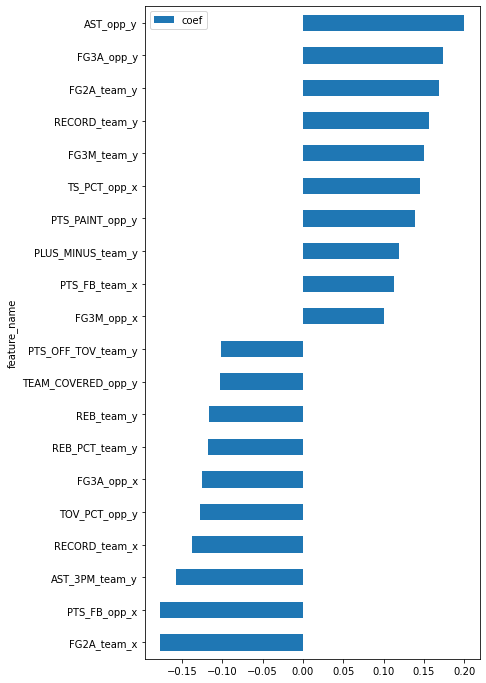

In [47]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                               max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train[sfs_selected_cols_sgd], y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd_hinge_no_diffs_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=200)

sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_hinge = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                               max_iter=1000,
                                     random_state=23))])


print("best_sgd:", best_sgd_hinge)

best_sgd_hinge.fit(X_train[sfs_selected_cols_sgd], y_train)

print("train_score:", best_sgd_hinge.score(X_train[sfs_selected_cols_sgd], y_train))
print("test_score:", best_sgd_hinge.score(X_test[sfs_selected_cols_sgd], y_test))

view_model_coefs(best_sgd_hinge.named_steps['sgd'], X_train[sfs_selected_cols_sgd])

0.014554382150950817
best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.014554382150950817, random_state=23))])
train_score: 0.5339445114595899
test_score: 0.5154529886650902


feature_name      coef
74         TS_PCT_opp_y -0.184929
27         PTS_FB_opp_x -0.181620
44           STL_team_y -0.137118
16           FG3A_opp_x -0.123868
55            STL_opp_y -0.107125
62        AST_3PM_opp_y -0.107022
42          DREB_team_y -0.106098
53         RECORD_opp_y -0.104911
0         RECORD_team_x -0.100979
67             WL_PCT_y -0.088261
64       UAST_3PM_opp_y -0.085632
28      PTS_PAINT_opp_x -0.077063
18            AST_opp_x -0.071574
38      AST_RATIO_opp_x -0.067722
66   TEAM_COVERED_opp_y -0.066556
58   E_DEF_RATING_opp_y -0.062008
47  E_OFF_RATING_team_y -0.062008
49  E_NET_RATING_team_y -0.054608
77         opp_rating_i -0.049328
68            ATS_PCT_y -0.041196
73        TS_PCT_team_y -0.039788
4            PTS_team_x -0.039119
71               REST_y -0.036787
15           FG2A_opp_x -0.034563
9            PIE_team_x -0.031509
45           TOV_team_y -0.029994
20             PF_opp_x -0.029891
14           FG2M_opp_x -0.029625
7   E_NET_RATING_team_x -0.025801
52      ATS_DIFF_team_y -0.018903
12      ATS_DIFF_team_x -0.018830
3             PF_team_x -0.017676
35       DREB_PCT_opp_x -0.015725
63       UAST_2PM_opp_y -0.014325
46    PLUS_MINUS_team_y -0.012330
24           POSS_opp_x -0.009192
69             AVG_ML_y -0.002829
56     PLUS_MINUS_opp_y  0.012330
48  E_DEF_RATING_team_y  0.012334
57   E_OFF_RATING_opp_y  0.012334
1           OREB_team_x  0.013420
11     PTS_PAINT_team_x  0.013773
43           AST_team_y  0.014563
30       ATS_DIFF_opp_x  0.018830
65       ATS_DIFF_opp_y  0.018903
37     AST_RATIO_team_x  0.019991
8           POSS_team_x  0.020641
70       AVG_ATS_DIFF_y  0.022882
23   E_NET_RATING_opp_x  0.025801
61    PTS_OFF_TOV_opp_y  0.029571
33            ATS_PCT_x  0.030074
25            PIE_opp_x  0.031197
34               REST_x  0.034139
76        team_rating_i  0.040789
26     PTS_2PT_MR_opp_x  0.044543
72       DREB_PCT_opp_y  0.047945
50      UAST_2PM_team_y  0.051643
59   E_NET_RATING_opp_y  0.054608
22   E_DEF_RATING_opp_x  0.055761
5   E_OFF_RATING_team_x  0.055761
32             WL_PCT_x  0.067387
78         elo_MOV_pred  0.067493
29       UAST_3PM_opp_x  0.073025
17           DREB_opp_x  0.074814
31   TEAM_COVERED_opp_x  0.075244
21   E_OFF_RATING_opp_x  0.096205
6   E_DEF_RATING_team_x  0.096205
13         RECORD_opp_x  0.100979
36        TS_PCT_team_x  0.104825
40        RECORD_team_y  0.104911
39        TOV_PCT_opp_x  0.123124
10   PTS_OFF_TOV_team_x  0.126537
51      UAST_3PM_team_y  0.130476
41          FG2M_team_y  0.134985
19            STL_opp_x  0.139144
75      AST_RATIO_opp_y  0.144801
2           DREB_team_x  0.159838
60         PTS_FB_opp_y  0.196936
54           FG3A_opp_y  0.216212
79        SPREAD_team_x  0.282517

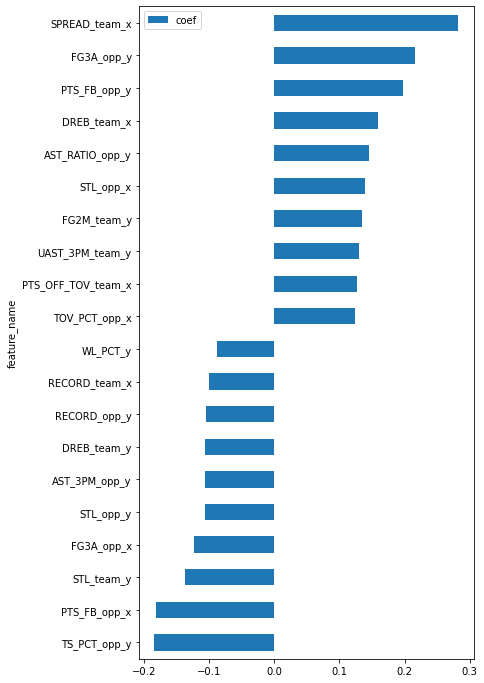

In [20]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_hinge = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                               max_iter=1000,
                                     random_state=23))])


print("best_sgd:", best_sgd_hinge)

best_sgd_hinge.fit(X_train[selected_cols], y_train)

print("train_score:", best_sgd_hinge.score(X_train[selected_cols], y_train))
print("test_score:", best_sgd_hinge.score(X_test[selected_cols], y_test))

view_model_coefs(best_sgd_hinge.named_steps['sgd'], X_train[selected_cols])

### SGD Modified Huber

In [58]:
sfs_pipe_sgd_huber = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(SGDClassifier(loss='modified_huber', random_state=23, alpha=0.5629982879384883),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])

sfs_pipe_sgd_huber.fit(X_train, y_train)

res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    6.1s finished
Features: 1/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    6.2s finished
Features: 2/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    6.8s finished
Features: 3/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    6.8s finished
Features: 4/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    7.0s finished
Features: 5/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    7.2s finished
Features: 6/172[Par

[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:   17.5s finished
Features: 50/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:   17.9s finished
Features: 51/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:   17.8s finished
Features: 52/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   18.2s finished
Features: 53/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:   18.2s finished
Features: 54/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   18.7s finished
Features: 55/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

Features: 99/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   18.8s finished
Features: 100/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   18.8s finished
Features: 101/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   18.6s finished
Features: 102/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.4s finished
Features: 103/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   18.9s finished
Features: 104/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   18.3s fi

Features: 148/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    8.9s finished
Features: 149/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    8.9s finished
Features: 150/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    8.2s finished
Features: 151/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    8.0s finished
Features: 152/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished
Features: 153/172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    7.3s f

Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x', 'REB_team_x',
       'AST_team_x',
       ...
       'AVG_SPREAD_y', 'REST_y', 'TS_PCT_team_y', 'EFG_PCT_opp_y',
       'AST_RATIO_team_y', 'team_elo_pred', 'opp_rating_i', 'elo_MOV_pred',
       'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=103)

In [59]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd2_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=200)

[I 2021-11-09 21:18:01,156] A new study created in RDB with name: study_sgd2_sfs
[I 2021-11-09 21:18:04,341] Trial 0 finished with value: 0.5012159814707584 and parameters: {'alpha': 1.2798775788099378e-05}. Best is trial 0 with value: 0.5012159814707584.
[I 2021-11-09 21:18:06,552] Trial 1 finished with value: 0.5094962362478286 and parameters: {'alpha': 7.37072602779003e-05}. Best is trial 1 with value: 0.5094962362478286.
[I 2021-11-09 21:18:07,603] Trial 2 finished with value: 0.5142443543717429 and parameters: {'alpha': 0.0025771204555202817}. Best is trial 2 with value: 0.5142443543717429.
[I 2021-11-09 21:18:08,300] Trial 3 finished with value: 0.5240880138969312 and parameters: {'alpha': 0.07262820600948978}. Best is trial 3 with value: 0.5240880138969312.
[I 2021-11-09 21:18:09,149] Trial 4 finished with value: 0.5 and parameters: {'alpha': 14.124673750183794}. Best is trial 3 with value: 0.5240880138969312.
[I 2021-11-09 21:18:09,841] Trial 5 finished with value: 0.5245512449

[I 2021-11-09 21:18:39,510] Trial 44 finished with value: 0.5074116965836711 and parameters: {'alpha': 4.999201124092754}. Best is trial 14 with value: 0.5267515923566879.
[I 2021-11-09 21:18:40,222] Trial 45 finished with value: 0.524203821656051 and parameters: {'alpha': 0.24937926059553378}. Best is trial 14 with value: 0.5267515923566879.
[I 2021-11-09 21:18:41,017] Trial 46 finished with value: 0.5 and parameters: {'alpha': 22.96097038510841}. Best is trial 14 with value: 0.5267515923566879.
[I 2021-11-09 21:18:42,857] Trial 47 finished with value: 0.5041690793283149 and parameters: {'alpha': 0.0003478461276825142}. Best is trial 14 with value: 0.5267515923566879.
[I 2021-11-09 21:18:43,525] Trial 48 finished with value: 0.5232194557035321 and parameters: {'alpha': 0.0555006538678204}. Best is trial 14 with value: 0.5267515923566879.
[I 2021-11-09 21:18:44,212] Trial 49 finished with value: 0.5253039953676896 and parameters: {'alpha': 0.8169845991166821}. Best is trial 14 with val

[I 2021-11-09 21:19:14,115] Trial 89 finished with value: 0.5265778807180082 and parameters: {'alpha': 0.9437379863265484}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:14,796] Trial 90 finished with value: 0.5235089751013318 and parameters: {'alpha': 1.0962039424640582}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:15,382] Trial 91 finished with value: 0.519166184134337 and parameters: {'alpha': 2.00408986233984}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:15,976] Trial 92 finished with value: 0.5253039953676896 and parameters: {'alpha': 0.8413139716113841}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:16,713] Trial 93 finished with value: 0.5020266357845976 and parameters: {'alpha': 6.324714824118353}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:17,407] Trial 94 finished with value: 0.5206137811233352 and parameters: {'alpha': 1.5050183905670977}. Best is trial 5

[I 2021-11-09 21:19:44,096] Trial 134 finished with value: 0.5254777070063694 and parameters: {'alpha': 0.5816191127603645}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:44,689] Trial 135 finished with value: 0.5266357845975681 and parameters: {'alpha': 0.9615685061823913}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:45,383] Trial 136 finished with value: 0.5209612044006949 and parameters: {'alpha': 1.337151616115345}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:46,071] Trial 137 finished with value: 0.5115807759119861 and parameters: {'alpha': 4.043947443496845}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:46,695] Trial 138 finished with value: 0.5235668789808916 and parameters: {'alpha': 0.26439414413807316}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:19:47,375] Trial 139 finished with value: 0.518355529820498 and parameters: {'alpha': 2.0614408230402}. Best is tr

[I 2021-11-09 21:20:12,480] Trial 178 finished with value: 0.5229878401852924 and parameters: {'alpha': 1.3050150603317732}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:20:13,204] Trial 179 finished with value: 0.5257672264041691 and parameters: {'alpha': 0.22091134432647558}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:20:13,786] Trial 180 finished with value: 0.5253039953676896 and parameters: {'alpha': 0.6267034628208924}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:20:14,466] Trial 181 finished with value: 0.5265778807180082 and parameters: {'alpha': 0.9430562918034057}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:20:15,168] Trial 182 finished with value: 0.5265199768384482 and parameters: {'alpha': 0.9386967625692548}. Best is trial 53 with value: 0.5268674001158077.
[I 2021-11-09 21:20:15,750] Trial 183 finished with value: 0.5209612044006949 and parameters: {'alpha': 1.5476500104905286}. Best

0.901283698122614
best_sgd: Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x', 'REB_team_x',
       'AST_team_x',
       ...
       'AVG_SPREAD_y', 'REST_y', 'TS_PCT_team_y', 'EFG_PCT_opp_y',
       'AST_RATIO_team_y', 'team_elo_pred', 'opp_rating_i', 'elo_MOV_pred',
       'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=103))])),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.901283698122614, loss='modified_huber',
                               random_state=23))])
train_score: 0.535729794933655
test_score: 0.5152898964364349


feature_name      coef
38          PTS_FB_opp_x -0.018210
96         EFG_PCT_opp_y -0.013886
2            FG2A_team_x -0.011264
18       UAST_3PM_team_x -0.011227
73        AST_3PM_team_y -0.009368
87        UAST_2PM_opp_y -0.008079
0          RECORD_team_x -0.007948
75          RECORD_opp_y -0.007861
62           FG3A_team_y -0.007422
32              PF_opp_x -0.007183
56       AST_RATIO_opp_x -0.007119
88        UAST_3PM_opp_y -0.007007
95         TS_PCT_team_y -0.006696
23            FG3A_opp_x -0.006464
29             AST_opp_x -0.006409
21            FG2M_opp_x -0.005886
77            FG3M_opp_y -0.004624
49        OREB_PCT_opp_x -0.004511
90    TEAM_COVERED_opp_y -0.004296
46        AVG_ATS_DIFF_x -0.003992
26            OREB_opp_x -0.003737
39     PTS_OFF_TOV_opp_x -0.003423
63           OREB_team_y -0.003259
66            AST_team_y -0.003229
25             FTA_opp_x -0.002955
99          opp_rating_i -0.002384
1            FG2M_team_x -0.002013
11     PLUS_MINUS_team_x -0.001787
80             PTS_opp_y -0.001766
17       UAST_2PM_team_x -0.001669
71            PIE_team_y -0.001586
19       ATS_DIFF_team_x -0.001474
28             REB_opp_x -0.001463
37             PIE_opp_x -0.001307
89        ATS_DIFF_opp_y -0.001274
94                REST_y -0.001107
81      PLUS_MINUS_opp_y -0.001022
10            TOV_team_x -0.000954
92             ATS_PCT_y -0.000941
72        AST_2PM_team_y -0.000755
65            REB_team_y -0.000496
57        TOV_PCT_team_x -0.000450
70   E_NET_RATING_team_y -0.000365
13   E_NET_RATING_team_x -0.000114
45              AVG_ML_x -0.000072
79              PF_opp_y -0.000039
35    E_NET_RATING_opp_x  0.000114
55      AST_RATIO_team_x  0.000357
84    E_NET_RATING_opp_y  0.000365
27            DREB_opp_x  0.000486
22            FG2A_opp_x  0.000667
97      AST_RATIO_team_y  0.000869
67     PLUS_MINUS_team_y  0.001022
44             ATS_PCT_x  0.001217
14            PIE_team_x  0.001297
61           FG3M_team_y  0.001361
42        ATS_DIFF_opp_x  0.001474
85             PIE_opp_y  0.001596
4             FTM_team_x  0.001635
9             AST_team_x  0.001692
47                REST_x  0.001703
60           FG2M_team_y  0.001760
33      PLUS_MINUS_opp_x  0.001787
36            POSS_opp_x  0.001803
64           DREB_team_y  0.001817
91              WL_PCT_y  0.001819
68   E_OFF_RATING_team_y  0.001933
83    E_DEF_RATING_opp_y  0.001933
74       UAST_2PM_team_y  0.002085
54        EFG_PCT_team_x  0.002093
6            OREB_team_x  0.002156
3            FG3M_team_x  0.002324
24             FTM_opp_x  0.002465
82    E_OFF_RATING_opp_y  0.002611
69   E_DEF_RATING_team_y  0.002611
48       OREB_PCT_team_x  0.002683
52         TS_PCT_team_x  0.002734
5             FTA_team_x  0.002744
7            DREB_team_x  0.003600
98         team_elo_pred  0.004094
8             REB_team_x  0.004408
40        UAST_2PM_opp_x  0.004469
50       DREB_PCT_team_x  0.004511
51        REB_PCT_team_x  0.004656
100         elo_MOV_pred  0.005084
93          AVG_SPREAD_y  0.005151
12   E_DEF_RATING_team_x  0.005168
34    E_OFF_RATING_opp_x  0.005168
43    TEAM_COVERED_opp_x  0.006173
41        UAST_3PM_opp_x  0.007164
16        AST_3PM_team_x  0.007366
59         RECORD_team_y  0.007861
102            ML_team_x  0.007929
20          RECORD_opp_x  0.007948
31             TOV_opp_x  0.008659
53          TS_PCT_opp_x  0.008719
58         TOV_PCT_opp_x  0.009531
30             STL_opp_x  0.009890
78            FG3A_opp_y  0.011894
76            FG2M_opp_y  0.013440
15    PTS_OFF_TOV_team_x  0.014630
86          PTS_FB_opp_y  0.016391
101        SPREAD_team_x  0.017111

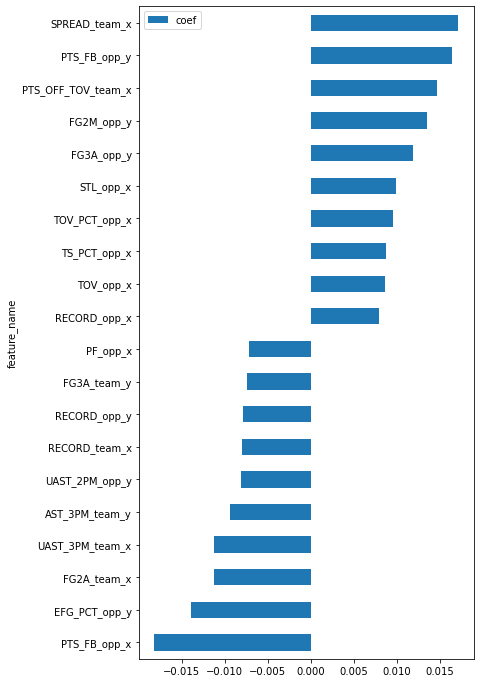

In [75]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_huber = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    


print("best_sgd:", best_sgd)

best_sgd_huber.fit(X_train, y_train)

print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

view_model_coefs(best_sgd_huber.named_steps['sgd'], X_train[sfs_selected_cols_huber])

### LGBClassifier

In [61]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        num_leaves=num_leaves, 
                                        random_state=23,
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                       learning_rate=learning_rate)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_no_diffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2021-11-10 09:59:38,747] A new study created in RDB with name: ../models/hyperparameter_tuning/study_lgbc_no_diffs
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2021-11-10 09:59:48,790] Trial 0 finished with value: 0.5073537927041112 and parameters: {'min_child_weight': 0.020266042665353274, 'subsample': 0.6704058010679631, 'max_depth': 27, 'reg_lambda': 9.558206578063828, 'reg_alpha': 4.977258134261778, 'num_leaves': 80, 'colsample_bytree': 0.371324013150127, 'learning_rate': 0.004741353260543614}. Best is trial 0 with value: 0.5073537927041112.
[I 2021-11-10 09:59:54,400] Trial 1 finished with value: 0.5057324840764331 and parameters: {'min_child_weight': 0.24670813164398286, 'subsample': 0.8171957157542505, 'max_depth': 10, 'reg_lambda': 9.217054868638035, 'reg_alpha': 3.1868992067940978, 'num_leaves': 386, 'colsample_bytree': 0.12657921192954089, 'learning_rate': 0.2064573470432766}. Best is trial 0 with value: 0.5073537927041112.
[I 2021-11-10 10:00:15,291] Trial 2 finished with value: 0.5083960625361899 and parameters: {'min_child_weight': 0.4924443465247031, 'subsample': 0.9654034958449073, 'max_depth': 28, 'reg_lambda': 1.8531749399

[I 2021-11-10 10:04:01,269] Trial 21 finished with value: 0.5027793862188765 and parameters: {'min_child_weight': 0.12999829365331117, 'subsample': 0.9470491506128995, 'max_depth': 6, 'reg_lambda': 1.7174604739461552, 'reg_alpha': 1.9073343736970165, 'num_leaves': 318, 'colsample_bytree': 0.2073276046701733, 'learning_rate': 0.9836316980308047}. Best is trial 11 with value: 0.5113491603937464.
[I 2021-11-10 10:04:07,132] Trial 22 finished with value: 0.5060799073537927 and parameters: {'min_child_weight': 0.05061663006124539, 'subsample': 0.890409036160128, 'max_depth': 9, 'reg_lambda': 2.2126480713266012, 'reg_alpha': 1.1561171639369294, 'num_leaves': 250, 'colsample_bytree': 0.23063378978354881, 'learning_rate': 0.34932966137358845}. Best is trial 11 with value: 0.5113491603937464.
[I 2021-11-10 10:04:10,539] Trial 23 finished with value: 0.5097278517660684 and parameters: {'min_child_weight': 0.40214872370215315, 'subsample': 0.9947738319500169, 'max_depth': 4, 'reg_lambda': 1.03347

[I 2021-11-10 10:08:04,554] Trial 42 finished with value: 0.5144759698899827 and parameters: {'min_child_weight': 0.4587756874664521, 'subsample': 0.6129309290956223, 'max_depth': 9, 'reg_lambda': 9.870254578563861, 'reg_alpha': 2.40165039002436, 'num_leaves': 279, 'colsample_bytree': 0.9115082361208594, 'learning_rate': 0.06595518914574666}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:08:21,408] Trial 43 finished with value: 0.5053271569195136 and parameters: {'min_child_weight': 0.4305689426916502, 'subsample': 0.6084934713217685, 'max_depth': 9, 'reg_lambda': 4.251636410236685, 'reg_alpha': 2.5022876982137987, 'num_leaves': 205, 'colsample_bytree': 0.9131270328681184, 'learning_rate': 0.07277135948475422}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:08:25,954] Trial 44 finished with value: 0.5046902142443545 and parameters: {'min_child_weight': 0.5219191030942147, 'subsample': 0.6474698357794769, 'max_depth': 4, 'reg_lambda': 8.93434186669

[I 2021-11-10 10:12:04,596] Trial 63 finished with value: 0.5138390272148234 and parameters: {'min_child_weight': 0.9234279044831692, 'subsample': 0.7144723020424744, 'max_depth': 31, 'reg_lambda': 9.894462813840097, 'reg_alpha': 4.9810412251401575, 'num_leaves': 32, 'colsample_bytree': 0.6998361562597968, 'learning_rate': 0.054561016998018914}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:12:16,795] Trial 64 finished with value: 0.5131441806601043 and parameters: {'min_child_weight': 0.9879544298355475, 'subsample': 0.6575745864749636, 'max_depth': 32, 'reg_lambda': 9.120834898695767, 'reg_alpha': 4.9643007436660485, 'num_leaves': 54, 'colsample_bytree': 0.7090123196140472, 'learning_rate': 0.05373924134818555}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:12:32,310] Trial 65 finished with value: 0.5088592935726693 and parameters: {'min_child_weight': 0.9301198658639365, 'subsample': 0.6338561832652572, 'max_depth': 29, 'reg_lambda': 8.3659331

[I 2021-11-10 10:16:41,425] Trial 84 finished with value: 0.506716850028952 and parameters: {'min_child_weight': 0.7390688297452469, 'subsample': 0.7495561177766383, 'max_depth': 28, 'reg_lambda': 9.29214426577154, 'reg_alpha': 4.613678063557081, 'num_leaves': 3, 'colsample_bytree': 0.8584325082586988, 'learning_rate': 0.04147726645944185}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:16:56,440] Trial 85 finished with value: 0.5105385060799074 and parameters: {'min_child_weight': 0.300353088100112, 'subsample': 0.6783196956484625, 'max_depth': 31, 'reg_lambda': 9.720043404608957, 'reg_alpha': 4.031847822049943, 'num_leaves': 74, 'colsample_bytree': 0.9087199689830459, 'learning_rate': 0.08280672157082901}. Best is trial 39 with value: 0.5163288940359004.
[I 2021-11-10 10:17:04,893] Trial 86 finished with value: 0.5088592935726693 and parameters: {'min_child_weight': 0.9189426482100644, 'subsample': 0.7277887726889214, 'max_depth': 6, 'reg_lambda': 9.439899410004807

best_lgbc: LGBMClassifier(colsample_bytree=0.8407838610664131,
               learning_rate=0.040022877441725196, max_depth=6,
               min_child_weight=0.4495756229471384, num_leaves=404,
               random_state=23, reg_alpha=2.4943648274534036,
               reg_lambda=4.579191385748681, subsample=0.641171893818833)
train_acc: 0.8122074788902292
test_acc: 0.5106417679197586
LGBoost or XGBoost


feature_name  coef
49   E_DEF_RATING_opp_x     1
151              REST_y     2
68               REST_x     3
47     PLUS_MINUS_opp_x     4
132  E_DEF_RATING_opp_y     5
..                  ...   ...
112     UAST_3PM_team_y    58
136    PTS_2PT_MR_opp_y    61
54         PTS_FB_opp_x    62
62   TEAM_COVERED_opp_x    64
145  TEAM_COVERED_opp_y    67

[172 rows x 2 columns]

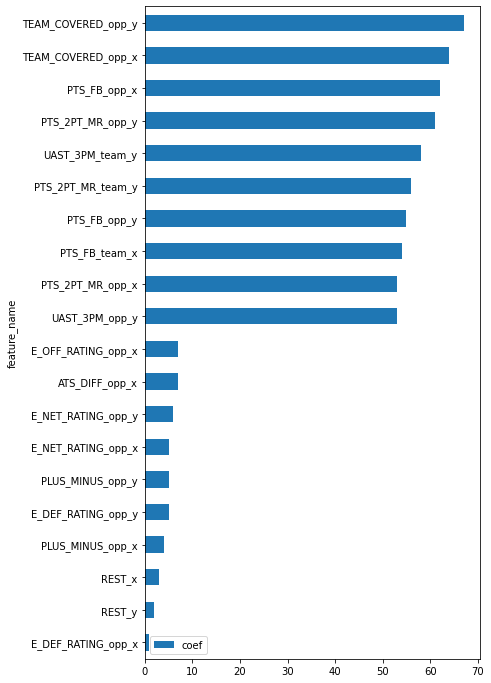

In [77]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [71]:
from sklearn.decomposition import PCA


### KNNeighbors

In [109]:
sfs_pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=0.95)),
                                    ('knn',
                                     SFS(KNeighborsClassifier(n_neighbors=41),
                                    k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_knn.fit(X_train, y_train)




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   27.2s finished
Features: 1/46[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   29.0s finished
Features: 2/46[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   33.8s finished
Features: 3/46[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   38.9s finished
Features: 4/46[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   48.0s finished
Features: 5/46[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   58.0s finished
Features: 6/46[Parallel(

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                           estimator=KNeighborsClassifier(n_neighbors=41),
                                           k_features='best',
                                           scoring='accuracy', verbose=1))])

In [117]:
res = pd.DataFrame.from_dict(sfs_pipe_knn.named_steps['knn'].get_metric_dict()).T

best_trial = res.sort_values('avg_score', ascending=False).index[2]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_knn = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_knn
res.sort_values('avg_score', ascending=False)


feature_idx  \
8                     (9, 14, 17, 24, 26, 27, 37, 39)   
20  (9, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33, 35...   
35  (0, 1, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 21...   
27  (7, 9, 10, 14, 15, 17, 21, 24, 26, 27, 29, 30,...   
19  (9, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33, 35...   
17  (9, 14, 15, 17, 24, 26, 27, 29, 32, 33, 35, 37...   
23  (9, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33, 34...   
25  (7, 9, 10, 14, 15, 17, 21, 24, 26, 27, 29, 32,...   
10            (9, 14, 17, 24, 26, 27, 37, 38, 39, 45)   
7                         (9, 14, 17, 24, 26, 27, 37)   
21  (9, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33, 35...   
32  (0, 1, 7, 8, 9, 10, 14, 15, 17, 19, 21, 24, 26...   
16  (9, 14, 15, 17, 24, 26, 27, 29, 32, 33, 37, 38...   
11        (9, 14, 17, 24, 26, 27, 29, 37, 38, 39, 45)   
22  (9, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33, 35...   
24  (9, 10, 14, 15, 17, 21, 24, 26, 27, 29, 32, 33...   
26  (7, 9, 10, 14, 15, 17, 21, 24, 26, 27, 29, 31,...   
14  (9, 14, 17, 24, 26, 27, 29, 33, 37, 38, 39, 40...   
13  (9, 14, 17, 24, 26, 27, 29, 33, 37, 38, 39, 41...   
9                 (9, 14, 17, 24, 26, 27, 37, 38, 39)   
33  (0, 1, 7, 8, 9, 10, 14, 15, 17, 19, 21, 24, 25...   
18  (9, 14, 15, 17, 24, 26, 27, 29, 32, 33, 35, 36...   
12    (9, 14, 17, 24, 26, 27, 29, 37, 38, 39, 41, 45)   
31  (0, 1, 7, 8, 9, 10, 14, 15, 17, 19, 21, 24, 26...   
39  (0, 1, 3, 5, 7, 8, 9, 10, 13, 14, 15, 17, 18, ...   
28  (7, 9, 10, 14, 15, 17, 19, 21, 24, 26, 27, 29,...   
34  (0, 1, 7, 8, 9, 10, 14, 15, 17, 18, 19, 21, 24...   
44  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...   
36  (0, 1, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 21...   
3                                         (9, 14, 24)   
29  (1, 7, 9, 10, 14, 15, 17, 19, 21, 24, 26, 27, ...   
37  (0, 1, 5, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19,...   
43  (0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
6                             (9, 14, 17, 24, 27, 37)   
30  (1, 7, 8, 9, 10, 14, 15, 17, 19, 21, 24, 26, 2...   
5                                 (9, 14, 24, 27, 37)   
42  (0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 1...   
40  (0, 1, 3, 5, 7, 8, 9, 10, 11, 13, 14, 15, 17, ...   
15  (9, 14, 15, 17, 24, 26, 27, 29, 33, 37, 38, 39...   
38  (0, 1, 3, 5, 7, 8, 9, 10, 13, 14, 15, 17, 18, ...   
4                                     (9, 14, 24, 37)   
41  (0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 1...   
45  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1                                               (14,)   
2                                            (14, 24)   
46  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            cv_scores avg_score  \
8   [0.5286624203821656, 0.5005790387955993, 0.523...  0.518008   
20  [0.526635784597568, 0.5167921250723798, 0.5112...  0.517661   
35  [0.5043427909669947, 0.5272148233931674, 0.515...  0.517545   
27  [0.5251881876085698, 0.5147654892877823, 0.517...   0.51714   
19  [0.520845396641575, 0.5205558772437753, 0.5170...  0.516908   
17  [0.5318471337579618, 0.4939200926462073, 0.518...  0.516908   
23  [0.5315576143601621, 0.50839606253619, 0.52171...  0.516908   
25  [0.5303995367689636, 0.5248986682107701, 0.521...   0.51685   
10  [0.5170816444701795, 0.5055008685581934, 0.525...   0.51685   
7   [0.5303995367689636, 0.5095541401273885, 0.517...  0.516676   
21  [0.519976838448176, 0.513317892298784, 0.51968...  0.516445   
32  [0.5121598147075854, 0.515055008685582, 0.5069...  0.516387   
16  [0.5338737695425594, 0.4988419224088014, 0.521...  0.516329   
11  [0.528372900984366, 0.515055008685582, 0.51302...  0.516097   
22  [0.5272148233931674, 0.5110017371163867, 0.511...  0.516097   
24  [0.519976838448176, 0.5211349160393747, 0.5257...  0.516039   
26  [0.5277938621887667, 0.5260567458019687, 0.516...  0.515866   
14  [0.5295309785755645, 0.5124493341053851, 0.518...   0.51575   
13  [0.5338737695425594, 0.5046323103647944, 0.522...  0.515576   
9   [0.520266357845975

In [119]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
#     n_components = trial.suggest_float('n_components', 0.9, 0.99)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
#         ('pca', PCA(n_components=n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_knn_no_diffs_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 50, 4).tolist(),
#                'n_components':np.linspace(0.9, 0.99, 10).tolist()
               }

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-11-10 14:33:39,468] A new study created in RDB with name: ../models/hyperparameter_tuning/study_knn_no_diffs_sfs
[I 2021-11-10 14:33:42,436] Trial 0 finished with value: 0.5056166763173133 and parameters: {'n_neighbors': 47}. Best is trial 0 with value: 0.5056166763173133.
[I 2021-11-10 14:33:45,439] Trial 1 finished with value: 0.5037637521713955 and parameters: {'n_neighbors': 7}. Best is trial 0 with value: 0.5056166763173133.
[I 2021-11-10 14:33:48,401] Trial 2 finished with value: 0.5057903879559931 and parameters: {'n_neighbors': 27}. Best is trial 2 with value: 0.5057903879559931.
[I 2021-11-10 14:33:51,300] Trial 3 finished with value: 0.5072958888245512 and parameters: {'n_neighbors': 23}. Best is trial 3 with value: 0.5072958888245512.
[I 2021-11-10 14:33:54,268] Trial 4 finished with value: 0.5078749276201504 and parameters: {'n_neighbors': 11}. Best is trial 4 with value: 0.5078749276201504.
[I 2021-11-10 14:33:56,913] Trial 5 finished with value: 0.4997683844817603

In [120]:
# best_n = study_knn.best_trial.params['n_neighbors']
# best_n_components = study_knn.best_trial.params['n_components']
# print("best_n_neighbors:", best_n, "best_n_components:", best_n_components)



best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=19))])

print(best_knn)

best_knn.fit(X_train, y_train)
print(best_knn.score(X_train, y_train))
print(best_knn.score(X_test, y_test))

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=19))])
0.5880337756332932
0.5006115958574574


### Random Forest

In [63]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_rf2_no_diffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=200)

[I 2021-11-10 11:24:31,959] Using an existing study with name '../models/hyperparameter_tuning/study_rf2_no_diffs' instead of creating a new one.
[I 2021-11-10 11:24:35,867] Trial 100 finished with value: 0.5123914302258251 and parameters: {'min_samples_split': 0.22333175770818106, 'max_depth': 19, 'min_samples_leaf': 0.1642151422826145}. Best is trial 36 with value: 0.5136074116965836.
[I 2021-11-10 11:24:39,849] Trial 101 finished with value: 0.5118123914302258 and parameters: {'min_samples_split': 0.20671896796658482, 'max_depth': 19, 'min_samples_leaf': 0.16227976500877309}. Best is trial 36 with value: 0.5136074116965836.
[I 2021-11-10 11:24:43,606] Trial 102 finished with value: 0.5145917776491025 and parameters: {'min_samples_split': 0.22415776502857174, 'max_depth': 18, 'min_samples_leaf': 0.1671979407654873}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:24:47,865] Trial 103 finished with value: 0.5095541401273885 and parameters: {'min_samples_split': 0.22

[I 2021-11-10 11:26:30,336] Trial 132 finished with value: 0.5112333526346265 and parameters: {'min_samples_split': 0.14790306279491122, 'max_depth': 26, 'min_samples_leaf': 0.1560406360189416}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:26:34,983] Trial 133 finished with value: 0.5084539664157498 and parameters: {'min_samples_split': 0.1870849588110641, 'max_depth': 29, 'min_samples_leaf': 0.13555702686172622}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:26:36,137] Trial 134 finished with value: 0.49988419224088015 and parameters: {'min_samples_split': 0.1677583968041467, 'max_depth': 23, 'min_samples_leaf': 0.40459645264344435}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:26:39,564] Trial 135 finished with value: 0.5101331789229879 and parameters: {'min_samples_split': 0.17774108237442143, 'max_depth': 18, 'min_samples_leaf': 0.18832007659414812}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:2

[I 2021-11-10 11:28:25,377] Trial 164 finished with value: 0.514128546612623 and parameters: {'min_samples_split': 0.04214975392669725, 'max_depth': 18, 'min_samples_leaf': 0.16702608645129088}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:28:29,006] Trial 165 finished with value: 0.5084539664157498 and parameters: {'min_samples_split': 0.10866036039619922, 'max_depth': 19, 'min_samples_leaf': 0.15050118184868938}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:28:33,264] Trial 166 finished with value: 0.5123335263462652 and parameters: {'min_samples_split': 0.03166303352654919, 'max_depth': 18, 'min_samples_leaf': 0.16205302381709352}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:28:37,143] Trial 167 finished with value: 0.5097857556456282 and parameters: {'min_samples_split': 0.09720928199566178, 'max_depth': 20, 'min_samples_leaf': 0.1855821842735784}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:2

[I 2021-11-10 11:30:27,875] Trial 196 finished with value: 0.5128546612623046 and parameters: {'min_samples_split': 0.07614212240485743, 'max_depth': 28, 'min_samples_leaf': 0.17255322962189668}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:30:30,938] Trial 197 finished with value: 0.5089171974522293 and parameters: {'min_samples_split': 0.04943589780271945, 'max_depth': 28, 'min_samples_leaf': 0.18897932059840405}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:30:35,178] Trial 198 finished with value: 0.5087434858135494 and parameters: {'min_samples_split': 0.06851367358990522, 'max_depth': 27, 'min_samples_leaf': 0.14041077087779447}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:30:38,932] Trial 199 finished with value: 0.5129125651418646 and parameters: {'min_samples_split': 0.06144076459679183, 'max_depth': 29, 'min_samples_leaf': 0.17404567023623113}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11

[I 2021-11-10 11:32:16,482] Trial 228 finished with value: 0.5089751013317892 and parameters: {'min_samples_split': 0.2700816497204188, 'max_depth': 22, 'min_samples_leaf': 0.19105641909747112}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:32:19,724] Trial 229 finished with value: 0.5116965836711059 and parameters: {'min_samples_split': 0.28592807231831047, 'max_depth': 21, 'min_samples_leaf': 0.171036418773903}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:32:23,181] Trial 230 finished with value: 0.5102489866821077 and parameters: {'min_samples_split': 0.2752805218462914, 'max_depth': 23, 'min_samples_leaf': 0.15230070107402982}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:32:26,438] Trial 231 finished with value: 0.5118702953097858 and parameters: {'min_samples_split': 0.24976834877538648, 'max_depth': 22, 'min_samples_leaf': 0.1773175698437999}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:32:2

[I 2021-11-10 11:33:57,864] Trial 260 finished with value: 0.5096120440069484 and parameters: {'min_samples_split': 0.2667892744933717, 'max_depth': 30, 'min_samples_leaf': 0.1540869858424021}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:34:00,762] Trial 261 finished with value: 0.5089751013317894 and parameters: {'min_samples_split': 0.08720804993026716, 'max_depth': 22, 'min_samples_leaf': 0.1918555753255957}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:34:03,150] Trial 262 finished with value: 0.5090330052113492 and parameters: {'min_samples_split': 0.2559750662867758, 'max_depth': 29, 'min_samples_leaf': 0.26969449439637455}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:34:06,367] Trial 263 finished with value: 0.5111754487550666 and parameters: {'min_samples_split': 0.1256670620225051, 'max_depth': 17, 'min_samples_leaf': 0.1683461800690678}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:34:09

[I 2021-11-10 11:35:43,382] Trial 292 finished with value: 0.5105385060799073 and parameters: {'min_samples_split': 0.24965037151146943, 'max_depth': 23, 'min_samples_leaf': 0.15345122774382433}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:35:46,682] Trial 293 finished with value: 0.5122177185871453 and parameters: {'min_samples_split': 0.2183857623989035, 'max_depth': 9, 'min_samples_leaf': 0.17236138438850185}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:35:49,078] Trial 294 finished with value: 0.5084539664157498 and parameters: {'min_samples_split': 0.2590795091475915, 'max_depth': 25, 'min_samples_leaf': 0.2894258635906123}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:35:52,373] Trial 295 finished with value: 0.5097857556456283 and parameters: {'min_samples_split': 0.061012389710136394, 'max_depth': 5, 'min_samples_leaf': 0.1813668007455386}. Best is trial 102 with value: 0.5145917776491025.
[I 2021-11-10 11:35:5

In [64]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = RandomForestClassifier(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                random_state=23)

{'max_depth': 18, 'min_samples_leaf': 0.1671979407654873, 'min_samples_split': 0.22415776502857174}


In [65]:
best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.5383835946924005
rf test_acc: 0.5080322922612738


LGBoost or XGBoost


feature_name      coef
45              PF_opp_x  0.001822
171            ML_team_x  0.002138
167        team_rating_i  0.002151
3            FG3M_team_x  0.002209
18   E_DEF_RATING_team_x  0.002478
74         REB_PCT_opp_x  0.002503
162     AST_RATIO_team_y  0.002695
122           DREB_opp_y  0.002768
25      PTS_PAINT_team_x  0.003066
126            BLK_opp_y  0.003348
67        AVG_ATS_DIFF_x  0.003356
19   E_NET_RATING_team_x  0.003589
10            AST_team_x  0.003681
164       TOV_PCT_team_y  0.003712
37             FTA_opp_x  0.003898
21            PIE_team_x  0.003929
112      UAST_3PM_team_y  0.003991
26        AST_2PM_team_x  0.004051
17   E_OFF_RATING_team_x  0.004058
1            FG2M_team_x  0.004137
141        AST_3PM_opp_y  0.004197
101  E_DEF_RATING_team_y  0.004392
12            BLK_team_x  0.004495
70        OREB_PCT_opp_x  0.004542
138    PTS_OFF_TOV_opp_y  0.004944
23         PTS_FB_team_x  0.005036
83         RECORD_team_y  0.005063
32            FG2M_opp_x  0.005259
47      PLUS_MINUS_opp_x  0.005782
4            FG3A_team_x  0.005925
87           FG3A_team_y  0.007093
71       DREB_PCT_team_x  0.007551
98            PTS_team_y  0.007862
22     PTS_2PT_MR_team_x  0.007954
124            AST_opp_y  0.008407
127            TOV_opp_y  0.008978
95            BLK_team_y  0.009642
116           FG2A_opp_y  0.009692
165        TOV_PCT_opp_y  0.009977
65          AVG_SPREAD_x  0.009989
34            FG3M_opp_x  0.010000
61        ATS_DIFF_opp_x  0.010000
143       UAST_3PM_opp_y  0.010000
49    E_DEF_RATING_opp_x  0.010000
38            OREB_opp_x  0.010634
110       AST_3PM_team_y  0.010913
94            STL_team_y  0.011358
33            FG2A_opp_x  0.011817
145   TEAM_COVERED_opp_y  0.012182
97             PF_team_y  0.013264
170        SPREAD_team_x  0.013715
139      PTS_PAINT_opp_y  0.014046
106        PTS_FB_team_y  0.014771
84           FG2M_team_y  0.014857
62    TEAM_COVERED_opp_x  0.015949
100  E_OFF_RATING_team_y  0.016626
39            DREB_opp_x  0.016771
85           FG2A_team_y  0.016942
163      AST_RATIO_opp_y  0.017720
24    PTS_OFF_TOV_team_x  0.018720
82         TOV_PCT_opp_x  0.019010
121           OREB_opp_y  0.019015
44             TOV_opp_x  0.019647
11            STL_team_x  0.019812
80       AST_RATIO_opp_x  0.020022
42             STL_opp_x  0.020657
107   PTS_OFF_TOV_team_y  0.023412
86           FG3M_team_y  0.024075
54          PTS_FB_opp_x  0.024406
105    PTS_2PT_MR_team_y  0.025080
57         AST_2PM_opp_x  0.025794
0          RECORD_team_x  0.026785
137         PTS_FB_opp_y  0.026988
2            FG2A_team_x  0.030589
125            STL_opp_y  0.032994
60        UAST_3PM_opp_x  0.035176
41             AST_opp_x  0.041581
56       PTS_PAINT_opp_x  0.043744
140        AST_2PM_opp_y  0.050570

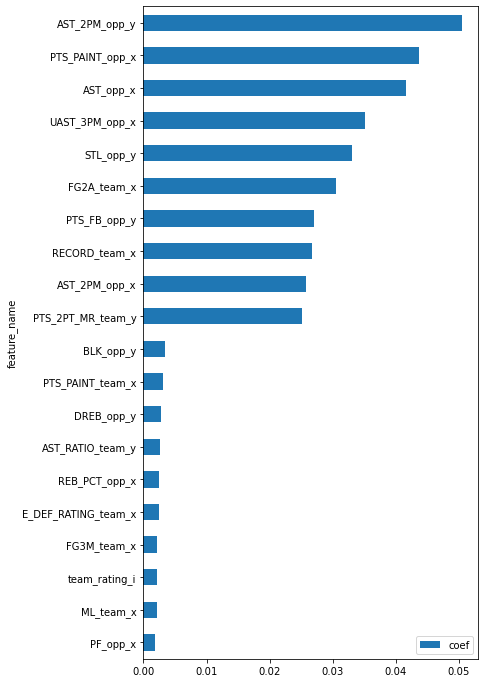

In [66]:
view_model_coefs(best_rf, X_train)

## Stacked Classifier

In [89]:
df_ewm_19_clean

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
15450  2006-07      1610612741               CHI           Chicago Bulls   
15451  2006-07      1610612758               SAC        Sacramento Kings   
15466  2006-07      1610612765               DET         Detroit Pistons   
15467  2006-07      1610612763               MEM       Memphis Grizzlies   
15474  2006-07      1610612750               MIN  Minnesota Timberwolves   
...        ...             ...               ...                     ...   
53905  2021-22      1610612742               DAL        Dallas Mavericks   
53906  2021-22      1610612766               CHA       Charlotte Hornets   
53907  2021-22      1610612744               GSW   Golden State Warriors   
53908  2021-22      1610612758               SAC        Sacramento Kings   
53909  2021-22      1610612740               NOP    New Orleans Pelicans   

        GAME_ID   GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
15450  20600026  2006-11-03  CHI vs. SAC          1          88   
15451  20600026  2006-11-03    SAC @ CHI          0          89   
15466  20600034  2006-11-04  DET vs. MEM          1          95   
15467  20600034  2006-11-04    MEM @ DET          0          86   
15474  20600038  2006-11-04    MIN @ POR          0          86   
...         ...         ...          ...        ...         ...   
53905  22100116  2021-11-03    DAL @ SAS          0         109   
53906  22100117  2021-11-03    CHA @ GSW          0          92   
53907  22100117  2021-11-03  GSW vs. CHA          1         114   
53908  22100118  2021-11-03  SAC vs. NOP          1         112   
53909  22100118  2021-11-03    NOP @ SAC          0          99   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
15450               -1          0   1.416667           -6.0   
15451                1          1   3.000000            6.0   
15466                9          1   1.277778           -8.0   
15467               -9          0   3.800000            8.0   
15474               -2          0   1.666667           -3.5   
...                ...        ...        ...            ...   
53905                1          1   1.769231           -4.0   
53906              -22          0   3.050000            6.0   
53907               22          1   1.408163           -6.0   
53908               13          1   1.425532           -6.0   
53909              -13          0   2.900000            6.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
15450                    0       0.473684    31.473684    63.894737   
15451                    1       0.000000    28.000000    74.000000   
15466                    1       0.526316    28.263158    63.631579   
15467                    0       0.526316    28.105263    74.000000   
15474                    0       1.000000    35.210526    66.684211   
...                    ...            ...          ...          ...   
53905                    0       0.551193    23.230416    46.635157   
53906                    0       0.566996    28.259322    58.130778   
53907                    1       0.807922    24.956095    48.568838   
53908                    1       0.396862    29.135137    55.784863   
53909                    0       0.115200    27.667118    57.201446   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
15450     6.473684    16.684211   18.263158   27.789474    11.947368   
15451     3.000000    15.000000   18.000000   25.000000    22.000000   
15466     5.894737    16.789474   24.894737   31.894737    14.578947   
15467     8.105263    21.526316   25.421053   36.052632    20.894737   
15474     3.473684    10.052632   21.684211   26.842105     9.684211   
...            ...          ...         ...         ...          ...   
53905    12.928962    41.007969   15.236532   21.906531    10.273502   
53906    14.965494    36.355486   15.268071   21.202401    12.795701   
53907    15.478384    41.134886 

In [95]:
df_ewm_19_clean['GAME_DATE'] = pd.to_datetime(df_ewm_19_clean['GAME_DATE'])

### new_version

0
test set 1: 2016-10-27 - 2017-06-12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 322 epochs took 6 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


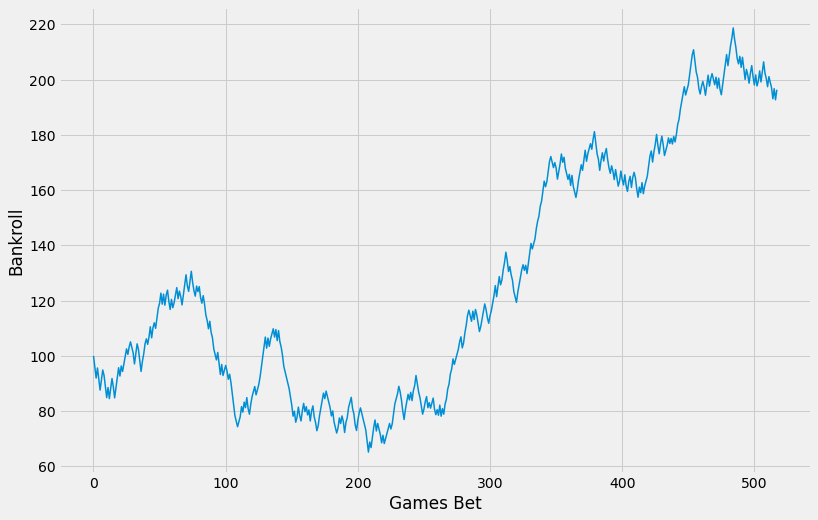

min balance: 65.18181818181836 
max balance: 218.72727272727212 
final balance: 192.36363636363564 
win percentage 54.05 
profit: 92.36363636363626 risk: 1580.0 
ROI: 5.8500000000000005
1
test set 1: 2017-10-20 - 2018-06-08


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 295 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


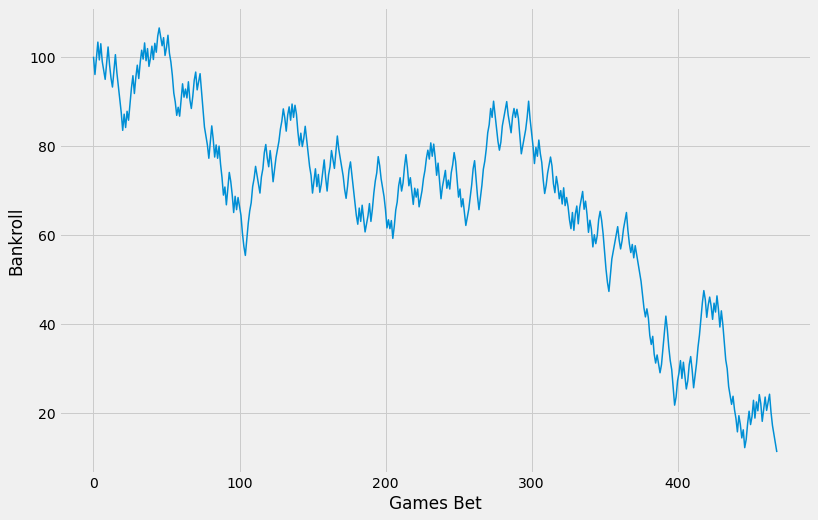

min balance: 11.181818181818347 
max balance: 106.45454545454554 
final balance: 13.000000000000165 
win percentage 49.04 
profit: -87.0 risk: 1389.0 
ROI: -6.260000000000001
2
test set 1: 2018-10-19 - 2019-06-13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 279 epochs took 8 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


min balance: 66.54545454545466 
max balance: 159.54545454545453 
final balance: 121.99999999999982 
win percentage 52.61 
profit: 22.0 risk: 1427.0 
ROI: 1.54
3
test set 1: 2019-10-25 - 2020-10-11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 226 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


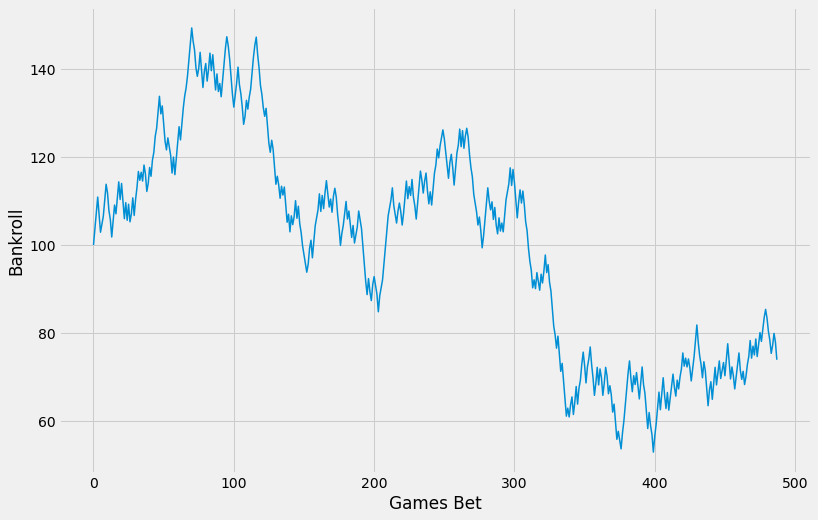

min balance: 52.90909090909087 
max balance: 149.36363636363635 
final balance: 77.54545454545463 
win percentage 51.019999999999996 
profit: -22.454545454545496 risk: 1544.0 
ROI: -1.4500000000000002
4
test set 1: 2020-12-25 - 2021-07-20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 227 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


min balance: 81.36363636363637 
max balance: 166.54545454545388 
final balance: 139.5454545454536 
win percentage 53.83 
profit: 39.545454545454504 risk: 1272.0 
ROI: 3.11
5
test set 1: 2021-10-22 - 2021-11-03


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 211 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


min balance: 63.636363636363654 
max balance: 100.00000000000009 
final balance: 100.00000000000009 
win percentage 51.519999999999996 
profit: -1.4210854715202004e-14 risk: 231.0 
ROI: -0.0

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'OREB_team_x', 'REB_team_x', 'STL_team_x',
       'PLUS_MINUS_team_x', 'ATS_DIFF_team_x', 'RECORD_opp_x', 'FG2A_opp_x',
       'FTA_opp_x', 'TOV_opp_x', 'PIE_opp_x', 'PTS_FB_opp_x', 'UAST_2PM_opp_x',
       'UAST_3PM_opp_x', 'ATS_DIFF_opp_x', 'TEAM_COVERED_opp_x', 'WL_PCT_x',
       '...
       'PTS_OFF_TOV_opp_y', 'AST_2PM_opp_y', 'UAST_2PM_opp_y',
       'ATS_DIFF_opp_y', 'TEAM_COVERED_opp_y', 'WL_PCT_y', 'OREB_PCT_team_y',
       'DREB_PCT_opp_y', 'TOV_PCT_team_y', 'TOV_PCT_opp_y', 'team_elo_pred',
       'team_rating_i', 'opp_rating_i', 'SPREAD_team_x'],
      dtype='object'))])),
                ('scaler', Standard

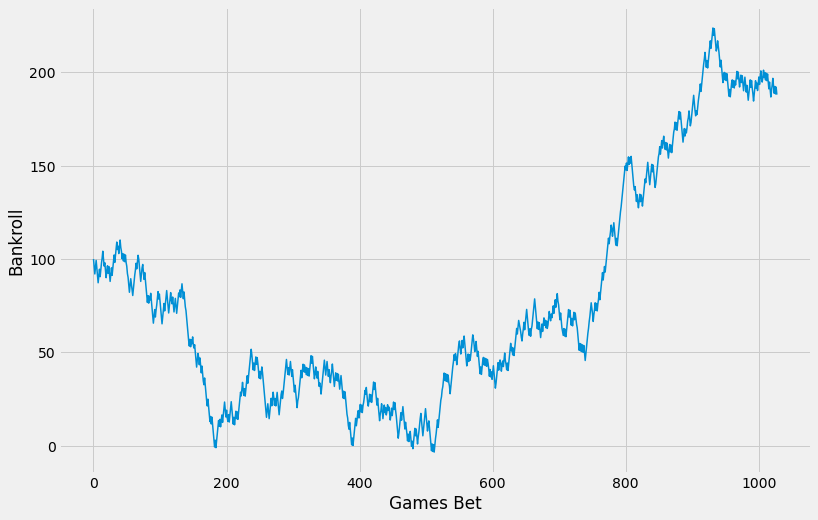

min balance: -3.4545454545453813 
max balance: 223.8181818181811 
final balance: 186.09090909090793 
win percentage 53.11 
profit: 86.09090909090901 risk: 3860.0 
ROI: 2.23
1
test set 1: 2017-10-20 - 2018-06-08


min balance: 3.090909090909431 
max balance: 138.0000000000003 
final balance: 4.909090909091249 
win percentage 51.04 
profit: -95.09090909090924 risk: 3814.0 
ROI: -2.4899999999999998
2
test set 1: 2018-10-19 - 2019-06-13


min balance: 62.27272727272742 
max balance: 201.0909090909085 
final balance: 130.6363636363624 
win percentage 52.910000000000004 
profit: 30.636363636363512 risk: 3778.0 
ROI: 0.8099999999999999
3
test set 1: 2019-10-25 - 2020-10-11


min balance: -109.63636363636402 
max balance: 165.99999999999943 
final balance: -103.45454545454578 
win percentage 48.8 
profit: -203.4545454545455 risk: 3300.0 
ROI: -6.17
4
test set 1: 2020-12-25 - 2021-07-20


min balance: -51.090909090909896 
max balance: 188.181818181818 
final balance: -24.00000000000085 
win percentage 50.17 
profit: -124.00000000000023 risk: 3316.0 
ROI: -3.74
5
test set 1: 2021-10-22 - 2021-11-03


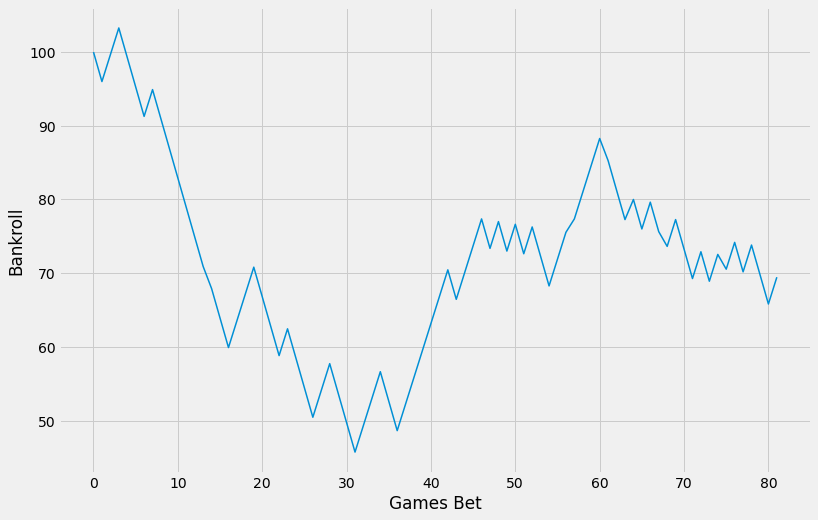

min balance: 45.72727272727273 
max balance: 103.27272727272728 
final balance: 72.18181818181824 
win percentage 47.56 
profit: -27.81818181818184 risk: 318.0 
ROI: -8.75

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FG3A_team_x', 'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x',
       'REB_team_x',
       ...
       'AST_RATIO_team_y', 'AST_RATIO_opp_y', 'TOV_PCT_team_y',
       'TOV_PCT_opp_y', 'team_elo_pred', 'team_rating_i', 'opp_rating_i',
       'elo_MOV_pred', 'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=142))])),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.03293403903706543, random_state=23))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0

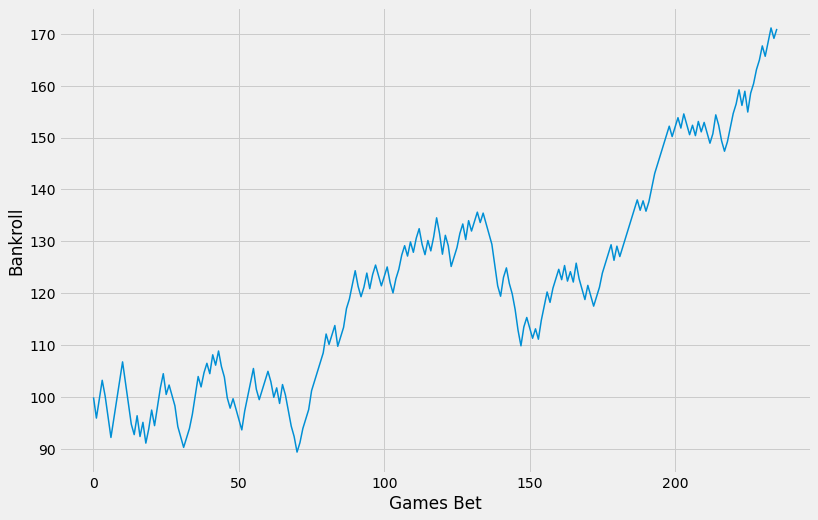

min balance: 89.45454545454552 
max balance: 171.09090909090878 
final balance: 168.9090909090906 
win percentage 57.199999999999996 
profit: 68.90909090909088 risk: 626.0 
ROI: 11.01
1
test set 1: 2017-10-20 - 2018-06-08


min balance: 40.09090909090913 
max balance: 103.63636363636364 
final balance: 61.18181818181822 
win percentage 50.0 
profit: -38.81818181818187 risk: 854.0 
ROI: -4.55
2
test set 1: 2018-10-19 - 2019-06-13


min balance: 92.0 
max balance: 155.18181818181807 
final balance: 137.0909090909089 
win percentage 54.58 
profit: 37.090909090909065 risk: 780.0 
ROI: 4.760000000000001
3
test set 1: 2019-10-25 - 2020-10-11


min balance: 71.36363636363636 
max balance: 118.90909090909098 
final balance: 84.63636363636363 
win percentage 50.42 
profit: -15.363636363636374 risk: 632.0 
ROI: -2.4299999999999997
4
test set 1: 2020-12-25 - 2021-07-20


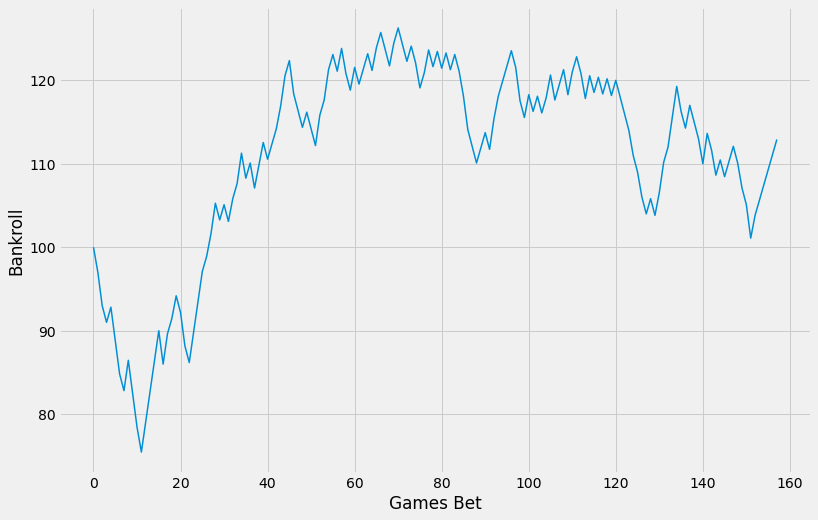

min balance: 75.45454545454545 
max balance: 126.27272727272731 
final balance: 114.72727272727269 
win percentage 52.53 
profit: 14.72727272727272 risk: 411.0 
ROI: 3.58
5
test set 1: 2021-10-22 - 2021-11-03


min balance: 90.54545454545455 
max balance: 107.27272727272728 
final balance: 100.72727272727273 
win percentage 53.33 
profit: 0.7272727272727266 risk: 89.0 
ROI: 0.8200000000000001

 Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x', 'REB_team_x',
       'AST_team_x',
       ...
       'AVG_SPREAD_y', 'REST_y', 'TS_PCT_team_y', 'EFG_PCT_opp_y',
       'AST_RATIO_team_y', 'team_elo_pred', 'opp_rating_i', 'elo_MOV_pred',
       'SPREAD_team_x', 'ML_team_x'],
      dtype='object', length=103))])),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.901283698122614, loss='modified_huber',
                               random_state=23))])
            season  best_threshold  win_pcts  num_games_b

min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0
1
test set 1: 2017-10-20 - 2018-06-08


min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0
2
test set 1: 2018-10-19 - 2019-06-13


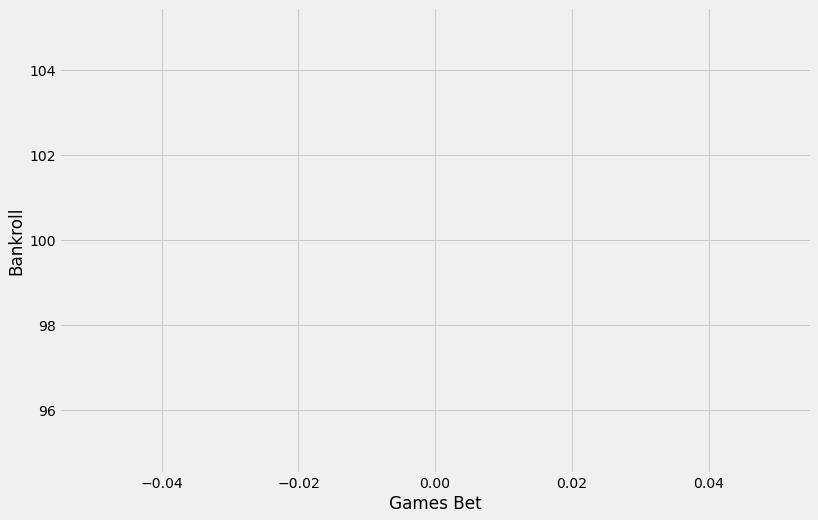

min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0
3
test set 1: 2019-10-25 - 2020-10-11


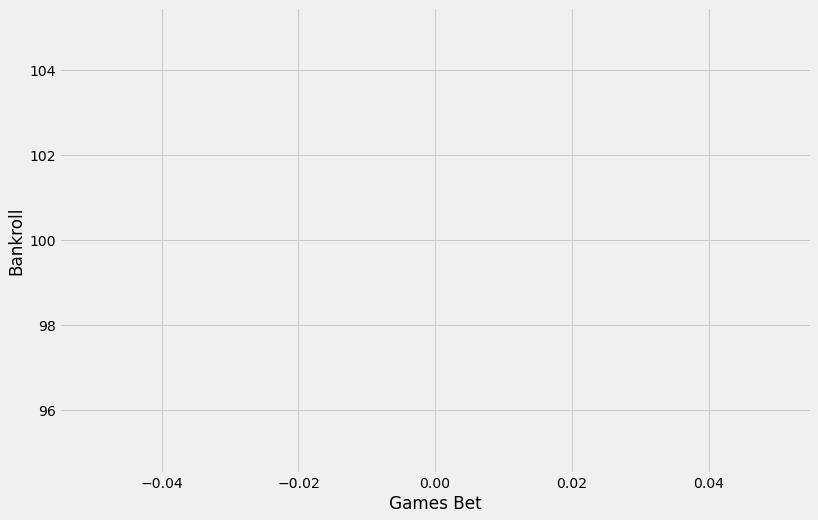

min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0
4
test set 1: 2020-12-25 - 2021-07-20


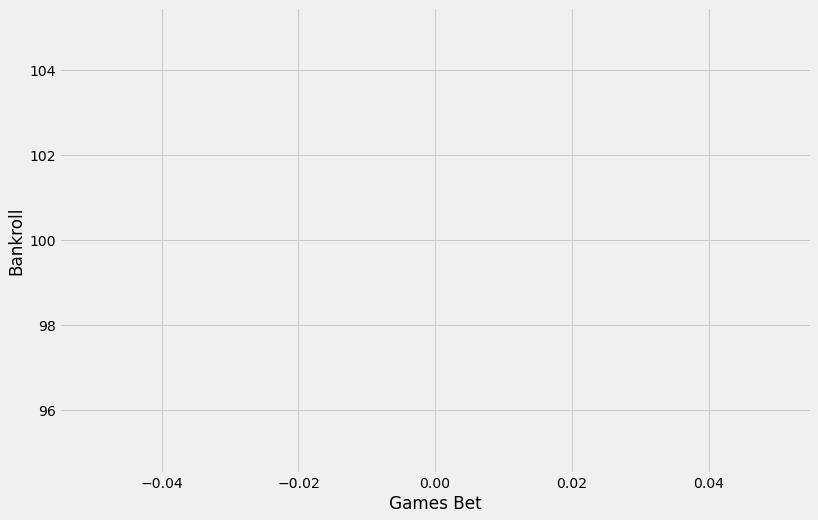

min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0
5
test set 1: 2021-10-22 - 2021-11-03


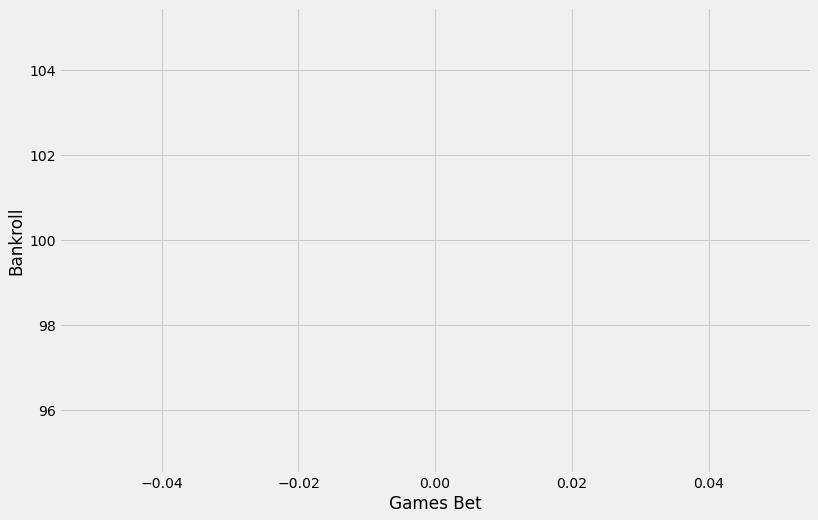

min balance: 100.0 
max balance: 100.0 
final balance: 100.0 
win percentage nan 
profit: 0.0 risk: 1.0 
ROI: 0.0

 RandomForestClassifier(max_depth=18, min_samples_leaf=0.1671979407654873,
                       min_samples_split=0.22415776502857174, random_state=23)
            season  best_threshold  win_pcts  num_games_bet  rois  profits
0  (2016, -, 2017)            0.53       NaN              1   0.0      0.0
1  (2017, -, 2018)            0.53       NaN              1   0.0      0.0
2  (2018, -, 2019)            0.53       NaN              1   0.0      0.0
3  (2019, -, 2020)            0.53       NaN              1   0.0      0.0
4  (2020, -, 2021)            0.53       NaN              1   0.0      0.0
5  (2021, -, 2021)            0.53       NaN              1   0.0      0.0
0
test set 1: 2016-10-27 - 2017-06-12


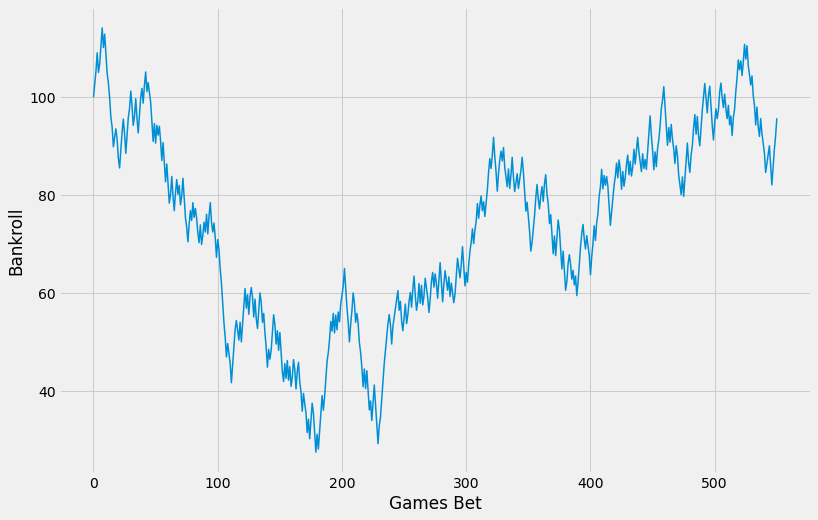

min balance: 27.454545454545475 
max balance: 114.1818181818182 
final balance: 93.72727272727298 
win percentage 51.910000000000004 
profit: -6.272727272727366 risk: 1755.0 
ROI: -0.36
1
test set 1: 2017-10-20 - 2018-06-08


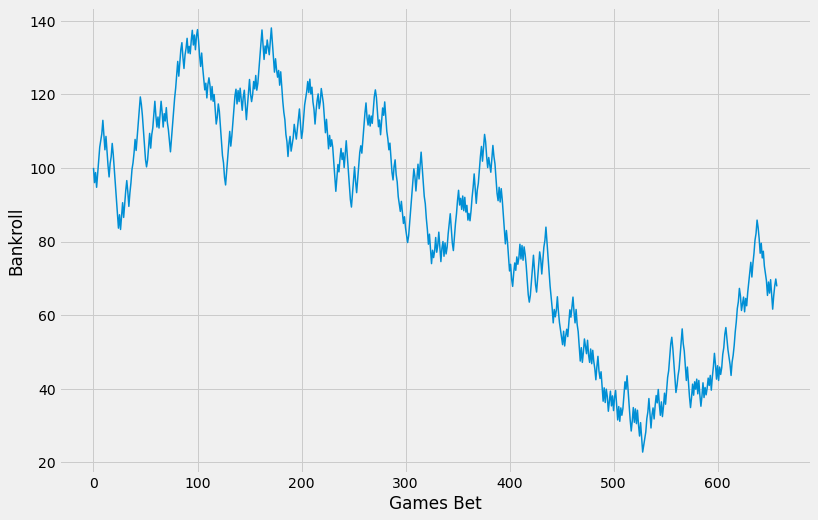

min balance: 22.818181818182016 
max balance: 138.0 
final balance: 69.63636363636381 
win percentage 51.06 
profit: -30.363636363636488 risk: 2201.0 
ROI: -1.38
2
test set 1: 2018-10-19 - 2019-06-13


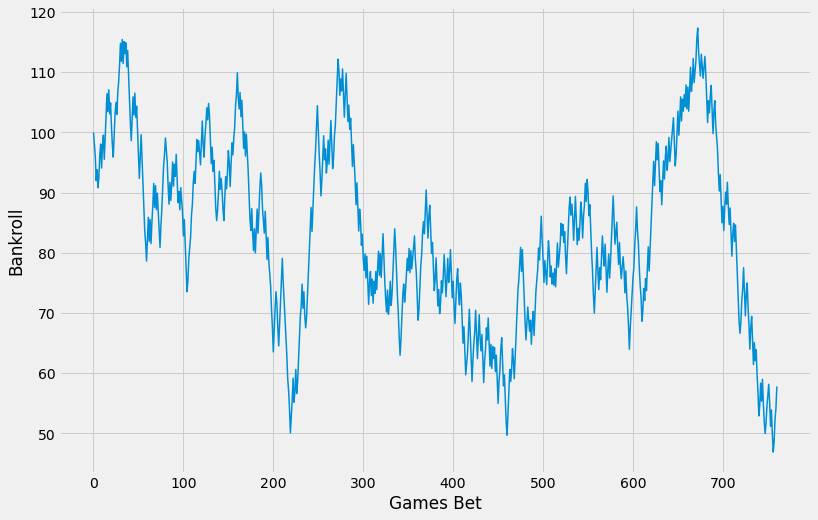

min balance: 46.90909090909157 
max balance: 117.36363636363699 
final balance: 55.818181818182474 
win percentage 51.910000000000004 
profit: -44.181818181818244 risk: 2526.0 
ROI: -1.7500000000000002
3
test set 1: 2019-10-25 - 2020-10-11


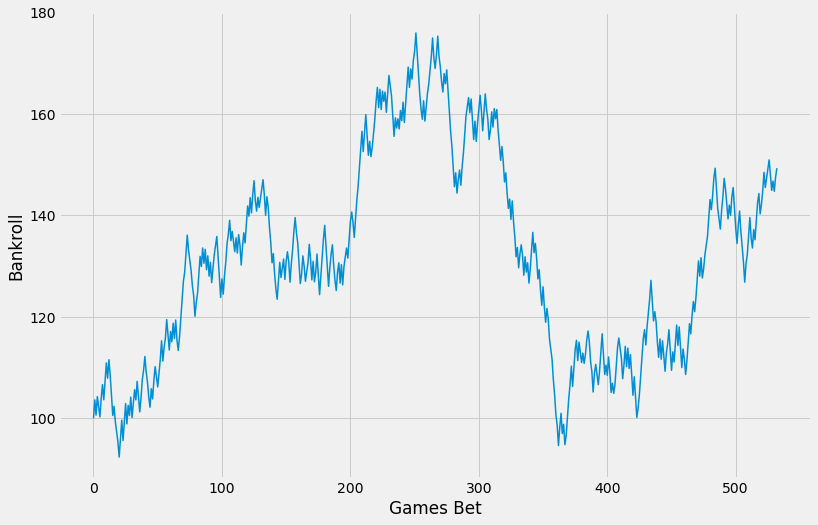

min balance: 92.36363636363639 
max balance: 175.9090909090903 
final balance: 151.09090909090799 
win percentage 53.1 
profit: 51.09090909090901 risk: 1711.0 
ROI: 2.9899999999999998
4
test set 1: 2020-12-25 - 2021-07-20


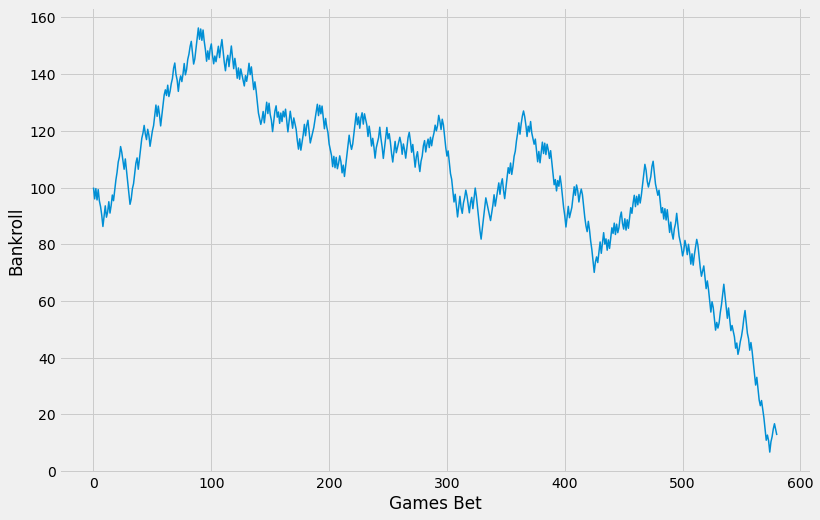

min balance: 6.72727272727275 
max balance: 156.27272727272717 
final balance: 14.545454545454566 
win percentage 50.260000000000005 
profit: -85.4545454545455 risk: 1922.0 
ROI: -4.45
5
test set 1: 2021-10-22 - 2021-11-03


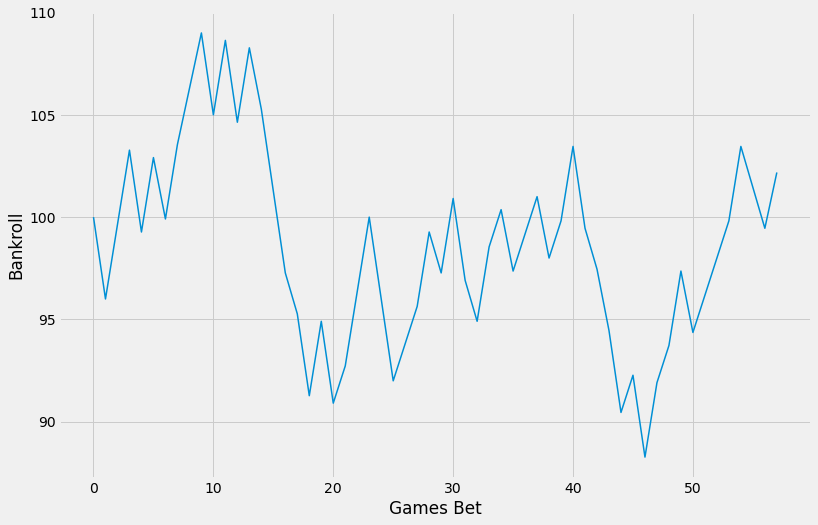

min balance: 88.2727272727273 
max balance: 109.00000000000003 
final balance: 100.1818181818182 
win percentage 53.449999999999996 
profit: 0.18181818181817277 risk: 185.0 
ROI: 0.1

 LGBMClassifier(colsample_bytree=0.8407838610664131,
               learning_rate=0.040022877441725196, max_depth=6,
               min_child_weight=0.4495756229471384, num_leaves=404,
               random_state=23, reg_alpha=2.4943648274534036,
               reg_lambda=4.579191385748681, subsample=0.641171893818833)
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.519056            551 -0.003574   
1  (2017, -, 2018)            0.53  0.510638            658 -0.013795   
2  (2018, -, 2019)            0.53  0.519054            761 -0.017491   
3  (2019, -, 2020)            0.53  0.530957            533  0.029860   
4  (2020, -, 2021)            0.53  0.502582            581 -0.044461   
5  (2021, -, 2021)            0.53  0.534483             

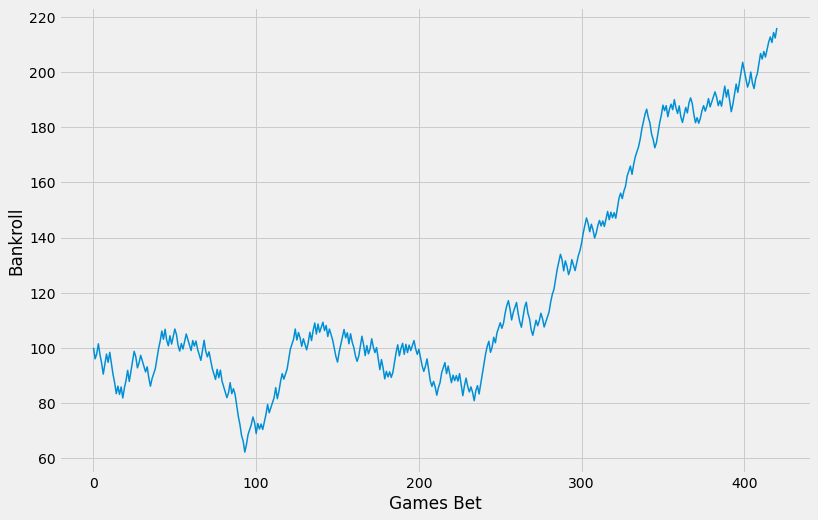

min balance: 62.18181818181829 
max balance: 215.99999999999957 
final balance: 212.99999999999957 
win percentage 55.82 
profit: 113.0 risk: 1231.0 
ROI: 9.180000000000001
1
test set 1: 2017-10-20 - 2018-06-08


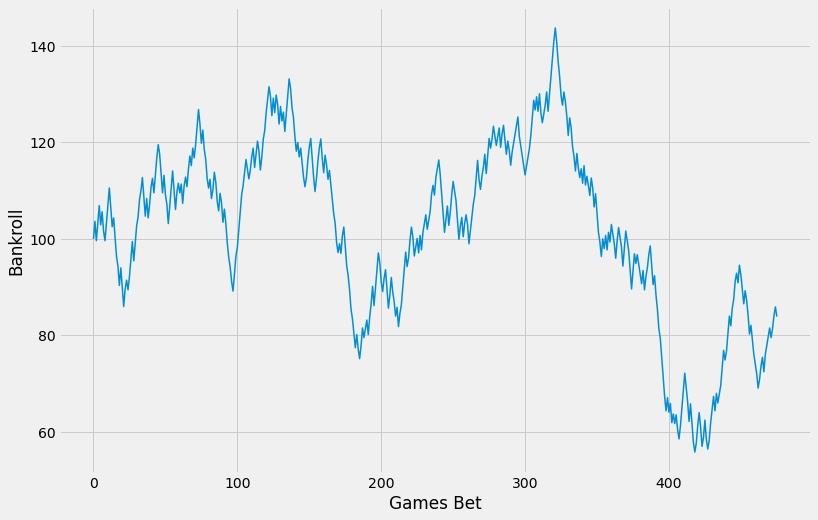

min balance: 55.81818181818198 
max balance: 143.72727272727283 
final balance: 81.90909090909108 
win percentage 51.05 
profit: -18.090909090909122 risk: 1448.0 
ROI: -1.25
2
test set 1: 2018-10-19 - 2019-06-13


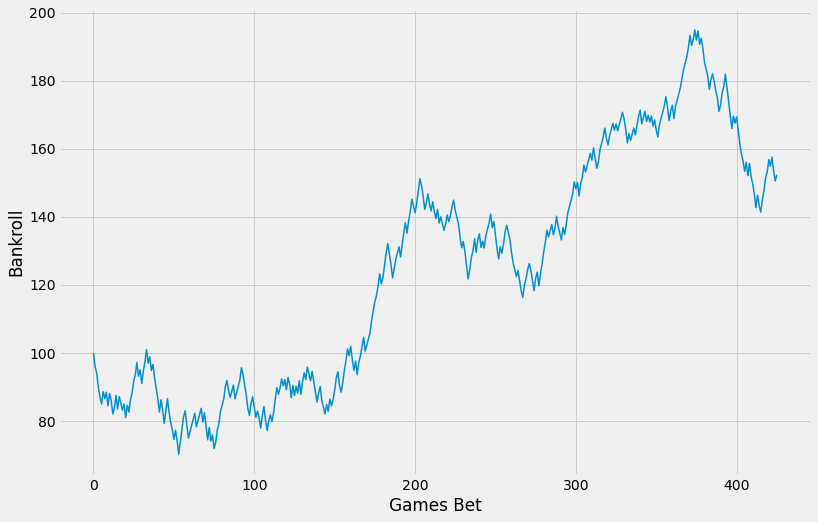

min balance: 70.2727272727273 
max balance: 194.9090909090903 
final balance: 150.3636363636356 
win percentage 55.400000000000006 
profit: 50.36363636363626 risk: 1244.0 
ROI: 4.05
3
test set 1: 2019-10-25 - 2020-10-11


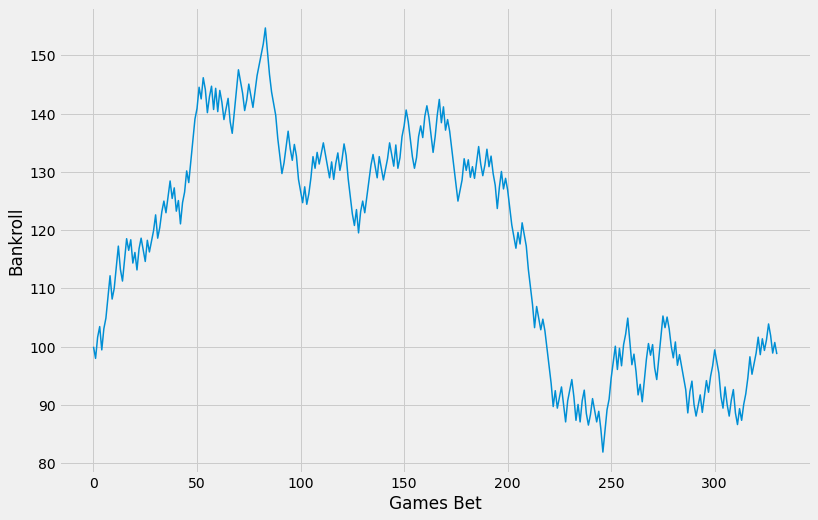

min balance: 81.90909090909045 
max balance: 154.72727272727255 
final balance: 100.54545454545415 
win percentage 51.35999999999999 
profit: 0.5454545454545041 risk: 933.0 
ROI: 0.06
4
test set 1: 2020-12-25 - 2021-07-20


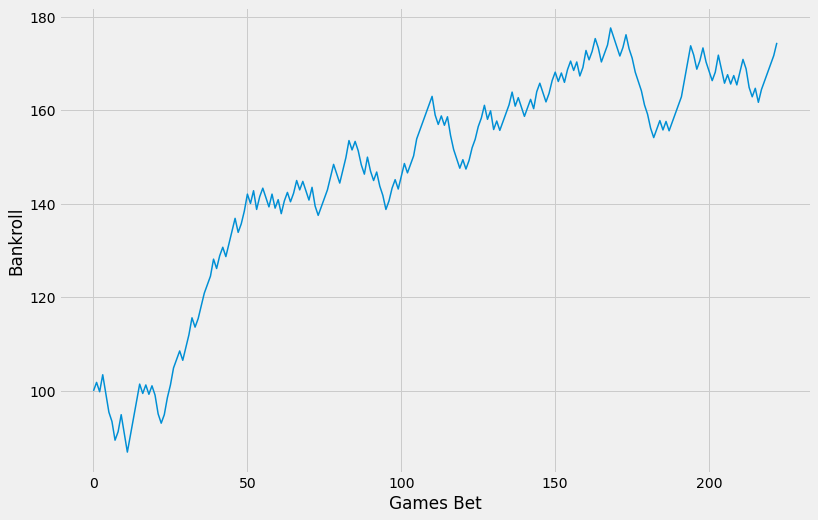

min balance: 86.9090909090909 
max balance: 177.63636363636314 
final balance: 177.1818181818175 
win percentage 58.3 
profit: 77.18181818181813 risk: 570.0 
ROI: 13.54
5
test set 1: 2021-10-22 - 2021-11-03


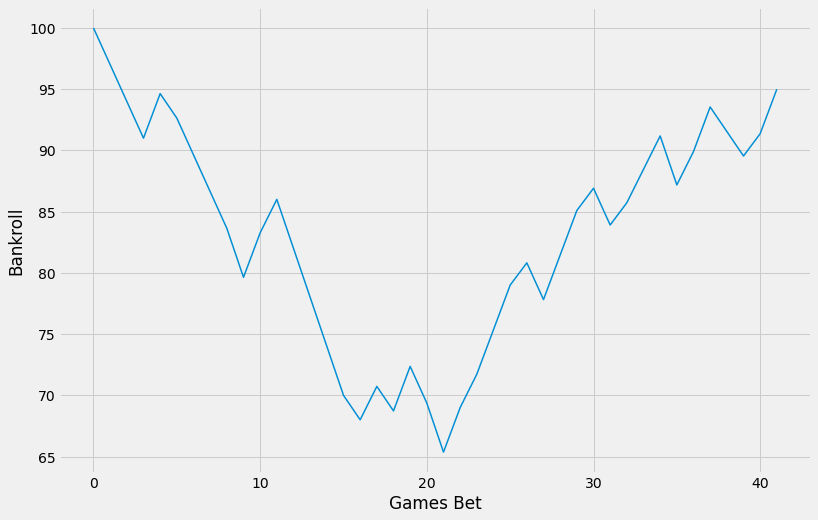

min balance: 65.36363636363639 
max balance: 97.0 
final balance: 96.81818181818187 
win percentage 50.0 
profit: -3.181818181818187 risk: 133.0 
ROI: -2.39

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('selector',
                                                                                  'passthrough',
                                                                                  Index(['RECORD_team_x', 'OREB_team_x', 'REB_team_x', 'STL_team_x',
       'PLUS_MINUS_team_x', 'ATS_DIFF_team_x', 'RECORD_opp_x', 'FG2A_opp_x',
       'FTA_opp_x', 'TOV_opp_x', 'PIE_opp_x', 'PTS_FB_opp_x', 'UAST_2PM_opp_x',
       'UAST_3PM_opp_x', 'ATS_DIFF_op...
                                               subsample=0.641171893818833)),
                               ('rf',
                                RandomForestClassifier(max_depth=18,
                  

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.558195            421  0.091795   
1  (2017, -, 2018)            0.53  0.510504            476 -0.012494   
2  (2018, -, 2019)            0.53  0.553991            426  0.040485   
3  (2019, -, 2020)            0.53  0.513595            331  0.000585   
4  (2020, -, 2021)            0.53  0.582960            223  0.135407   
5  (2021, -, 2021)            0.53  0.500000             42 -0.023923   

      profits  
0  113.000000  
1  -18.090909  
2   50.363636  
3    0.545455  
4   77.181818  
5   -3.181818

In [102]:
estimators = [('log', best_lr), ('sgd', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_sgd_hinge, best_sgd_huber, best_rf, best_lgbc, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_clean, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_clean.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_clean.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_clean.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_clean.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_clean, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

stacked clf train_acc: 0.5640048250904705
stacked clf test_acc: 0.512938849513763
0
test set 1: 2016-10-27 - 2017-06-12


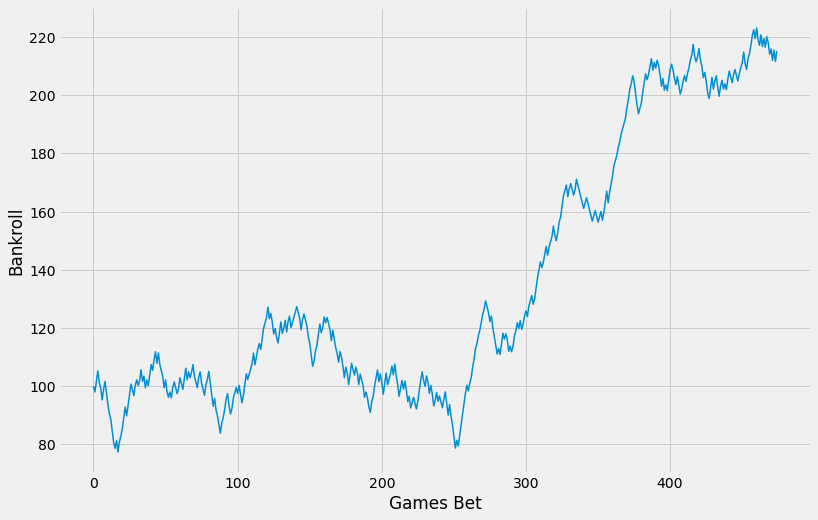

min balance: 77.36363636363639 
max balance: 223.0909090909086 
final balance: 211.18181818181765 
win percentage 55.78999999999999 
profit: 111.18181818181813 risk: 1397.0 
ROI: 7.960000000000001
1
test set 1: 2017-10-20 - 2018-06-08


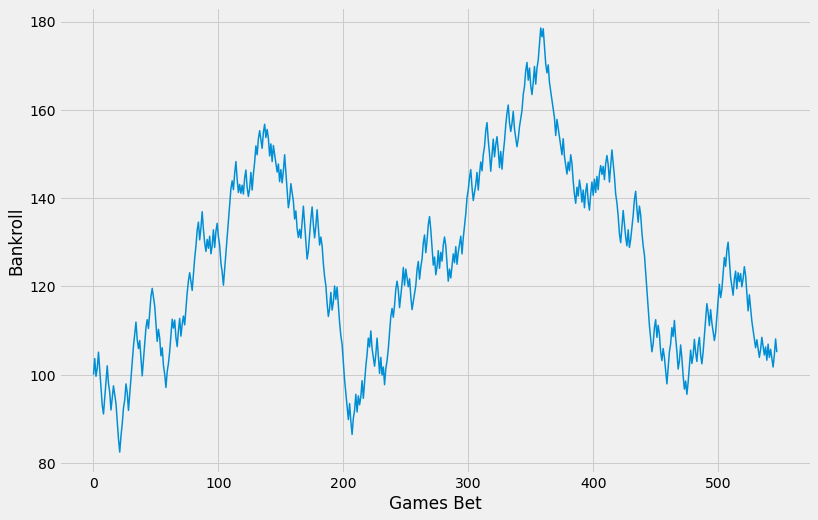

min balance: 82.45454545454548 
max balance: 178.54545454545396 
final balance: 102.0909090909083 
win percentage 51.28 
profit: 2.0909090909090082 risk: 1697.0 
ROI: 0.12
2
test set 1: 2018-10-19 - 2019-06-13


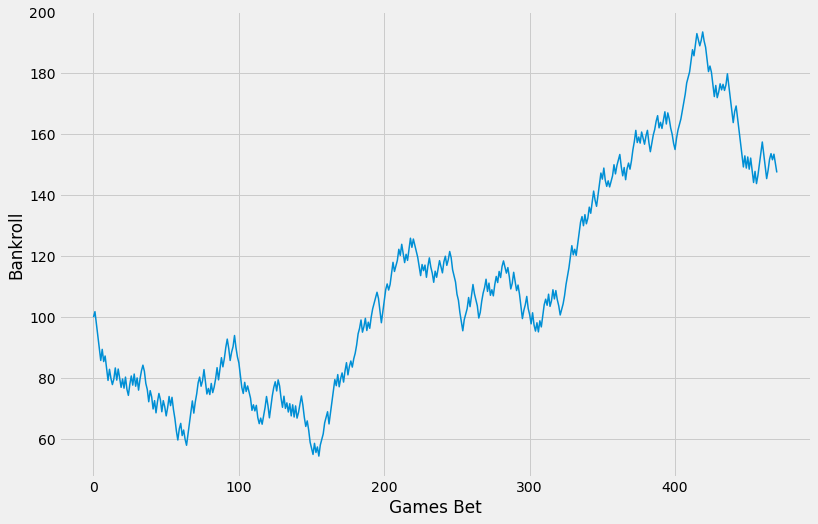

min balance: 54.45454545454561 
max balance: 193.54545454545445 
final balance: 149.272727272727 
win percentage 53.72 
profit: 49.27272727272725 risk: 1457.0 
ROI: 3.38
3
test set 1: 2019-10-25 - 2020-10-11


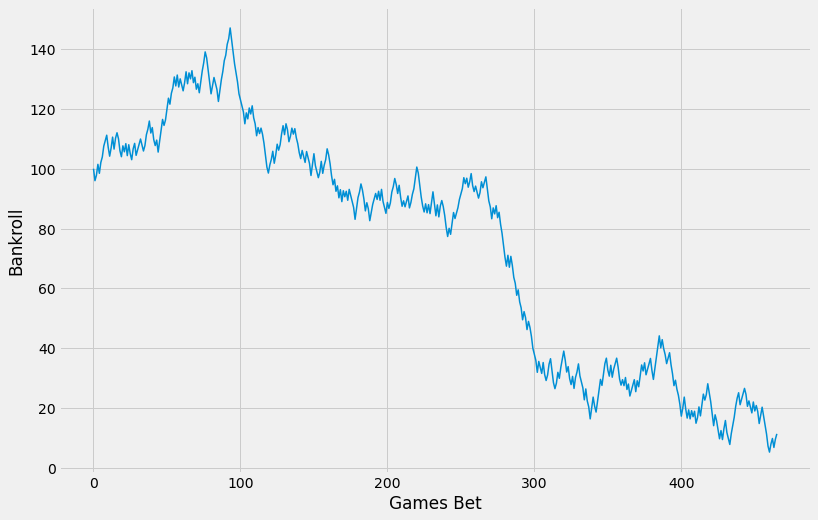

min balance: 5.363636363636289 
max balance: 146.99999999999986 
final balance: 14.181818181818105 
win percentage 48.93 
profit: -85.81818181818187 risk: 1405.0 
ROI: -6.11
4
test set 1: 2020-12-25 - 2021-07-20


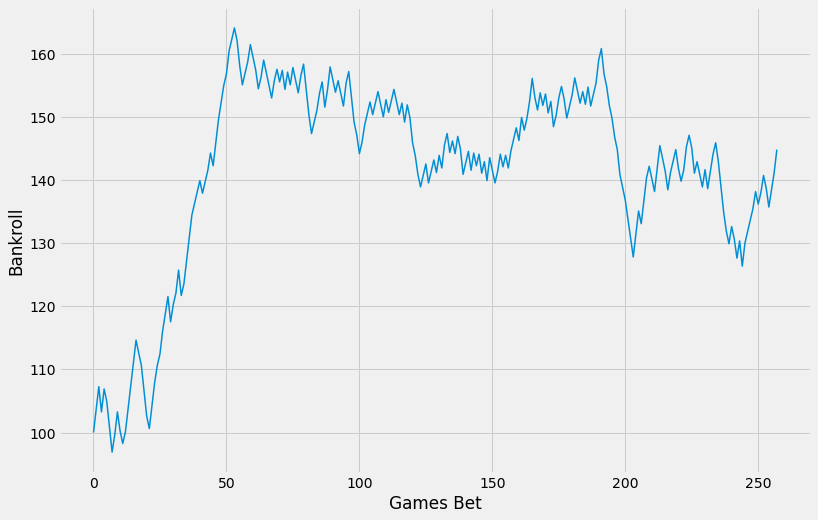

min balance: 96.90909090909092 
max balance: 164.09090909090904 
final balance: 147.5454545454538 
win percentage 54.65 
profit: 47.545454545454504 risk: 697.0 
ROI: 6.819999999999999
5
test set 1: 2021-10-22 - 2021-10-26


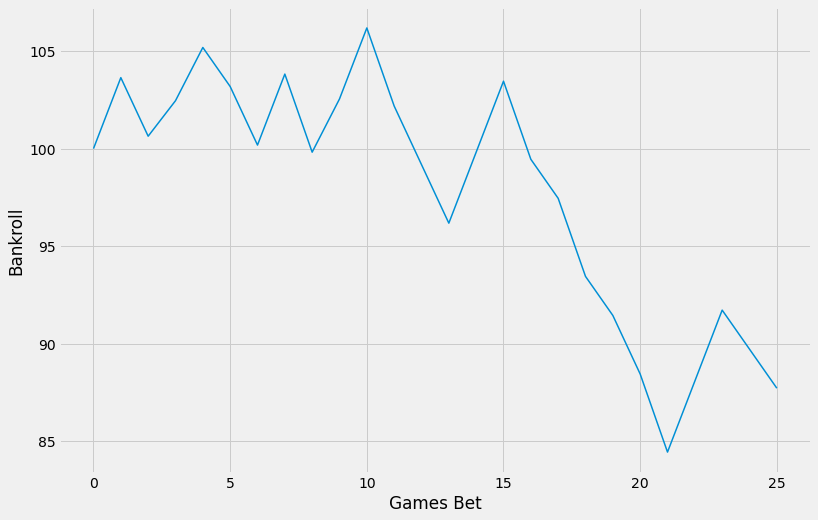

min balance: 83.72727272727276 
max balance: 106.1818181818182 
final balance: 83.72727272727276 
win percentage 38.46 
profit: -16.272727272727273 risk: 85.0 
ROI: -19.139999999999997

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=100000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                    

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.557895            475  0.079586   
1  (2017, -, 2018)            0.53  0.512774            548  0.001232   
2  (2018, -, 2019)            0.53  0.537155            471  0.033818   
3  (2019, -, 2020)            0.53  0.489270            466 -0.061081   
4  (2020, -, 2021)            0.53  0.546512            258  0.068214   
5  (2021, -, 2021)            0.53  0.384615             26 -0.191444   

      profits  
0  111.181818  
1    2.090909  
2   49.272727  
3  -85.818182  
4   47.545455  
5  -16.272727

In [414]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


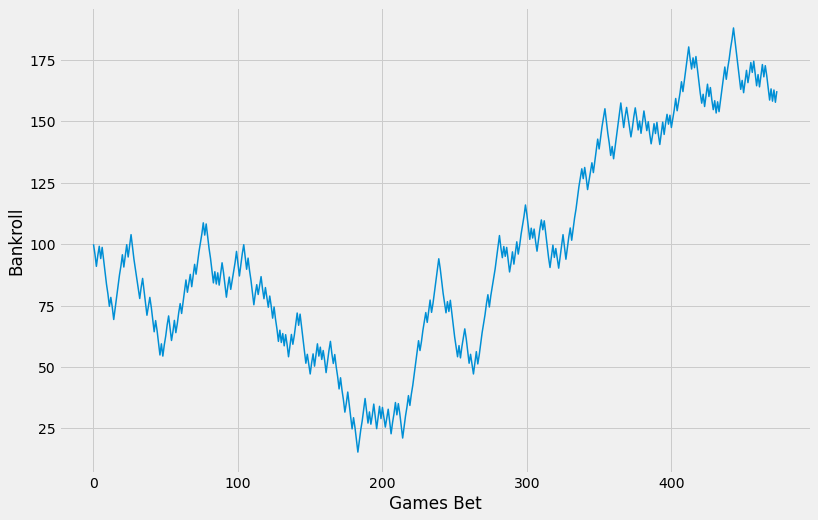

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


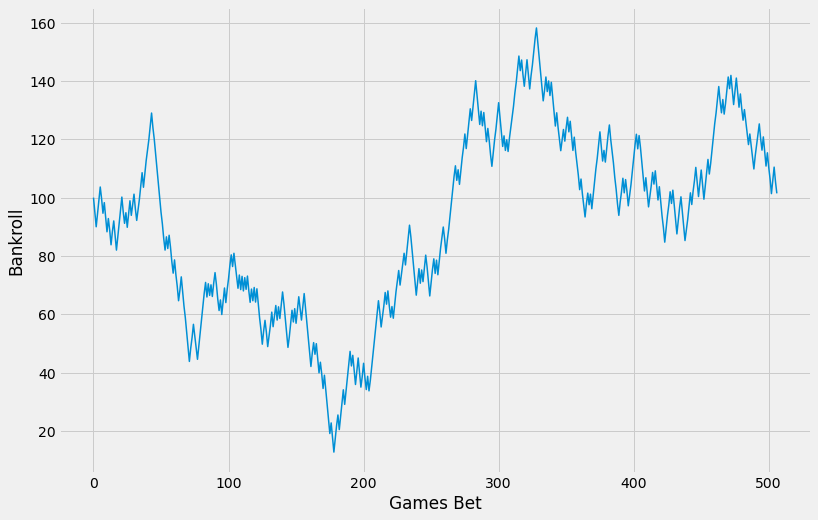

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


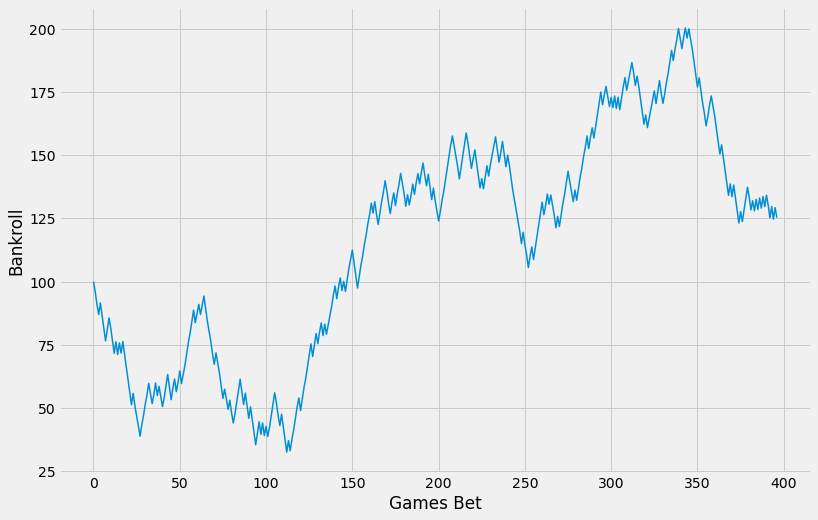

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


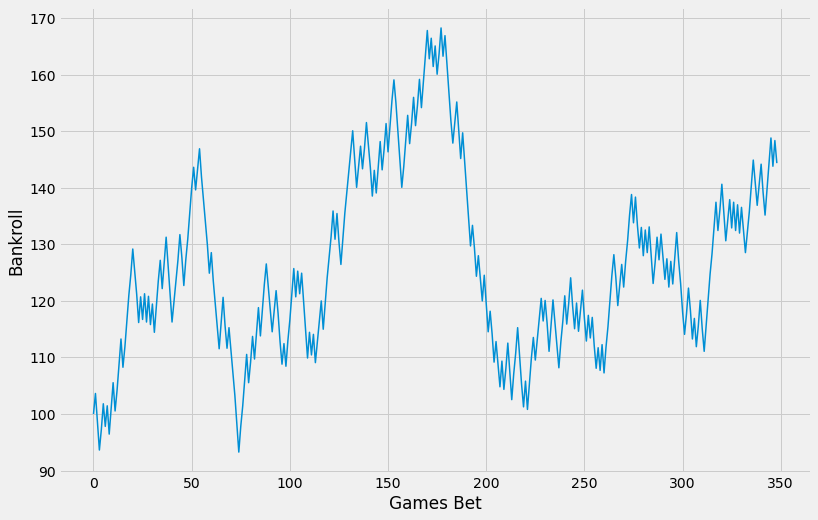

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


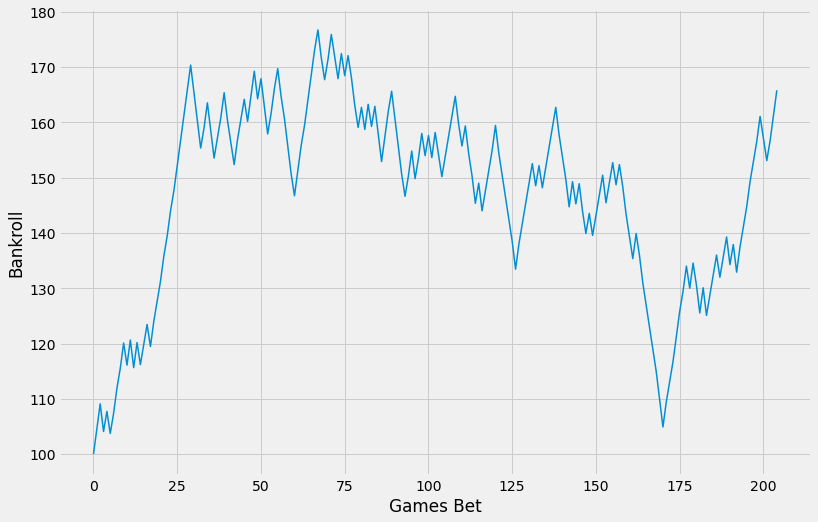

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


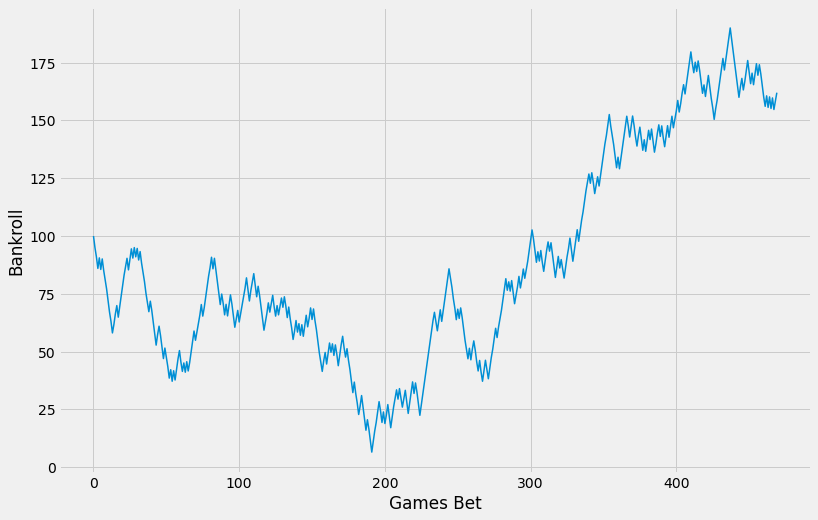

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


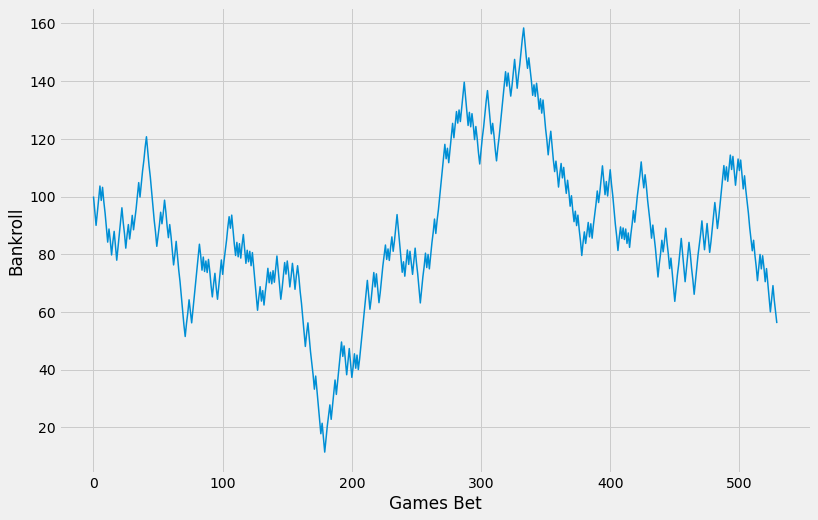

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


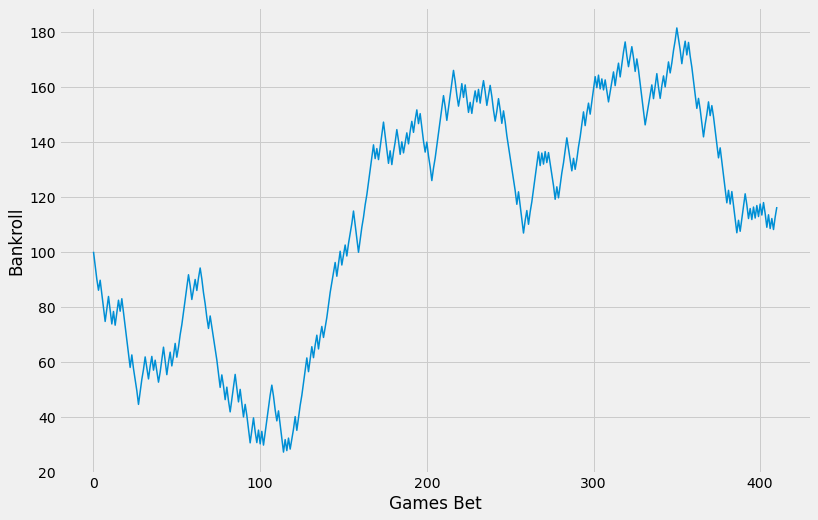

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


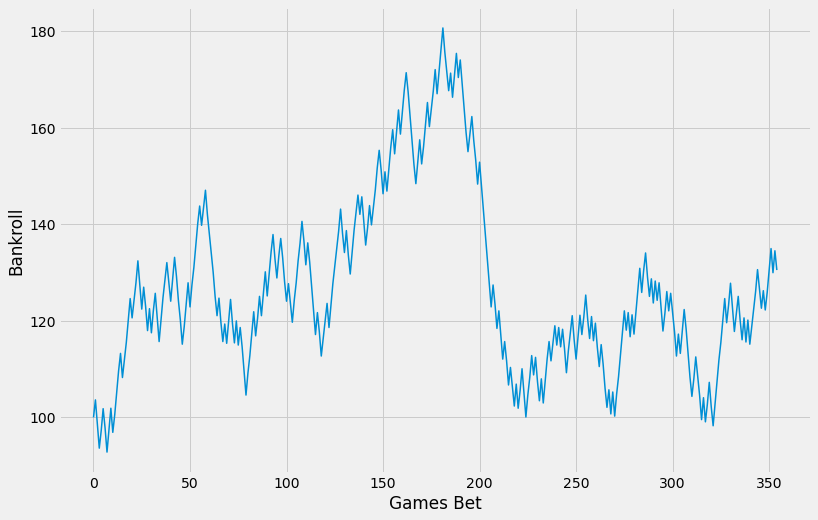

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


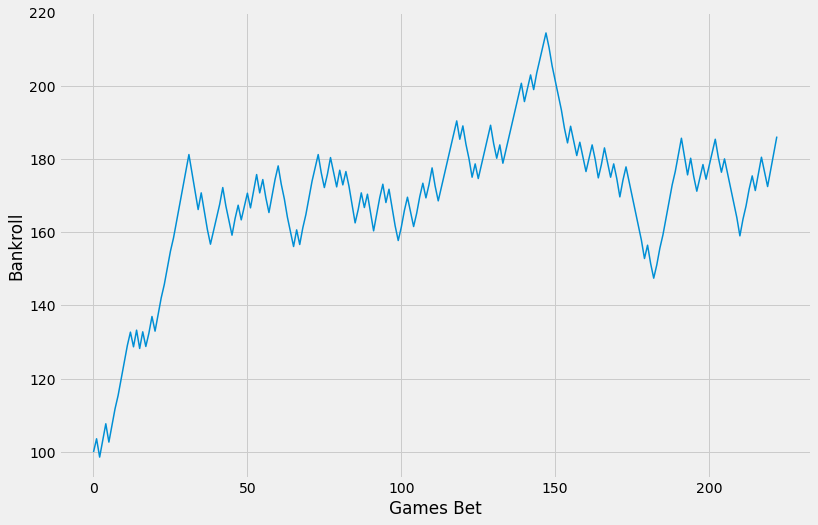

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


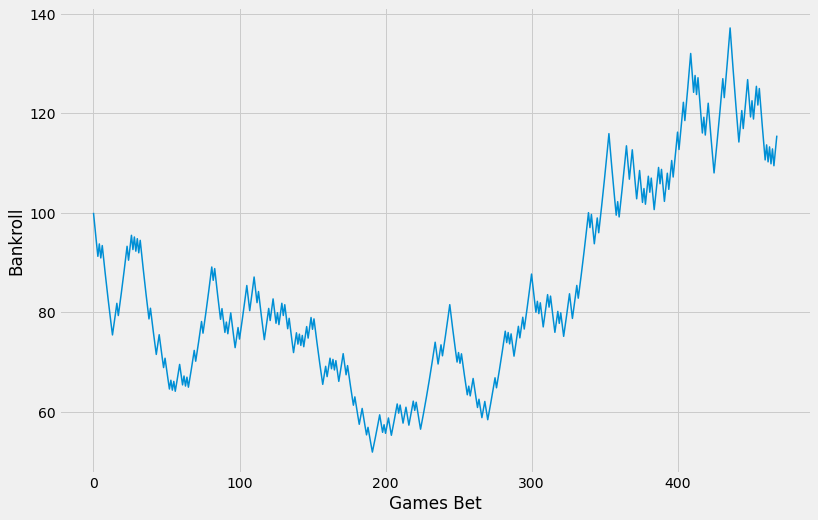

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


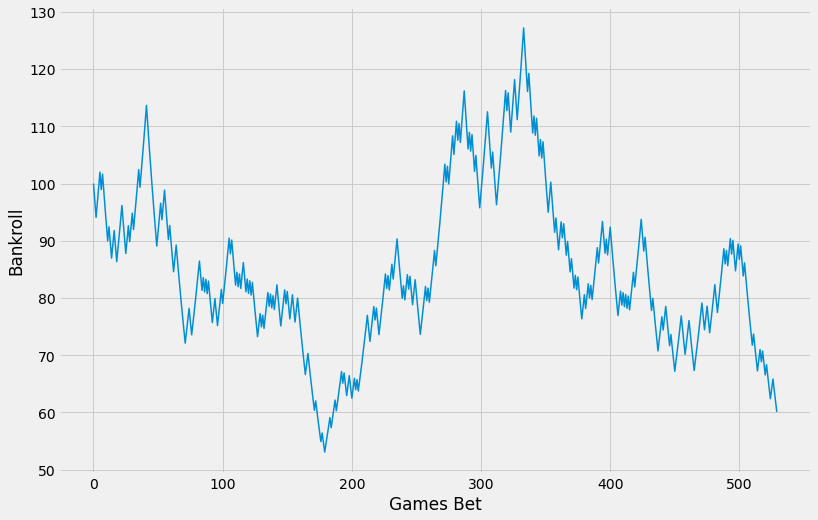

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


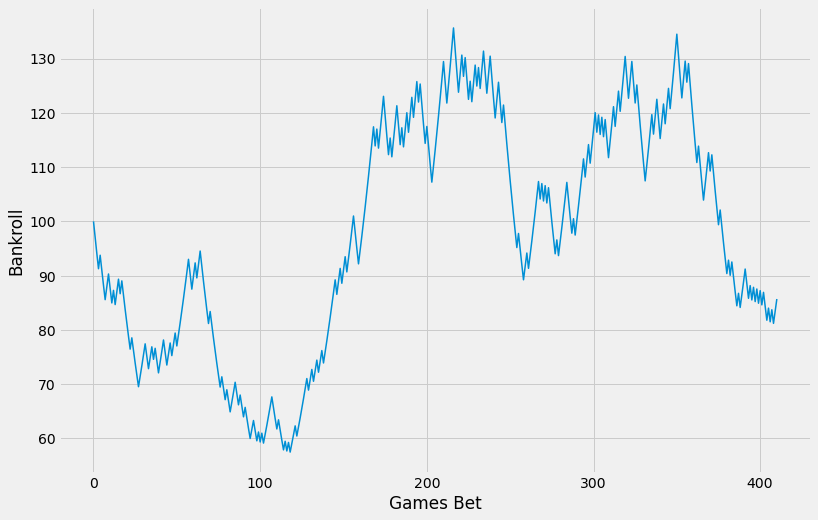

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


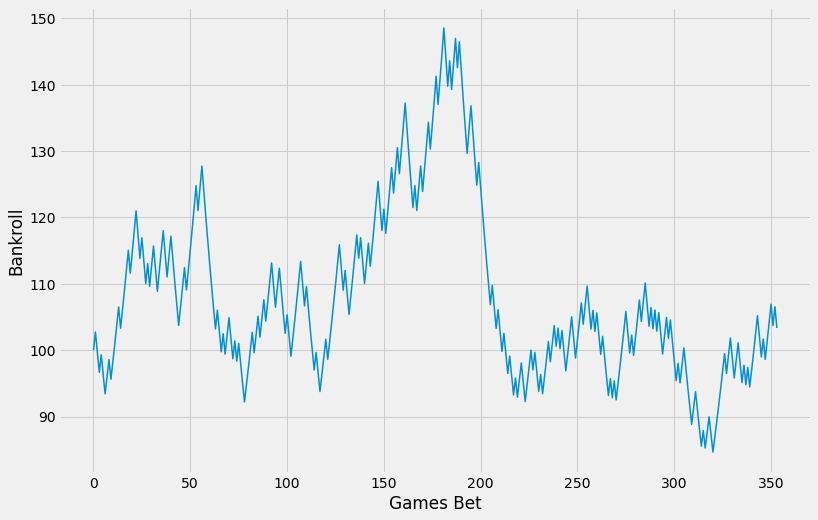

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


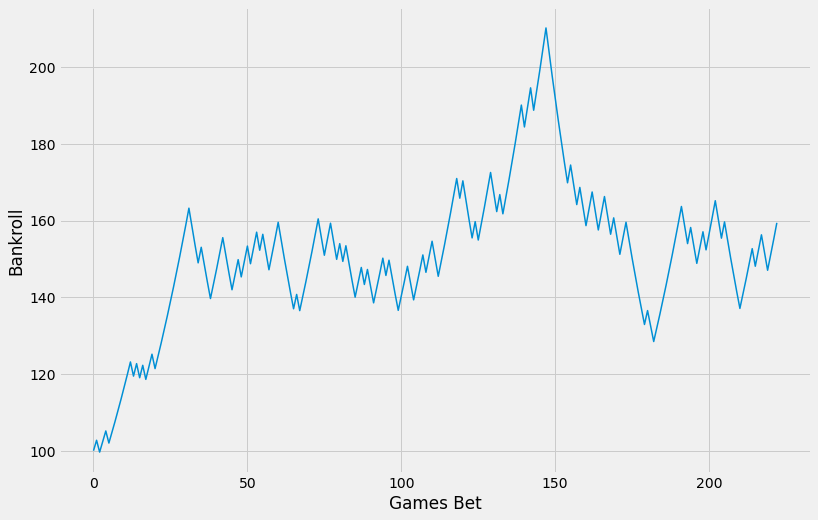

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


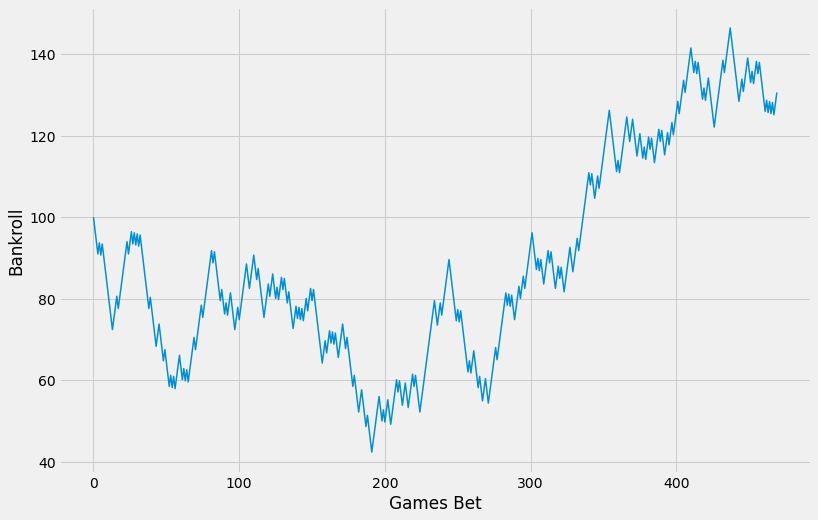

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


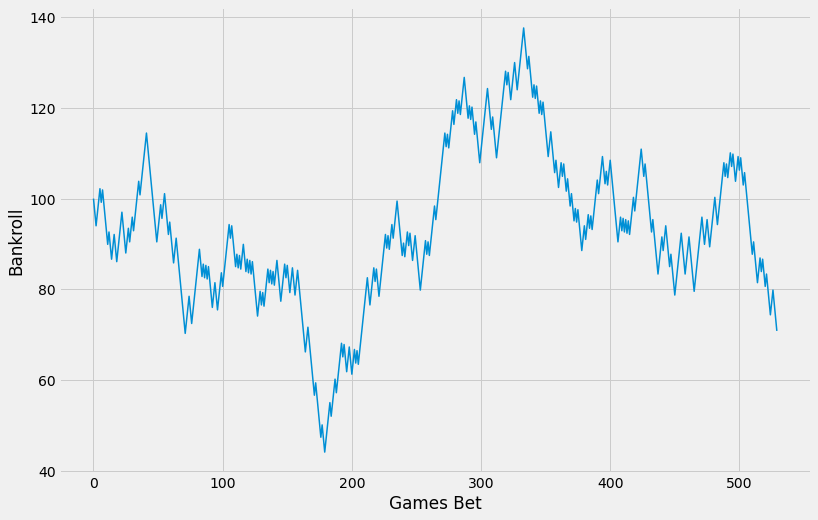

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


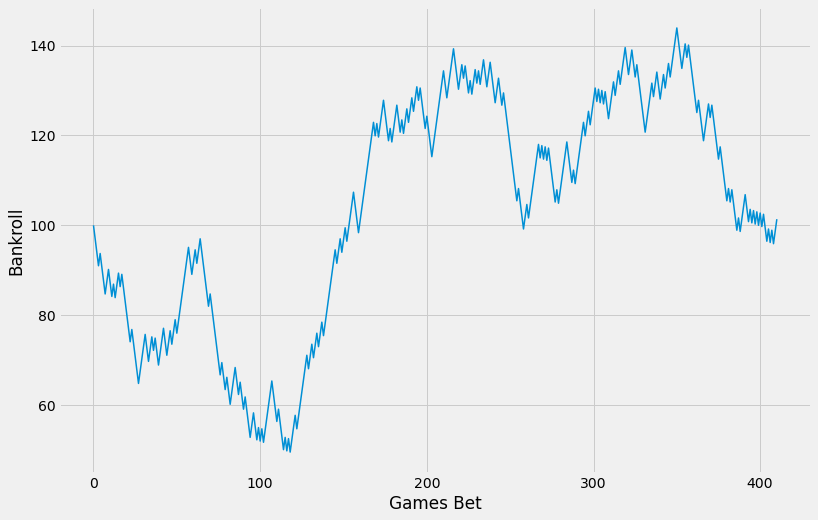

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


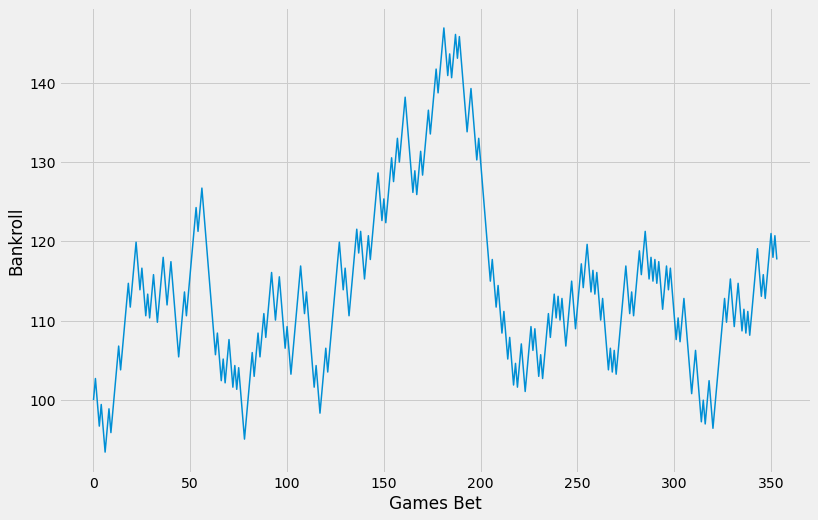

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


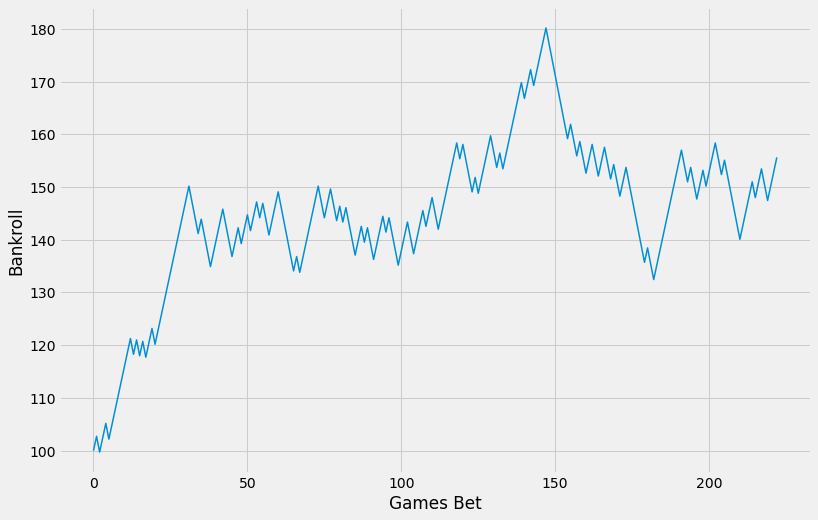

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [211]:
from src.data.update_data import update_all_data


connection = sqlite3.connect('../data/nba.db')
update_all_data(connection, season=2021)
connection.close()



updating basic team boxscores
updating advanced team boxscores
num_games_updated: 0
All team advanced boxscores up to date in season 2021-22
updating scoring boxscores
num_games_updated: 0
All team advanced boxscores up to date in season 2021-22
updating moneyline data
moneyline table is up to date
updating spreads data
Updating spreads for 0 days
spreads table is up to date


In [212]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [104]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_current_season_team_data(connection, 2021)
connection.close()
df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
53676  2021-22  1610612744               GSW   Golden State Warriors   
53677  2021-22  1610612747               LAL      Los Angeles Lakers   
53678  2021-22  1610612751               BKN           Brooklyn Nets   
53679  2021-22  1610612749               MIL         Milwaukee Bucks   
53680  2021-22  1610612766               CHA       Charlotte Hornets   
...        ...         ...               ...                     ...   
53985  2021-22  1610612755               PHI      Philadelphia 76ers   
53986  2021-22  1610612737               ATL           Atlanta Hawks   
53987  2021-22  1610612762               UTA               Utah Jazz   
53988  2021-22  1610612757               POR  Portland Trail Blazers   
53989  2021-22  1610612746               LAC             LA Clippers   

          GAME_ID   GAME_DATE      MATCHUP WL  MIN  FGM  FGA  FG_PCT  FG3M  \
53676  0022100002  2021-10-19    GSW @ LAL  W  240   41   93   0.441    14   
53677  0022100002  2021-10-19  LAL vs. GSW  L  240   45   95   0.474    15   
53678  0022100001  2021-10-19    BKN @ MIL  L  240   37   84   0.440    17   
53679  0022100001  2021-10-19  MIL vs. BKN  W  240   48  105   0.457    17   
53680  0022100003  2021-10-20  CHA vs. IND  W  240   46  107   0.430    13   
...           ...         ...          ... ..  ...  ...  ...     ...   ...   
53985  0022100155  2021-11-09  PHI vs. MIL  L  240   42  103   0.408    14   
53986  0022100156  2021-11-09    ATL @ UTA  L  240   37   85   0.435    18   
53987  0022100156  2021-11-09  UTA vs. ATL  W  240   41   81   0.506    15   
53988  0022100157  2021-11-09    POR @ LAC  L  240   43   91   0.473    14   
53989  0022100157  2021-11-09  LAC vs. POR  W  240   44   85   0.518    16   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
53676    39    0.359   25   30   0.833     9    41   50   30    9    2   17   
53677    42    0.357    9   19   0.474     5    40   45   21    7    4   18   
53678    32    0.531   13   23   0.565     5    39   44   19    3    9   13   
53679    45    0.378   14   18   0.778    13    41   54   25    8    9    8   
53680    31    0.419   18   27   0.667    12    34   46   29    9    5    8   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53985    43    0.326   11   12   0.917    13    33   46   21    7    7    7   
53986    35    0.514    6   10   0.600     6    26   32   22    6    5   13   
53987    38    0.395   13   16   0.813     8    36   44   21    8    4   15   
53988    37    0.378    9   12   0.750     9    34   43   29    6    5   10   
53989    30    0.533   13   19   0.684     5    38   43   25    5    0    8   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
53676  18  121           7         106.0       107.1          98.0   
53677  25  114          -7          98.0       101.8         106.0   
53678  17  104         -23         101.8       102.0         117.7   
53679  19  127          23         117.7       124.5         101.8   
53680  21  123           1         107.1       116.0         111.4   
...    ..  ...         ...           ...         ...           ...   
53985  20  109          -9         106.6       111.2         116.6   
53986  18   98         -12         101.7       106.5         115.7   
53987  20  110          12         115.7       119.6         101.7   
53988  15  109          -8         112.0       113.5         121.4   
53989  17  117           8         121.4       120.6         112.0   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
53676       101.8           8.0         5.3    0.732     1.76       19.6   
53677       107.1          -8.0        -5.3    0.467     1.17       14.8   
53678       124.5         -15.8       -22.5    0.514     1.46       15.1   
53679       102.0          15.8        22.5    0.521     3.13       17.1   
53680       114.0          -4.3     

In [105]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



connection = sqlite3.connect('../data/nba.db')
spreads, moneylines = load_current_season_betting_data(connection, 2021)
connection.close()

spreads

SEASON     GM_DATE      HOME_TEAM     AWAY_TEAM  AWAY_SCOREBOARD  \
0    2021-22  2021-10-19      Milwaukee      Brooklyn  25,34,26,19,104   
1    2021-22  2021-10-19    L.A. Lakers  Golden State  32,21,30,38,121   
2    2021-22  2021-10-20      Charlotte       Indiana  38,37,13,34,122   
3    2021-22  2021-10-20        Detroit       Chicago   14,26,31,23,94   
4    2021-22  2021-10-20        Toronto    Washington   26,31,24,17,98   
..       ...         ...            ...           ...              ...   
152  2021-22  2021-11-08     Sacramento       Phoenix                    
153  2021-22  2021-11-08    L.A. Lakers     Charlotte                    
154  2021-22  2021-11-09   Philadelphia     Milwaukee  30,31,30,27,118   
155  2021-22  2021-11-09           Utah       Atlanta   28,22,30,18,98   
156  2021-22  2021-11-09  L.A. Clippers      Portland  26,29,24,30,109   

     HOME_SCOREBOARD                     AWAY_SPREAD  \
0    37,29,31,30,127   +1½-110,+2-113,+2-113,+2½-135   
1    34,25,26,29,114     +3-110,+3-112,+3-112,+4-135   
2    27,32,33,31,123   -1+100,+½-110,+1½-110,-1½-110   
3     20,24,25,19,88     -5-110,-5-112,-5-112,-5-110   
4     18,19,22,24,83  +2½-110,+2½-109,+3-109,+4½-160   
..               ...                             ...   
152                         -3½-110,-,-3-112,-5½+105   
153                          +2-110,-,+3-114,+2½-115   
154  39,19,35,16,109         -7-110,-,-6½-114,-9+140   
155  30,32,33,15,110       +8½-110,-,+8-109,+10½-150   
156  33,23,27,34,117         +3-110,-,+2½-112,+5-160   

                        HOME_SPREAD  
0     -1½-110,-2-108,-2-108,-2½-105  
1       -3-110,-3-109,-3-109,-4-105  
2     +1-120,-½-110,-1½-112,+1½-110  
3       +5-110,+5-110,+5-110,+5-110  
4    -2½-110,-2½-112,-3-112,-4½+115  
..                              ...  
152        +3½-110,-,+3-109,+5½-145  
153         -2-110,-,-3-107,-2½-105  
154         +7-110,-,+6½-108,+7-115  
155       -8½-110,-,-8-112,-10½+110  
156         -3-110,-,-2½-110,-5+115  

[157 rows x 8 columns]

In [193]:
connection = sqlite3.connect('../data/nba.db')
df = load_current_season_team_data(connection, 2021)
connection.close()

df = clean_team_data(df)
df = prep_for_aggregation(df)
clean_moneylines = clean_moneyline_df(moneylines)
clean_spreads = clean_spreads_df(spreads)

full_df = merge_betting_and_boxscore_data(clean_spreads, clean_mls, df)
full_df = create_matchups(full_df)

full_df = get_team_and_opp_ewm(full_df, min_periods=1, alpha=0.1, adjust=True)
full_df = add_percentage_features(full_df)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered
Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


In [194]:
full_df

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team         TEAM_NAME_team  \
0       2021-22    1610612744                    GSW  Golden State Warriors   
1       2021-22    1610612744                    GSW  Golden State Warriors   
2       2021-22    1610612744                    GSW  Golden State Warriors   
3       2021-22    1610612744                    GSW  Golden State Warriors   
4       2021-22    1610612744                    GSW  Golden State Warriors   
..          ...           ...                    ...                    ...   
303     2021-22    1610612746                    LAC            LA Clippers   
304     2021-22    1610612746                    LAC            LA Clippers   
305     2021-22    1610612746                    LAC            LA Clippers   
306     2021-22    1610612746                    LAC            LA Clippers   
307     2021-22    1610612746                    LAC            LA Clippers   

        GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  TEAM_SCORE_team  \
0    0022100002     2021-10-19    GSW @ LAL               0              121   
1    0022100016     2021-10-21  GSW vs. LAC               1              115   
2    0022100039     2021-10-24    GSW @ SAC               0              119   
3    0022100051     2021-10-26    GSW @ OKC               0              106   
4    0022100070     2021-10-28  GSW vs. MEM               1              101   
..          ...            ...          ...             ...              ...   
303  0022100102     2021-11-01  LAC vs. OKC               1               99   
304  0022100115     2021-11-03    LAC @ MIN               0              126   
305  0022100129     2021-11-05    LAC @ MIN               0              104   
306  0022100146     2021-11-07  LAC vs. CHA               1              120   
307  0022100157     2021-11-09  LAC vs. POR               1              117   

     POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                  7        1  2.300000          4.0                  1   
1                  2        1  1.606061         -4.5                  0   
2                 12        1  1.625000         -5.0                  1   
3                  8        1  1.200000        -11.5                  0   
4                 -3        0  1.400000         -8.0                  0   
..               ...      ...       ...          ...                ...   
303                5        1  1.089686        -13.0                  0   
304               11        1  1.714286         -3.5                  1   
305               20        1  1.714286         -3.0                  1   
306               14        1  1.392157         -6.0                  1   
307                8        1  1.666667         -5.0                  1   

     RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       1.000000  27.000000  54.000000  14.000000  39.000000  25.000000   
2       1.000000  27.526316  52.947368  14.526316  34.789474  19.210526   
3       1.000000  28.439114  55.549815  13.963100  35.605166  19.501845   
4       1.000000  27.439081  51.900552  13.973830  36.883106  17.902006   
..           ...        ...        ...        ...        ...        ...   
303     0.197797  25.235232  50.641401  12.967302  41.123538  11.798613   
304     0.369004  24.117928  50.504513  13.401121  41.310593  12.268434   
305     0.489953  24.478683  48.874369  14.857674  40.292659  12.025300   
306     0.579508  25.448130  50.827835  13.302421  38.134283  14.479013   
307     0.648151  25.048487  48.733766  14.069273  39.744803  15.380282   

      FTA_team  OREB_team  DREB_team   REB_team   AST_team   STL_team  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1    30.000000   9.000000  41.000000  50.000000  30.000000   9.000000   
2    25.789474   9.526316  42.052632  51.578947  28.421053   6.894737   


In [145]:
from datetime import date
date.today()

datetime.date(2021, 11, 10)

In [146]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


In [195]:
full_df = add_rest_days_for_model(full_df)

In [164]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=prev_season_final_elo.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [196]:
final_elo_2020 = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")

current_elo, team_avgs_21 = get_current_season_elo_ratings(full_df, final_elo_2020)


progress:: 308it [00:00, 4812.69it/s]


In [197]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612751                    BKN           Brooklyn Nets   
1       2021-22    1610612749                    MIL         Milwaukee Bucks   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612747                    LAL      Los Angeles Lakers   
4       2021-22    1610612754                    IND          Indiana Pacers   
..          ...           ...                    ...                     ...   
303     2021-22    1610612755                    PHI      Philadelphia 76ers   
304     2021-22    1610612737                    ATL           Atlanta Hawks   
305     2021-22    1610612762                    UTA               Utah Jazz   
306     2021-22    1610612757                    POR  Portland Trail Blazers   
307     2021-22    1610612746                    LAC             LA Clippers   

        GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  TEAM_SCORE_team  \
0    0022100001     2021-10-19    BKN @ MIL               0              104   
1    0022100001     2021-10-19  MIL vs. BKN               1              127   
2    0022100002     2021-10-19    GSW @ LAL               0              121   
3    0022100002     2021-10-19  LAL vs. GSW               1              114   
4    0022100003     2021-10-20    IND @ CHA               0              122   
..          ...            ...          ...             ...              ...   
303  0022100155     2021-11-09  PHI vs. MIL               1              109   
304  0022100156     2021-11-09    ATL @ UTA               0               98   
305  0022100156     2021-11-09  UTA vs. ATL               1              110   
306  0022100157     2021-11-09    POR @ LAC               0              109   
307  0022100157     2021-11-09  LAC vs. POR               1              117   

     POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                -23        0  2.050000          2.5                  0   
1                 23        1  1.800000         -2.5                  1   
2                  7        1  2.300000          4.0                  1   
3                 -7        0  1.657895         -4.0                  0   
4                 -1        0  2.250000         -1.5                  0   
..               ...      ...       ...          ...                ...   
303               -9        0  3.400000          7.0                  0   
304              -12        0  4.000000         10.5                  0   
305               12        1  1.255754        -10.5                  1   
306               -8        0  2.300000          5.0                  0   
307                8        1  1.666667         -5.0                  1   

     RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4            NaN        NaN        NaN        NaN        NaN        NaN   
..           ...        ...        ...        ...        ...        ...   
303     0.852314  28.467879  50.124208  12.824299  32.423403  15.561266   
304     0.278865  28.665301  57.783065  11.423264  32.185478  17.092148   
305     0.617625  25.908451  44.111091  13.265118  42.498911  19.679257   
306     0.530060  25.174045  47.569221  14.960023  42.437936  13.834999   
307     0.648151  25.048487  48.733766  14.069273  39.744803  15.380282   

      FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  \
0          NaN        NaN        NaN        NaN        NaN       NaN   
1          NaN        NaN        NaN        NaN        NaN       NaN   
2          NaN        NaN        NaN        NaN        NaN      

In [198]:
home_team = 'LAL'
away_team = 'SAS'
test = team_avgs_21.rename(columns={'SEASON_team':'SEASON',
                  'TEAM_ID_team':'TEAM_ID',
                  'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                  'GAME_DATE_team':'GAME_DATE',
                  'MATCHUP_team':'MATCHUP',
                  'HOME_GAME_team':'HOME_GAME',
                   'TEAM_SCORE_team':'SCORE_team'})

test = test.sort_values(['GAME_ID', 'HOME_GAME'])

home_stats = test.loc[test['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
away_stats = test.loc[test['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

last_home = home_stats.iloc[-1:, 14:-6].reset_index(drop=True)
cols = [col + '_x' for col in last_home.columns]
last_home.columns = cols

last_away = away_stats.iloc[-1:, 14:-6].reset_index(drop=True)
cols = [col + '_y' for col in last_away.columns]
last_away.columns = cols

matchup_row = pd.concat([last_home, last_away], axis=1)

print(matchup_row.shape)
matchup_row   

# last_away
matchup_row.columns

(1, 166)


Index(['RECORD_team_x', 'FG2M_team_x', 'FG2A_team_x', 'FG3M_team_x',
       'FG3A_team_x', 'FTM_team_x', 'FTA_team_x', 'OREB_team_x', 'DREB_team_x',
       'REB_team_x',
       ...
       'REB_PCT_opp_y', 'TS_PCT_team_y', 'TS_PCT_opp_y', 'EFG_PCT_team_y',
       'EFG_PCT_opp_y', 'AST_RATIO_team_y', 'AST_RATIO_opp_y',
       'TOV_PCT_team_y', 'TOV_PCT_opp_y', 'REST_y'],
      dtype='object', length=166)

In [199]:
set(X_train.columns) - set(matchup_row.columns)

{'ML_team_x',
 'SPREAD_team_x',
 'elo_MOV_pred',
 'opp_rating_i',
 'team_elo_pred',
 'team_rating_i'}

In [200]:
def create_matchup_rows_for_model_no_diffs(df, home_team, away_team, home_spread, away_spread,
                                  home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = test.loc[test['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = test.loc[test['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    last_home = home_stats.iloc[-1:, 14:-6].reset_index(drop=True)
    cols = [col + '_x' for col in last_home.columns]
    last_home.columns = cols

    last_away = away_stats.iloc[-1:, 14:-6].reset_index(drop=True)
    cols = [col + '_y' for col in last_away.columns]
    last_away.columns = cols

    matchup_row = pd.concat([last_home, last_away], axis=1)

    
    home_rating_i = home_stats.iloc[-1, -5]
    away_rating_i = away_stats.iloc[-1, -5]
    
    matchup_row['team_rating_i'] = np.nan
    matchup_row['opp_rating_i'] = np.nan
    
    matchup_row.at[0, 'team_rating_i'] = home_rating_i
    matchup_row.at[0, 'opp_rating_i'] = away_rating_i
    
    matchup_row.at[0, 'team_elo_pred'] = elo_prediction(home_rating_i+69, away_rating_i)

    matchup_row['elo_MOV_pred'] = np.nan
    matchup_row.at[0, 'elo_MOV_pred'] = round((home_rating_i + 69 - away_rating_i)/28, 2)

    matchup_row['SPREAD_team_x'] = np.nan
    matchup_row['ML_team_x'] = np.nan
    
    matchup_row.at[0, 'SPREAD_team_x'] = home_spread
    
    matchup_row.at[0, 'ML_team_x'] = home_ml
    
    matchup_row = matchup_row[X_train.columns].astype(float)
    
    return matchup_row


In [202]:
from src.models.model_preparation import get_draftking_lines, clean_draftking_lines
from datetime import datetime

todays_date = datetime.today().strftime('%Y-%m-%d')


todays_lines = get_draftking_lines(todays_date)

todays_lines = clean_draftking_lines(todays_lines)

todays_lines

game_date away_team home_team  away_spread  home_spread  away_moneyline  \
0   2021-11-10       BKN       ORL        -10.0         10.0        1.204082   
1   2021-11-10       WAS       CLE         -3.5          3.5        1.645161   
2   2021-11-10       TOR       BOS          3.0         -3.0        2.250000   
3   2021-11-10       MIL       NYK          3.5         -3.5        2.400000   
4   2021-11-10       DET       HOU          3.0         -3.0        2.250000   
5   2021-11-10       DAL       CHI          3.5         -3.5        2.400000   
6   2021-11-10       CHA       MEM          4.5         -4.5        2.600000   
7   2021-11-10       OKC       NOP          4.0         -4.0        2.450000   
8   2021-11-10       SAC       SAS         -1.0          1.0        1.909091   
9   2021-11-10       POR       PHX          5.0         -5.0        2.750000   
10  2021-11-10       IND       DEN         -2.5          2.5        1.666667   
11  2021-11-10       MIN       GSW          7.5         -7.5        3.600000   
12  2021-11-10       MIA       LAL         -5.0          5.0        1.500000   

    home_moneyline  
0         4.600000  
1         2.350000  
2         1.689655  
3         1.625000  
4         1.689655  
5         1.625000  
6         1.526316  
7         1.606061  
8         1.909091  
9         1.476190  
10        2.300000  
11        1.298507  
12        2.700000

### Make Predictions

In [218]:

def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_lines = get_draftking_lines(todays_date)
    todays_lines = clean_draftking_lines(todays_lines)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_spread = row['home_spread'] 
        away_spread = row['away_spread']
        home_ml = row['home_moneyline']
        away_ml = row['away_moneyline']
        game_date = row['game_date']
        matchup = create_matchup_rows_for_model_no_diffs(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs})


    return todays_predictions

In [206]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

estimators = [('log', best_lr), ('sgd', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


final_stacked_clf_no_diffs = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


final_stacked_clf_no_diffs.fit(X_full, y_full)



NameError: name 'final_stacked_clf' is not defined

In [207]:

filename = '../models/finalized_stacked_model_no_diffs'

joblib.dump(final_stacked_clf_no_diffs, filename)

['../models/finalized_stacked_model_no_diffs']

In [208]:
final_stacked_model_no_diffs = joblib.load('../models/finalized_stacked_model_no_diffs')

prev_season_elo = pd.read_csv("../data/final_elo_ratings_2020")

In [209]:
def main(conn, season, model, prev_season_elo, append = True):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    if append == True:
        todays_predictions.to_csv("../results/predictions_2021.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [219]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")
todays_predictions = main(connection, 2021, final_stacked_model_no_diffs, prev_season_elo, append=True)

connection.close()

todays_predictions

updating basic team boxscores
updating advanced team boxscores
num_games_updated: 0
All team advanced boxscores up to date in season 2021-22
updating scoring boxscores
num_games_updated: 0
All team advanced boxscores up to date in season 2021-22
updating moneyline data
moneyline table is up to date
updating spreads data
Updating spreads for 0 days
spreads table is up to date


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]
progress:: 308it [00:00, 4666.79it/s]


game_date home_team away_team  home_spread  home_cover_probs
0   2021-11-10       ORL       BKN         10.0          0.530836
1   2021-11-10       CLE       WAS          3.5          0.469280
2   2021-11-10       BOS       TOR         -3.0          0.477033
3   2021-11-10       NYK       MIL         -3.5          0.444754
4   2021-11-10       HOU       DET         -3.0          0.428036
5   2021-11-10       CHI       DAL         -3.5          0.502521
6   2021-11-10       MEM       CHA         -4.5          0.452485
7   2021-11-10       NOP       OKC         -4.0          0.498149
8   2021-11-10       SAS       SAC          1.0          0.509084
9   2021-11-10       PHX       POR         -5.0          0.490376
10  2021-11-10       DEN       IND          3.0          0.534759
11  2021-11-10       GSW       MIN         -7.5          0.472289
12  2021-11-10       LAL       MIA          5.0          0.530202

In [194]:
season = 2021
home_team = 'WAS'
away_team = 'TOR'
home_spread = -3.5
away_spread = -home_spread
home_ml = 1.63
away_ml = 2.4

conn = sqlite3.connect('../data/nba.db')

# update_all_data(conn, season=season)

df = load_current_season_team_data(conn, season)

df = clean_team_data(df)

df = prep_for_aggregation(df)

spreads, moneylines = load_current_season_betting_data(conn, 2021)
clean_moneylines = clean_moneyline_df(df=moneylines)
clean_spreads = clean_spreads_df(df=spreads)


full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
full_df = create_matchups(full_df)
full_df = get_team_and_opp_ewm(full_df)

full_df = add_percentage_features(full_df)
full_df = add_rest_days_for_model(full_df)

current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)

matchup = create_matchup_rows_for_model(full_df, home_team, away_team,
                                        home_spread, away_spread, home_ml, away_ml)

conn.close()

# print(matchup)

# full_df
matchup



progress:: 214it [00:00, 4196.26it/s]


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0          0.211779        1.062682        1.309506        0.138052   
1         -0.211779       -1.062682       -1.309506       -0.138052   

   FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0        1.089786       6.346542       6.428222       -3.419356   
1       -1.089786      -6.346542      -6.428222        3.419356   

   DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
0        7.077812       3.658456       0.732907      -3.995283        2.52715   
1       -7.077812      -3.658456      -0.732907       3.995283       -2.52715   

   TOV_team_diff  PF_team_diff  PTS_team_diff  PLUS_MINUS_team_diff  \
0      -1.261892      0.466413       8.886063             -0.049723   
1       1.261892     -0.466413      -8.886063              0.049723   

   E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  E_NET_RATING_team_diff  \
0                1.188743                0.984287                0.181607   
1               -1.188743               -0.984287               -0.181607   

   POSS_team_diff  PIE_team_diff  PTS_2PT_MR_team_diff  PTS_FB_team_diff  \
0        8.951091       0.018177             -2.811783         -7.499169   
1       -8.951091      -0.018177              2.811783          7.499169   

   PTS_OFF_TOV_team_diff  PTS_PAINT_team_diff  AST_2PM_team_diff  \
0                -6.2188              5.45391           2.039382   
1                 6.2188             -5.45391          -2.039382   

   AST_3PM_team_diff  UAST_2PM_team_diff  UAST_3PM_team_diff  \
0          -1.101309            -0.94986            1.325884   
1           1.101309             0.94986           -1.325884   

   ATS_DIFF_team_diff  RECORD_opp_diff  FG2M_opp_diff  FG2A_opp_diff  \
0            2.297855        -0.211779       9.242479      16.945801   
1           -2.297855         0.211779      -9.242479     -16.945801   

   FG3M_opp_diff  FG3A_opp_diff  FTM_opp_diff  FTA_opp_diff  OREB_opp_diff  \
0      -4.150095      -5.176845      2.901114      3.384959       -0.12719   
1       4.150095       5.176845     -2.901114     -3.384959        0.12719   

   DREB_opp_diff  REB_opp_diff  AST_opp_diff  STL_opp_diff  BLK_opp_diff  \
0       5.292726      5.165536      -0.16418     -0.109045     -1.671744   
1      -5.292726     -5.165536       0.16418      0.109045      1.671744   

   TOV_opp_diff  PF_opp_diff  PTS_opp_diff  PLUS_MINUS_opp_diff  \
0     -5.576033     2.982544      8.935786             0.049723   
1      5.576033    -2.982544     -8.935786            -0.049723   

   E_OFF_RATING_opp_diff  E_DEF_RATING_opp_diff  E_NET_RATING_opp_diff  \
0               0.984287               1.188743              -0.181607   
1              -0.984287              -1.188743               0.181607   

   POSS_opp_diff  PIE_opp_diff  PTS_2PT_MR_opp_diff  PTS_FB_opp_diff  \
0       8.744063     -0.018177             0.638093        -0.066234   
1      -8.744063      0.018177            -0.638093         0.066234   

   PTS_OFF_TOV_opp_diff  PTS_PAINT_opp_diff  AST_2PM_opp_diff  \
0             -1.796198           17.727849          3.083999   
1              1.796198          -17.727849         -3.083999   

   AST_3PM_opp_diff  UAST_2PM_opp_diff  UAST_3PM_opp_diff  ATS_DIFF_opp_diff  \
0         -3.241633           6.229211          -0.743883          -2.297855   
1          3.241633          -6.229211           0.743883           2.297855   

   TEAM_COVERED_opp_diff  WL_PCT_diff  ATS_PCT_diff  AVG_SPREAD_diff  \
0              -0.104531     0.261905      0.095238         2.202381   
1               0.104531    -0.261905     -0.095238        -2.202381   

   AVG_ML_diff  AVG_ATS_DIFF_diff  REST_diff  OREB_PCT_team_diff  \
0      0.26595           2.369048        0.0           -0.081694   
1     -0.26595          -2.369048        0.0            0.081694   

   OREB_PCT_opp_diff  DREB_PCT_team_diff  DREB_PCT_opp_diff  \
0          -0.032495     

In [171]:
final_stacked_model.predict_proba(matchup)

array([[0.44918038, 0.55081962],
       [0.54953585, 0.45046415]])

In [195]:
df.loc[df['TEAM_ABBREVIATION'] == 'TOR']

SEASON     TEAM_ID TEAM_ABBREVIATION        TEAM_NAME     GAME_ID  \
53685  2021-22  1610612761               TOR  Toronto Raptors  0022100006   
53714  2021-22  1610612761               TOR  Toronto Raptors  0022100020   
53733  2021-22  1610612761               TOR  Toronto Raptors  0022100029   
53773  2021-22  1610612761               TOR  Toronto Raptors  0022100046   
53790  2021-22  1610612761               TOR  Toronto Raptors  0022100058   
53816  2021-22  1610612761               TOR  Toronto Raptors  0022100071   
53840  2021-22  1610612761               TOR  Toronto Raptors  0022100081   
53878  2021-22  1610612761               TOR  Toronto Raptors  0022100099   

       GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  WL  RECORD  \
53685 2021-10-20  TOR vs. WAS          1          83         -15   0       0   
53714 2021-10-22    TOR @ BOS          0         115          32   1       1   
53733 2021-10-23  TOR vs. DAL          1          95          -8   0       0   
53773 2021-10-25  TOR vs. CHI          1         108          -3   0       0   
53790 2021-10-27  TOR vs. IND          1         118          18   1       1   
53816 2021-10-29  TOR vs. ORL          1         110           1   1       1   
53840 2021-10-30    TOR @ IND          0          97           3   1       1   
53878 2021-11-01    TOR @ NYK          0         113           9   1       1   

       FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  STL  BLK  TOV  \
53685    23    63     7    34   16   22    19    35   54   14   10    4   19   
53714    32    65    10    35   21   21    21    39   60   22   16    2   12   
53733    23    48    11    37   16   23    11    38   49   17    7    6   12   
53773    28    53    12    30   16   20    13    34   47   27    8    1   21   
53790    32    70    14    30   12   19    16    25   41   22   18    6   12   
53816    34    56     9    30   15   22     9    31   40   18   11    2    8   
53840    28    60    11    32    8   12    12    36   48   18    8    4   18   
53878    29    57    14    42   13   14    13    35   48   24   12    4    9   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
53685  21   83         -15          77.8        77.6          91.2   
53714  13  115          32         114.7       113.9          81.5   
53733  23   95          -8          98.8       102.2         108.5   
53773  18  108          -3         109.3       110.2         113.6   
53790  20  118          18         113.1       121.6          99.5   
53816  18  110           1         116.2       118.3         110.1   
53840  17   97           3          93.9        98.0          94.0   
53878  20  113           9         111.7       115.3         107.7   

       DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  PTS_2PT_MR  PTS_FB  \
53685        92.5         -13.4       -14.9  107.0  0.300           5      18   
53714        82.2          33.2        31.7  101.0  0.693           5      21   
53733       110.8          -9.7        -8.6   93.0  0.445           9      11   
53773       115.6          -4.3        -5.4   98.0  0.489           7      18   
53790       103.1          13.5        18.6   97.0  0.564           6      10   
53816       116.0           6.1         2.3   93.0  0.541          30      12   
53840        94.9           0.0         3.0   99.0  0.484           9      12   
53878       107.2           4.0         8.1   98.0  0.543          16      21   

       PTS_OFF_TOV  PTS_PAINT  AST_2PM  AST_3PM  UAST_2PM  UAST_3PM HOME_TEAM  \
53685           17         40        8        5        14         1       TOR   
53714           27         57       14        8        18         2       BOS   
53733            3         36        8        8        14         2       TOR   
53773           11         47       15       12        12         0       TOR   
53790           31         58       12        9        19         4       TOR   
53816           22       

In [196]:
df.loc[df['TEAM_ABBREVIATION'] == 'WAS']

SEASON     TEAM_ID TEAM_ABBREVIATION           TEAM_NAME     GAME_ID  \
53684  2021-22  1610612764               WAS  Washington Wizards  0022100006   
53712  2021-22  1610612764               WAS  Washington Wizards  0022100019   
53758  2021-22  1610612764               WAS  Washington Wizards  0022100044   
53795  2021-22  1610612764               WAS  Washington Wizards  0022100056   
53804  2021-22  1610612764               WAS  Washington Wizards  0022100066   
53833  2021-22  1610612764               WAS  Washington Wizards  0022100078   
53870  2021-22  1610612764               WAS  Washington Wizards  0022100097   

       GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  WL  RECORD  \
53684 2021-10-20    WAS @ TOR          0          98          15   1       1   
53712 2021-10-22  WAS vs. IND          1         135           1   1       1   
53758 2021-10-25    WAS @ BKN          0          90         -14   0       0   
53795 2021-10-27    WAS @ BOS          0         116           9   1       1   
53804 2021-10-28  WAS vs. ATL          1         122          11   1       1   
53833 2021-10-30  WAS vs. BOS          1         115           3   1       1   
53870 2021-11-01    WAS @ ATL          0         111          -7   0       0   

       FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  STL  BLK  TOV  \
53684    31    54     5    27   21   26     7    44   51   20   14    8   22   
53712    30    56    19    38   18   19     6    32   38   24    5    6    9   
53758    24    56     9    39   15   20    10    43   53   16    5    5   12   
53795    34    59     9    25   21   29    11    36   47   18    8    7   16   
53804    33    65    13    34   17   21    14    37   51   26    6    4    9   
53833    28    68    10    36   29   36    12    50   62   19    6    7   13   
53870    28    47    13    39   16   16     7    29   36   27    7    4   12   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
53684  17   98          15          91.2        92.5          77.8   
53712  21  135           1         128.1       128.6         120.9   
53758  17   90         -14          85.1        86.5         100.5   
53795  20  116           9         114.0       116.0         106.7   
53804  16  122          11         118.2       120.8         109.7   
53833  22  115           3          95.2        95.0          91.8   
53870  24  111          -7         113.2       116.8         125.9   

       DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  PTS_2PT_MR  PTS_FB  \
53684        77.6          13.4        14.9  106.0  0.700           5       8   
53712       127.6           7.2         1.0  105.0  0.503          12       2   
53758       101.0         -15.4       -14.4  104.0  0.395           8      16   
53795       108.1           7.3         7.9  100.0  0.556           9      11   
53804       109.9           8.4        10.9  101.0  0.521           5       0   
53833        93.3           3.4         1.7  121.0  0.510          10       4   
53870       122.9         -12.6        -6.1   95.0  0.449           7      14   

       PTS_OFF_TOV  PTS_PAINT  AST_2PM  AST_3PM  UAST_2PM  UAST_3PM HOME_TEAM  \
53684           18         55       15        5        15         0       TOR   
53712           26         48       12       12        18         6       WAS   
53758           10         39       10        5        13         3       BKN   
53795           17         58       12        6        21         2       BOS   
53804           10         60       16        9        16         3       WAS   
53833           10         46       12        6        15         4       WAS   
53870           16         47       15       10        12         2       ATL   

      AWAY_TEAM  
53684       WAS  
53712       IND  
53758       WAS  
53795       WAS  
53804       ATL  
53833       BOS  
53870       WAS

In [104]:
full_df.loc[full_df['TEAM_ABBREVIATION_team'] == 'TOR']

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team   TEAM_NAME_team  \
11      2021-22    1610612761                    TOR  Toronto Raptors   
38      2021-22    1610612761                    TOR  Toronto Raptors   
57      2021-22    1610612761                    TOR  Toronto Raptors   
91      2021-22    1610612761                    TOR  Toronto Raptors   
115     2021-22    1610612761                    TOR  Toronto Raptors   
141     2021-22    1610612761                    TOR  Toronto Raptors   
160     2021-22    1610612761                    TOR  Toronto Raptors   

        GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  TEAM_SCORE_team  \
11   0022100006     2021-10-20  TOR vs. WAS               1               83   
38   0022100020     2021-10-22    TOR @ BOS               0               15   
57   0022100029     2021-10-23  TOR vs. DAL               1               95   
91   0022100046     2021-10-25  TOR vs. CHI               1              108   
115  0022100058     2021-10-27  TOR vs. IND               1              118   
141  0022100071     2021-10-29  TOR vs. ORL               1              110   
160  0022100081     2021-10-30    TOR @ IND               0               97   

     POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
11               -15        0  1.699301         -4.5                  0   
38                -5        0  3.200000          6.5                  1   
57                -8        0  2.550000          4.5                  0   
91                -3        0  2.250000          4.0                  1   
115               18        1  2.200000          3.0                  1   
141                1        1  1.216920        -11.5                  0   
160                3        1  2.300000          3.0                  1   

     RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
11           NaN        NaN        NaN        NaN        NaN        NaN   
38      0.000000  23.000000  63.000000   7.000000  34.000000  16.000000   
57      0.000000  12.473684  36.684211   4.894737  20.842105   7.578947   
91      0.000000  16.357934  40.859779   7.147601  26.804428  10.686347   
115     0.000000  19.743239  44.389939   8.558593  27.733644  12.231463   
141     0.244194  22.736270  50.643769   9.887353  28.287075  12.174941   
160     0.405499  25.140179  51.786898   9.697974  28.652648  12.777866   

      FTA_team  OREB_team  DREB_team   REB_team   AST_team   STL_team  \
11         NaN        NaN        NaN        NaN        NaN        NaN   
38   22.000000  19.000000  35.000000  54.000000  14.000000  10.000000   
57   10.421053  11.105263  19.736842  30.842105   8.210526   6.315789   
91   15.062731  11.066421  26.476015  37.542435  11.453875   6.568266   
115  16.498401  11.919453  28.663856  40.583309  15.974411   6.693806   
141  17.109277  12.915899  27.769163  40.685063  17.445825   9.454714   
160  18.153056  12.080167  28.458689  40.538856  17.564098   9.784510   

     BLK_team   TOV_team    PF_team   PTS_team  PLUS_MINUS_team  \
11        NaN        NaN        NaN        NaN              NaN   
38   4.000000  19.000000  21.000000  83.000000       -15.000000   
57   1.894737  10.052632  11.000000  47.210526        -9.736842   
91   3.409594  10.771218  15.428044  64.845018        -9.095941   
115  2.708927  13.745566  16.175923  77.393719        -7.323350   
141  3.512588  13.319308  17.109741  87.309541        -1.139533   
160  3.189771  12.184060  17.299740  92.152145        -0.682913   

     E_OFF_RATING_team  E_DEF_RATING_team  E_NET_RATING_team   POSS_team  \
11                 NaN                NaN                NaN         NaN   
38           77.800000          91.200000         -13.400000  107.000000   
57           97.221053          86.094737          11.126316  103.842105   
91           97.803690          94.362362           3.441328   99.841328   
115         101.146612          99.956325           1.190288   99.305903  

In [114]:
test = pd.DataFrame({'FG3M':[7, 10, 11, 12, 14, 9, 11]})

test['avg'] = test['FG3M'].shift(1).expanding().mean()
test['ewm_adjusted'] = test['FG3M'].shift(1).ewm(alpha=0.1, adjust=True).mean()
test['ewm'] = test['FG3M'].shift(1).ewm(alpha=0.1, adjust=False).mean()

test

FG3M        avg  ewm_adjusted      ewm
0     7        NaN           NaN      NaN
1    10   7.000000      7.000000  7.00000
2    11   8.500000      8.578947  7.30000
3    12   9.333333      9.472325  7.67000
4    14  10.000000     10.207328  8.10300
5     9  10.800000     11.133477  8.69270
6    11  10.500000     10.678149  8.72343

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df